#CIS545 Group Project
By Iskander Shangareev, Noah Eagle, and Mija Jovchevska <br>
May 2nd, 2022

#**Motivation**

In this project, we take comprehensive data about tens of thousands of football players from the Football Manager 2017 and 2020 games and join the two datasets to develop various predictive ML models based on the notions of regression, random forests, and feedforward neural nets.

The main objective of the project is to accurately predict future player performance. Based on the 2017 data for player attributes like "Aggression" or "Technique", we want to see whether we will be able to train ML models able to predict a player's future ability based on the attributes they had in the past, in this instance their playing attributes three years prior to them obtaining their "Current Ability" rating in FM2020, which goes from 0 to 200. We also test our models on the labels relating to wage, value, as well as position. Prominently, we also feature a binary label for "International Caps", which attains a value of 1 if the given player has represented their country and 0 if not.

In the meantime, we also used this opportunity to explore questions that interest us about football, e.g. whether lefties are overrepresented in the game and whether the stererotype that South American players are more temperamental is true.

What makes this project interesting is the fact that joining the two datasets allows us to track real players’ journey through the professional game, thus also allowing us to test our models' predictive abilities based on real player's actual development throughout 3 years. Furthermore, Football Manager [is used by clubs to scout players](https://www.theguardian.com/technology/2014/aug/12/why-clubs-football-manager-scouting-tool) so the analysis we will be doing will presumably be similar to what data analysts at actual football clubs would have conducted, which makes this project even more cool in our eyes.


#**Imports**

In [ ]:
!pip install pandasql
!pip3 install --upgrade mxnet-cu101 gluoncv

In [ ]:
#mxnet setup
import mxnet as mx
from gluoncv.utils import viz
from mxnet.gluon.data import DataLoader
from mxnet.gluon.data.vision import transforms
from mxnet import np
from mxnet import gluon, autograd, ndarray
from mxnet import npx
from mxnet.gluon import nn
npx.set_np()
npx.num_gpus()

# sklearn Setup
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, accuracy_score, mean_squared_error
from sklearn.linear_model import RidgeCV, Ridge, LassoCV, Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# Pandas Setup
import json
import glob
import pandas as pd
import numpy as np
import datetime as dt
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib import dates as mdates
from matplotlib.lines import Line2D
from google.colab import drive
from urllib.parse import unquote
import plotly.express as px

/usr/local/lib/python3.7/dist-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.9.0` and `torch==1.11.0+cu113` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


#**Football Manager 2017 Data**
[Link to CSV](https://drive.google.com/file/d/1TjpQzY2--xDG-Pk7_N1wNSN1WPXN4TgJ/view?usp=sharing) (NEED TO LOAD TO RUN NOTEBOOK)

The 2017 dataset will be used primarily as the dataset which contains player attributes from 2017, which we will use as features for our Modeling efforts later in this project to predict, e.g., players' ability in 2020, the presence of international caps (i.e. matches they played for their country, which is a great honor) and their position. In this section, we pre-process this dataset to later allow for a successful join with the 2020 data which we will use primarily to obtain players' ability in 2020. Note that for the "International Caps" label, the column we use as the label itself comes from the 2017 dataset and thus needs to be retained after the join. First, let us display the first few rows of the dataset to see what we are dealing with.

## Data Loading and Preprocessing

In [ ]:
data17_df = pd.read_csv('dataset.csv')

In [ ]:
# sneak peak at the data
data17_df.head()

,UID,Name,NationID,Born,Age,IntCaps,IntGoals,U21Caps,U21Goals,Height,...,AttackingMidRight,DefenderCentral,DefenderLeft,DefenderRight,DefensiveMidfielder,MidfielderCentral,MidfielderLeft,MidfielderRight,WingBackLeft,WingBackRight
0,1000055,Wilfred Bamnjo,11,27-03-1980,36,0,0,0,0,178,...,1,1,1,1,20,11,1,1,1,1
1,1000331,Wang Wei,110,20-02-1982,34,0,0,0,0,188,...,1,1,1,1,1,1,1,1,1,1
2,1000334,Liu Yang,110,11-04-1982,34,0,0,0,0,183,...,1,1,1,1,20,1,1,1,1,1
3,1000337,Song Qi,110,07-04-1985,31,0,0,0,0,170,...,1,1,1,1,1,1,1,1,1,1
4,1000340,Chen Lei,110,20-01-1983,33,0,0,0,0,181,...,1,1,1,1,1,1,1,1,1,1


In [ ]:
# from here, we see that PositionsDesc is the only column with NaN values (it has 32 missing values)
data17_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159541 entries, 0 to 159540
Data columns (total 89 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   UID                  159541 non-null  int64 
 1   Name                 159541 non-null  object
 2   NationID             159541 non-null  int64 
 3   Born                 159541 non-null  object
 4   Age                  159541 non-null  int64 
 5   IntCaps              159541 non-null  int64 
 6   IntGoals             159541 non-null  int64 
 7   U21Caps              159541 non-null  int64 
 8   U21Goals             159541 non-null  int64 
 9   Height               159541 non-null  int64 
 10  Weight               159541 non-null  int64 
 11  AerialAbility        159541 non-null  int64 
 12  CommandOfArea        159541 non-null  int64 
 13  Communication        159541 non-null  int64 
 14  Eccentricity         159541 non-null  int64 
 15  Handling             159541 non-nu

Looking at the info table above, we can see that `PositionsDesc` is the only column with `NaN` values. In fact, there are only 32 missing value in the entire dataframe! We are going to drop those as PositionDesc is one of the label columns we are going to use later, so that information is essential. We procede by dropping the missing value rows and renaming the PositionsDesc column.

In [ ]:
# drop players with missing position
data17_df.dropna(inplace=True)

# rename 'PositionsDesc' to 'Position'
data17_df.rename(columns = {'PositionsDesc':'Position'}, inplace = True)

##Processing Positions, Birthdates, and String Encodings

Now, we rearrange the positions columns so that we only have columns concerning the main 4 positions: Attacker, Defender, Midfielder, and Goalkeeper. The procedure done is described below. <br>
Furthermore, we need to reflect this in the `Positions` column by encoding it so that all positions falling in the Midfielder bucket are labeled "M" and so forth.
Unfortunately, we could not figure out how to map the NationID column to actual country names, so that column is useless and could not be used for joining later. Nevertheless, the 2020 data contains an equivalent column we were able to utilize in our EDA.

In [ ]:
# combining all Attacker, Defender, and Midfielder positions in their respective columns
# take the mean of the columns summed to signify the mean ability of that player in the particular bucket position
data17_df['Attacker'] = (data17_df['Striker'] + data17_df['AttackingMidCentral'] + data17_df['AttackingMidLeft'] + data17_df['AttackingMidRight']) / 4
data17_df['Defender'] = (data17_df['WingBackLeft'] + data17_df['WingBackRight'] + data17_df['DefenderCentral'] + data17_df['DefenderLeft'] + \
                         data17_df['DefenderRight']) / 5
data17_df['Midfielder'] = (data17_df['DefensiveMidfielder'] + data17_df['MidfielderCentral'] + data17_df['MidfielderLeft'] + \
                           data17_df['MidfielderRight']) / 4

to_drop = ['Striker', 'AttackingMidCentral', 'AttackingMidLeft', 'AttackingMidRight', 'WingBackLeft', 'WingBackRight', 'DefenderCentral', \
           'DefenderLeft', 'DefenderRight', 'DefensiveMidfielder', 'MidfielderCentral', 'MidfielderLeft', 'MidfielderRight']
data17_df.drop(to_drop, axis = 1, inplace = True)

In [ ]:
# the Positions column can contain two different player positions and further descriptors of whether
# the position was played on the right, left, or center part of the field
# we split the string in each row and keep the initial position descriptor
data17_df['Position'] = data17_df['Position'].str.split(' ').str[0]
data17_df['Position'] = data17_df['Position'].str.split('/').str[0]

position_mapping = {'GK': 'G','WB': 'D','D': 'D', 'M': 'M',
                   'DM': 'M','AM': 'M','M': 'M','S':'A'}
data17_df['Position'] = data17_df['Position'].str.strip().map(position_mapping)

data17_df.dropna(inplace=True)

In [ ]:
# make sure that there aren't any more null values
all([elt == 0 for elt in data17_df.isna().sum().to_list()])

True

Since we want to use the Born column for our EDA, we need to convert it to a datetime object and extract the day, month, and year for each player.

In [ ]:
# converting Born to a datetime object
data17_df["Born"] = data17_df["Born"].apply(lambda x: dt.datetime.strptime(x, "%d-%m-%Y"))

In [ ]:
# extracting the birth day, month, and year to separate columns 
data17_df['Birth date'] = data17_df["Born"].dt.day
data17_df['Birth month'] = data17_df["Born"].dt.month
data17_df['Birth year'] = data17_df["Born"].dt.year

The following cell checks for how many playres have nonalphabet characters in their name. We could not figure out the correct encoding of those names and since there are only 3 of them, we drop those rows.

In [ ]:
# there are only 3 names with nonalphabet characters in this dataset so we'll drop these

data17_df['alpha'] = data17_df['Name'].str.replace(" ","").str.replace("-","")\
                      .str.replace("'","").str.replace('.','').str.replace('’','').str.isalpha()
invalid_players = data17_df[data17_df['alpha'] == False]['Name']
data17_df = data17_df[data17_df['alpha'] == True]
data17_df.drop(['alpha'], axis = 1, inplace = True)
invalid_players

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


70544     Sa` Anun Al Qadry
131519            ( Padilla
139538          Émile N`goy
Name: Name, dtype: object

The resultant FM2017 dataframe is presented below.

In [ ]:
data17_df

,UID,Name,NationID,Born,Age,IntCaps,IntGoals,U21Caps,U21Goals,Height,...,Controversy,Position,Goalkeeper,Sweeper,Attacker,Defender,Midfielder,Birth date,Birth month,Birth year
0,1000055,Wilfred Bamnjo,11,1980-03-27,36,0,0,0,0,178,...,11,M,1,1,1.00,1.0,8.25,27,3,1980
1,1000331,Wang Wei,110,1982-02-20,34,0,0,0,0,188,...,6,G,20,1,1.00,1.0,1.00,20,2,1982
2,1000334,Liu Yang,110,1982-04-11,34,0,0,0,0,183,...,8,M,1,1,1.00,1.0,5.75,11,4,1982
3,1000337,Song Qi,110,1985-04-07,31,0,0,0,0,170,...,7,A,1,1,5.75,1.0,1.00,7,4,1985
4,1000340,Chen Lei,110,1983-01-20,33,0,0,0,0,181,...,8,A,1,1,5.75,1.0,1.00,20,1,1983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159536,981931,Scott Palguta,390,1982-08-23,33,0,0,0,0,188,...,7,D,1,1,1.00,12.2,1.00,23,8,1982
159537,981959,Jamie Dodds,364,1981-11-12,34,0,0,0,0,183,...,3,M,1,1,12.75,1.0,3.75,12,11,1981
159538,981962,Desmond Tachie,364,1984-05-01,32,0,0,0,0,178,...,3,A,1,1,9.25,1.0,3.25,1,5,1984
159539,981967,Joey Gjertsen,390,1982-06-13,34,0,0,0,0,176,...,2,M,1,1,13.25,1.0,11.75,13,6,1982


#**Football Manager 2020 Data**
[Link to CSV](https://drive.google.com/file/d/163yYxdsQNFTUp5A1ABIG2MIvZ6NwENgF/view?usp=sharing) (NEED TO LOAD TO RUN NOTEBOOK)

The 2020 dataset will be stripped of the individual player attributes like Anticipication and Agility as we will use the equivalent columns from FM2017 as our classification features after the join. The intuition is that Current Ability in 2020 is some direct function of a player's attributes from 2020, and so to let our ML models train to have real predictive power we will use features from 2017. To preprocess this dataset, then, is primarily to prepare it for the join process as well as for EDA; the most salient column in this dataset is the "Current Ability" one which we will use as our most interesting label later. Until then, let's start by displaying the head of the unprocessed dataset to see what we're dealing with.

## Data Loading and Preprocessing

First and foremost, let's take a sneak peek at the data.

In [ ]:
data20_df = pd.read_csv('datafm20.csv')

In [ ]:
data20_df.head()

,Unnamed: 0,Name,Position,Club,Division,Based,Nation,Height,Weight,Age,...,Cmp,Com,Cmd,Bra,Bal,Ant,Agi,Agg,Aer,Acc
0,0,Lionel Messi,"AM (RC), ST (C)",Barcelona,Spanish First Division,Spain (First Division),ARG,170,72,32,...,18,2,2,10,19,19,19,7,2,18
1,1,Cristiano Ronaldo,"AM (RL), ST (C)",Juventus,Italian Serie A,Italy (Serie A),POR,185,83,34,...,14,4,1,16,14,18,13,6,2,15
2,2,Kylian MbappÃ©,"AM (RL), ST (C)",Paris SG,Ligue 1 Conforama,France (Ligue 1 Conforama),FRA,178,73,20,...,18,2,1,12,14,17,16,6,4,20
3,3,Manuel Neuer,GK,FC Bayern,Bundesliga,Germany (Bundesliga),GER,192,90,33,...,20,12,17,14,14,19,15,8,14,13
4,4,Neymar,"M (L), AM (LC), ST (C)",Paris SG,Ligue 1 Conforama,France (Ligue 1 Conforama),BRA,175,68,27,...,17,3,1,14,14,16,18,10,4,17


The code below shows that our dataset seemed to go through some pre-processing before us already, as there are no NaN values in our DataFrame.

In [ ]:
# Check that there are no NaN values in our dataframe
all([elt == 0 for elt in data20_df.isna().sum().to_list()])

True

Importantly, note that there are strings that have non-standard letters like "é" in "Mbappé" in players' names are corrupted and will need to be processed to allow for a successful join. Furthermore, to allow for geographic analysis of our dataset later, we will need to join switch the FIFA country codes used in this dataset to official country names so that we can visualize geographic trends in our EDA later. Let's start, however, with dropping columns that we know will not be relevant for the join.

##Dropping and Renaming Features


For the Football Manager 2020 dataframe, we need to drop all the columns related to ability as these are analyzed in the 2017 dataframe instead. The columns we retain in the 2020 dataframe are just label columns and columns on which it would be conceivable to join the two datasets.

In [ ]:
# drop player attributes
to_drop_attributes = ['Wor', 'Vis', 'Thr', 'Tec', 'Tea', 'Tck',
           'Str', 'Sta', 'TRO', 'Ref', 'Pun', 'Pos', 'Pen', 'Pas', 'Pac', '1v1',
           'OtB', 'Nat', 'Mar', 'L Th', 'Lon', 'Ldr', 'Kic', 'Jum', 'Hea', 'Han',
           'Fre', 'Fla', 'Fir', 'Fin', 'Ecc', 'Dri', 'Det', 'Dec', 'Cro', 'Cor',
           'Cnt', 'Cmp', 'Com', 'Cmd', 'Bra', 'Bal', 'Ant', 'Agi', 'Agg', 'Aer',
           'Acc']
           
# drop irrelevant position columns (only best position retained), index, and "based in"
to_drop_misc = ['Position', 'Best Role', 'Unnamed: 0', 'Based']

to_drop = to_drop_attributes + to_drop_misc
data20_df.drop(to_drop, axis = 1, inplace = True)

# rename certain columns for better clarity
col_rename_key = {'Best Pos': 'Position', 'CA': 'Current Ability', 'PA': 'Potential Ability',
                  'Value': 'Value (EUR)', 'Wage': 'Weekly Wage (EUR)'}
data20_df.rename(col_rename_key, axis = 1, inplace = True)

##Processing Positions, Countries, and String Encodings

To maintain a reasonable number of buckets for player positions, we will sacrifice details concerning individual players' preferred side of the pitch (left, right, center) and only retain information on the general area of the pitch they occupy. The four buckets we have devised are Goalkeeper, Defender, Midfielder, Attacker.

In [ ]:
# erase info about preferred side for position (L was left, R right, C center)
data20_df['Position'] = data20_df['Position'].str.split(' ').str[0]

# divide position into 4 buckets
# G - goalkeeper, D - defender, M - midfielder, A - attacker
position_mapping = {'GK': 'G','WB': 'D','D': 'D', 'M': 'M',
                   'DM': 'M','AM': 'M','M': 'M','ST':'A'}
data20_df['Position'] = data20_df['Position'].str.strip().map(position_mapping)

To allow for more straightforward joining and geographically-based visualization, we will convert all 3-letter FIFA nation codes to the relevant countries' official English names.

In [ ]:
# change country codes to official country names
countries_df = pd.read_csv('https://raw.githubusercontent.com/datasets/country-codes/master/data/country-codes.csv')
countries_df = countries_df[['official_name_en', 'FIFA']]

# fill in artifact countries manually
more_countries = pd.DataFrame(
    {'FIFA': ['WAL','ENG','SCO','NIR', 'KVX', 'CUW', 'GIB','SSD', 'BOE', 'MGL', 'ZAN', 'SMN'],
     'official_name_en': ['Wales', 'England', 'Scotland', 'Northern Ireland', 'Kosovo',  'Curaçao', 'Gibraltar',
      'South Suden', 'Bonaire', 'Mongolia', 'Zanzibar', 'Saint Martin']})
countries_df = countries_df.append(more_countries)

# merge & drop temporary columns
data20_df = data20_df.merge(countries_df, left_on = ['Nation'], right_on = ['FIFA'], how = 'left', indicator=True)
data20_df.drop(['_merge', 'FIFA', 'Nation'], axis = 1, inplace = True)
data20_df.rename({'official_name_en': 'Country'}, axis = 1, inplace = True)

With British players being such a powerful force in the world of football, for later geographical EDA, we have decided to group British players into one category to make sure they are represented in our geographic plots, which do not recognize the division of the country into England, Scotland, Wales, and Northern Ireland.



In [ ]:
def bri_ish_players(x):
  if x == 'England' or x == 'Scotland' or x == 'Wales' or x == 'Northern Ireland':
    return 'United Kingdom of Great Britain and Northern Ireland'
  else:
     return x

data20_df['Country'] = data20_df['Country'].apply(bri_ish_players)

The vital flaw of our dataset is that it comes supplied with incorrectly parsed strings for players' names, clubs, and divisions. As such, e.g., instead of 'Kylian Mbappé' we have 'Kylian MbappÃ©'. We correct this in the following cell.

In [ ]:
# correct incorrectly parsed characters in player, club, and division names
# convert to byte sequence, then decode using utf-8
data20_df['Name'] = data20_df['Name'].astype(str).apply(bytes, args = ('latin-1','replace'))
data20_df['Name'] = data20_df['Name'].str.decode('utf-8', errors = 'replace').astype(str)

data20_df['Club'] = data20_df['Club'].astype(str).apply(bytes, args = ('latin-1','replace'))
data20_df['Club'] = data20_df['Club'].str.decode('utf-8', errors = 'replace').astype(str)

data20_df['Division'] = data20_df['Division'].astype(str).apply(bytes, args = ('latin-1','replace'))
data20_df['Division'] = data20_df['Division'].str.decode('utf-8', errors = 'replace').astype(str)

In [ ]:
# check how many players are still parsed incorrectly & drop them
data20_df['alpha'] = data20_df['Name'].str.replace(" ","").str.replace("-","")\
                      .str.replace("'","").str.replace('.','').str.replace('’','').str.isalpha()
invalid_players = data20_df[data20_df['alpha'] == False]['Name']
data20_df = data20_df[data20_df['alpha'] == True]
data20_df.drop(['alpha'], axis = 1, inplace = True)
invalid_players

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


293       C�?©sar Azpilicueta
294            N'Golo Kant�?©
354         Antonio R�?¼diger
941      Ti�?©mou�?© Bakayoko
19555            Amara Condé
32823       Lucas Bergstr�?¶m
56182              Ik�?© Ugbo
Name: Name, dtype: object

Only seven players' were removed. The resultant FM2020 dataframe is presented below.

In [ ]:
data20_df

,Name,Club,Division,Height,Weight,Age,Preferred Foot,Position,Value (EUR),Weekly Wage (EUR),Current Ability,Potential Ability,Country
0,Lionel Messi,Barcelona,Spanish First Division,170,72,32,Left,M,73000000,1200000,195,200,Argentina
1,Cristiano Ronaldo,Juventus,Italian Serie A,185,83,34,Either,A,31000000,950000,195,196,Portugal
2,Kylian Mbappé,Paris SG,Ligue 1 Conforama,178,73,20,Right,A,86000000,375000,181,196,France
3,Manuel Neuer,FC Bayern,Bundesliga,192,90,33,Either,G,44000000,250000,176,193,Germany
4,Neymar,Paris SG,Ligue 1 Conforama,175,68,27,Right,M,91000000,600000,186,190,Brazil
...,...,...,...,...,...,...,...,...,...,...,...,...,...
144745,Yuan Jinxing,Unknown,Unknown,169,81,41,Right Only,A,0,0,3,3,China
144746,Aizudin Abdul Rahman,BSRC,Bruneian Premier League,180,69,24,Right Only,M,0,0,2,2,Brunei Darussalam
144747,Berlin Jean-Gilles,CS Monteuil,Première Ligue de soccer du Québec,180,79,32,Right Only,A,300,6,2,2,Haiti
144748,Frederik van Hauen,Skovshoved,2. Division,195,85,19,Right Only,M,0,0,1,2,Denmark


#**Joined 2017 & 2020 Football Manager Data**

Now we'll join together the 2017 and 2020 data, linking together the players who were present during both years.

Unfortunately players in both the 2017 and 2020 datasets were not keyed in the same way by Football Manager, so we have no unique player ID to match with.

Instead, we'll match based on name and age. 

If a 2020 player and a 2017 player have the same name and the 2020 player's age is correctly 3 years older than the 2017 player's age, we'll match together these two player stat rows. They should both represent the same person, so now we have one row combining their 2017 and 2020 data.

However, there are a relatively small number of instances in which players share the same name and age. This results in some 2017 players being matched to multiple 2020 players and vice versa.

This is undesired. We only want each 2017 player to be matched to either 0 players (if they stopped playing) or 1 player (their future 2020 self).

So we'll remove these duplicate (name, age) instances from our joined table. Removing these duplicates reduces our joined table size from ~77k to ~74k rows, so we deleted ~3k erroneous extra matches).

We're then left with unique (name, age) keys. Each row thus corresponds to a unique player who played in both 2017 and 2020.

***
Note: Since the Football Manager datasets did not use consistent player ID values, we're forced to join using attributes that do not uniquely identify personhood. Just because two people share the same name and age do not guarantee that they are the same person. However, matching on any additional attributes is more problematic as they are less identifying. Attributes like height or weight can easily fluctuate over a 3-year span, so they can't match 2017 and 2020 players. And other attributes like Country are correlated with Name enough (matching names oftentimes accompanied matching countries) that they won't help restrict our matching search.

In [ ]:
joined_data_17_20_df = data17_df.merge(data20_df, left_on = [data17_df["Name"], data17_df["Age"] + 3], right_on = [data20_df["Name"], data20_df["Age"]], how = "inner")

joined_data_17_20_df = joined_data_17_20_df.drop_duplicates(subset = ["key_0", "key_1"])

joined_data_17_20_df

,key_0,key_1,UID,Name_x,NationID,Born,Age_x,IntCaps,IntGoals,U21Caps,...,Height_y,Weight_y,Age_y,Preferred Foot,Position_y,Value (EUR),Weekly Wage (EUR),Current Ability,Potential Ability,Country
0,Liu Yang,37,1000334,Liu Yang,110,1982-04-11,34,0,0,0,...,183,80,37,Left Only,D,0,0,39,78,China
2,Huang Yang,35,1000438,Huang Yang,111,1983-10-19,32,3,0,0,...,176,72,35,Right,M,2400,725,72,94,"China, Hong Kong Special Administrative Region"
3,Zheng Long,31,1001583,Zheng Long,110,1988-04-15,28,7,3,0,...,178,73,31,Left Only,M,2000000,13500,90,116,China
4,Deng Zhuoxiang,30,1001587,Deng Zhuoxiang,110,1988-10-24,27,30,8,0,...,181,70,30,Left Only,M,650000,5000,67,121,China
5,Li Xuepeng,30,1001591,Li Xuepeng,110,1988-09-18,27,19,0,0,...,181,75,30,Left,D,2900000,31000,102,111,China
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76938,Benny Feilhaber,34,981312,Benny Feilhaber,390,1985-01-19,31,40,2,4,...,176,73,34,Right,M,0,0,111,131,United States of America
76939,Rodrigo López,32,981315,Rodrigo López,390,1987-05-10,29,0,0,6,...,172,65,32,Right Only,M,195000,900,100,104,United States of America
76940,Abbe Ibrahim,32,981350,Abbe Ibrahim,50,1986-07-25,29,2,0,0,...,177,73,32,Right Only,A,220,20,100,110,Togo
76941,André Hainault,33,981882,André Hainault,364,1986-06-17,30,44,2,17,...,187,86,33,Right,D,25000,3300,96,121,Canada


Now we'll clean up our joined 2017 and 2020 table by removing unneeded columns and renaming some of the remaining columns to better reflect the year they corresopnd to.

We first drop one version of the columns that were in both the 2017 and 2020 tables.

We'll drop the 2020 name (Name_y) as we already have name from its column in the 2017 table. 

We'll drop the 2020 height and weight columns (Height_y and Weight_y respectively) as we're not concerned with 2020 height or weight for estimation purposes (we want to use 2017 stats to estimate 2020 performance).

We'll also drop the merge-created columns of "key_0", "key_1", and "UID" (corresponding to the matched-upon name, matched-upon age (2020 version), and a unique numeric ID for the key) as we won't need them. We already know we can uniquely identify an entry by its name and age, we don't need duplicate columns for them.

Then, we'll rename the columns unique to 2020 to include a (2020) at the end of their names to signal that they feature 2020 data.

Specifically, we'll rename the 2020 Position column (Position_y) and the Club, Division, Preferred Foot, Value (EUR), Weekly Wage (EUR), Current Ability, and Potential Ability columns (all from the 2020 table originally) to have a (2020) appended to their names.

Thus, the Position (2020), Club (2020), Division (2020), Preferred Foot (2020), Value (EUR) (2020), Weekly Wage (EUR) (2020), Current Ability (2020), and Potential Ability (2020) all specifically reflect 2020 data.

And the remaining columns, any column that doesn't end in (2020), will either reflect 2017 specific data (for example, Age reflects 2017 age and Weight reflects 2017 weight) or non-year-specific data (like Name or Country) accordingly.

In [ ]:
cleaned_joined_df = joined_data_17_20_df.drop(columns = ["Name_y", "Height_y", "Weight_y", "Age_y", "key_0", "key_1", "UID"])

cleaned_joined_df = cleaned_joined_df.rename(columns = {"Name_x": "Name", 
  "Age_x": "Age", "Height_x": "Height", "Weight_x": "Weight", "Position_x": "Position", 
  "Position_y": "Position (2020)", "Club": "Club (2020)", "Division": "Division (2020)", 
  "Preferred Foot": "Preferred Foot (2020)", "Value (EUR)": "Value (EUR) (2020)", 
  "Weekly Wage (EUR)": "Weekly Wage (EUR) (2020)", "Current Ability": "Current Ability (2020)", "Potential Ability": "Potential Ability (2020)"})

cleaned_joined_df

,Name,NationID,Born,Age,IntCaps,IntGoals,U21Caps,U21Goals,Height,Weight,...,Birth year,Club (2020),Division (2020),Preferred Foot (2020),Position (2020),Value (EUR) (2020),Weekly Wage (EUR) (2020),Current Ability (2020),Potential Ability (2020),Country
0,Liu Yang,110,1982-04-11,34,0,0,0,0,183,70,...,1982,Unknown,Chinese Super League,Left Only,D,0,0,39,78,China
2,Huang Yang,111,1983-10-19,32,3,0,0,0,176,72,...,1983,Kitchee,Hong Kong Premier League,Right,M,2400,725,72,94,"China, Hong Kong Special Administrative Region"
3,Zheng Long,110,1988-04-15,28,7,3,0,0,178,75,...,1988,DL Pro,Chinese Super League,Left Only,M,2000000,13500,90,116,China
4,Deng Zhuoxiang,110,1988-10-24,27,30,8,0,0,181,70,...,1988,BJ BSU,Chinese National First Division,Left Only,M,650000,5000,67,121,China
5,Li Xuepeng,110,1988-09-18,27,19,0,0,0,181,75,...,1988,Guangzhou,Chinese Super League,Left,D,2900000,31000,102,111,China
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76938,Benny Feilhaber,390,1985-01-19,31,40,2,4,0,176,73,...,1985,Unknown,Unknown,Right,M,0,0,111,131,United States of America
76939,Rodrigo López,390,1987-05-10,29,0,0,6,0,171,64,...,1987,Sacramento,Argentine Torneo Federal B,Right Only,M,195000,900,100,104,United States of America
76940,Abbe Ibrahim,50,1986-07-25,29,2,0,0,0,177,73,...,1986,CF Mounana,Gabonese Premier Division,Right Only,A,220,20,100,110,Togo
76941,André Hainault,364,1986-06-17,30,44,2,17,0,187,86,...,1986,Kaiserslautern,3. Liga,Right,D,25000,3300,96,121,Canada


Now we'll create two different classification labels based on player performance.

The first will be a binary label reflecting whether or not the player in question has any international caps (for those wholly unaware of football terms like myself, a player has one international cap for each game they've played at the international level).

A player's IntCap Binary Label will be 0 if they have no international caps and 1 otherwise (meaning they have at least 1 international cap).

The second will be a multiclass label reflecting which fourth of the range of possible current ability scores (for 2020) a player falls within.

We'll call this the Current Ability (2020) Multiclass Label.

Current ability scores range from 1 to 200, so the lowest fourth ranges from 1 to 50 and will be labeled with a 4, the second lowest fourth ranges from 51 to 100 and will be labeled with a 3, the second highest fourth ranges from 101 to 150 and will be labeled with a 2, and the highest fourth ranges from 151 to 200 and will be labeled with a 1.

Both of these labels will become paramount later on when it comes time to try and train a binary and multiclass classifier (using supervised learning with these labels) to roughly predict a 2020 player's current ability based on that same player's stats from 2017 and predict whether a 2017 player has any international caps based on their 2017 stats as well.

Using past data to predict future performance is the ultimate goal here, so these classifiers (and thus these labels we're creating) will be key.

And although our binary international caps classifier doesn't predict future performance, we're still using it to answer an interesting question: 

What player attributes are most predictive of a player being invited to the international stage?

In [ ]:
def intcaps_label(intcap_count):
  if intcap_count > 0:
    return 1
  else:
    return 0

def cur_ability_label(cur_ability):
  if cur_ability > 150:
    return 1
  elif cur_ability > 100:
    return 2
  elif cur_ability > 50:
    return 3
  else:
    return 4

cleaned_joined_df["IntCaps Binary Label"] = cleaned_joined_df["IntCaps"].apply(intcaps_label)

cleaned_joined_df["Current Ability (2020) Multiclass Label"] = cleaned_joined_df["Current Ability (2020)"].apply(cur_ability_label)

cleaned_joined_df

,Name,NationID,Born,Age,IntCaps,IntGoals,U21Caps,U21Goals,Height,Weight,...,Division (2020),Preferred Foot (2020),Position (2020),Value (EUR) (2020),Weekly Wage (EUR) (2020),Current Ability (2020),Potential Ability (2020),Country,IntCaps Binary Label,Current Ability (2020) Multiclass Label
0,Liu Yang,110,1982-04-11,34,0,0,0,0,183,70,...,Chinese Super League,Left Only,D,0,0,39,78,China,0,4
2,Huang Yang,111,1983-10-19,32,3,0,0,0,176,72,...,Hong Kong Premier League,Right,M,2400,725,72,94,"China, Hong Kong Special Administrative Region",1,3
3,Zheng Long,110,1988-04-15,28,7,3,0,0,178,75,...,Chinese Super League,Left Only,M,2000000,13500,90,116,China,1,3
4,Deng Zhuoxiang,110,1988-10-24,27,30,8,0,0,181,70,...,Chinese National First Division,Left Only,M,650000,5000,67,121,China,1,3
5,Li Xuepeng,110,1988-09-18,27,19,0,0,0,181,75,...,Chinese Super League,Left,D,2900000,31000,102,111,China,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76938,Benny Feilhaber,390,1985-01-19,31,40,2,4,0,176,73,...,Unknown,Right,M,0,0,111,131,United States of America,1,2
76939,Rodrigo López,390,1987-05-10,29,0,0,6,0,171,64,...,Argentine Torneo Federal B,Right Only,M,195000,900,100,104,United States of America,0,3
76940,Abbe Ibrahim,50,1986-07-25,29,2,0,0,0,177,73,...,Gabonese Premier Division,Right Only,A,220,20,100,110,Togo,1,3
76941,André Hainault,364,1986-06-17,30,44,2,17,0,187,86,...,3. Liga,Right,D,25000,3300,96,121,Canada,1,3


#**EDA**


##Player Position Analyses

First, we would like to visualize the correlations between the given positions and attributes. It would be useful to know whether there is any strong correlation between a particular trait and position when we do the modeling below.

In [ ]:
data17_corr = cleaned_joined_df.drop(columns=['Age','Name','NationID','Born','IntCaps','IntGoals','U21Caps','U21Goals',
                                      'Birth date', 'Birth month', 'Birth year', 'Club (2020)', 'Division (2020)', 
                                      'Preferred Foot (2020)', 'Position (2020)', 'Value (EUR) (2020)', 
                                      'Weekly Wage (EUR) (2020)', 'Current Ability (2020)', 'Potential Ability (2020)', 
                                      'Country', 'IntCaps Binary Label', 'Current Ability (2020) Multiclass Label'])

In [ ]:
data17_corrmatrix = data17_corr.corr()

###Correlation between Defender and selected attributes

For the correlations that follow, we only select the attributes that are somewhat correlated with the chosen player position. Since there are many attributes, we found it most meaningful to choose correlations with value >= 0.5 or <= -0.5. The plot that follows is a pairplot of the chosen attributes and the Defender position. Besides including a scatter plot of the cross-terms in the pairplot, we also plot a kde plot to show the distribution between and the density of the two variables. The data plotted is sampled to avoid clutter and long runtimes.

In [ ]:
# find the columns most correlated to the Defender position
data17_corrmatrix.loc[(data17_corrmatrix['Defender'] >= 0.5) | (data17_corrmatrix['Defender'] <= -0.5)]

,Height,Weight,AerialAbility,CommandOfArea,Communication,Eccentricity,Handling,Kicking,OneOnOnes,Reflexes,...,Pressure,Professional,Sportsmanship,Temperament,Controversy,Goalkeeper,Sweeper,Attacker,Defender,Midfielder
Marking,0.028087,0.134953,-0.438000,-0.425224,-0.41372,-0.238831,-0.445533,-0.426086,-0.414978,-0.448912,...,0.047206,0.096056,-0.007007,-0.076237,0.040332,-0.480908,0.158681,-0.341448,0.548750,0.170332
Tackling,-0.020604,0.108680,-0.426692,-0.413725,-0.40204,-0.232114,-0.434693,-0.414526,-0.403912,-0.439313,...,0.048446,0.097805,0.002084,-0.073142,0.043451,-0.468949,0.141511,-0.339839,0.574364,0.250363
Defender,0.033699,0.082423,-0.219853,-0.215140,-0.20921,-0.124447,-0.224597,-0.214693,-0.210832,-0.226745,...,0.018546,0.075646,0.062260,-0.000724,-0.003767,-0.240698,0.136359,-0.386523,1.000000,-0.030259


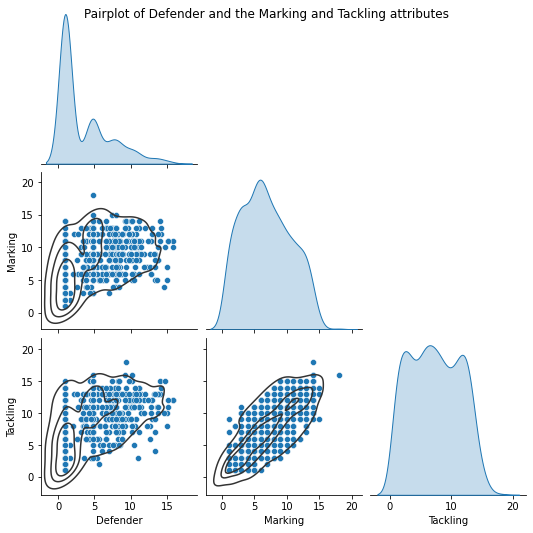

In [ ]:
g = sns.pairplot(data17_df.sample(1000), diag_kind='kde', kind='scatter', palette='hls', 
             vars=['Defender', 'Marking', 'Tackling'], corner=True)
g.map_lower(sns.kdeplot, levels=4, color=".2")
g.fig.suptitle('Pairplot of Defender and the Marking and Tackling attributes');

The plots above are not very illuminating. There doesn't seem to be a clear relationship between the Defender position and the selected attributes. We can also see that the attributes' values are roughly uniformly distributed, and the density is higher for low defender scores in the scatter plots between Defender and Marking and Tackling.

###Correlation between Attacker and selected attributes

We repeat the same calculations and plots as above to visualize the correlation between the Attacker position and the most correlated attributes.

In [ ]:
data17_corrmatrix.loc[(data17_corrmatrix['Attacker'] > 0.5) | (data17_corrmatrix['Attacker'] <= -0.5)]

,Height,Weight,AerialAbility,CommandOfArea,Communication,Eccentricity,Handling,Kicking,OneOnOnes,Reflexes,...,Pressure,Professional,Sportsmanship,Temperament,Controversy,Goalkeeper,Sweeper,Attacker,Defender,Midfielder
Dribbling,-0.308443,0.136797,-0.449409,-0.435536,-0.425809,-0.245992,-0.453068,-0.434221,-0.424532,-0.460357,...,-0.009605,0.031690,-0.005741,-0.142768,0.157309,-0.491203,-0.071306,0.608733,-0.107220,0.269796
Finishing,-0.189362,0.114267,-0.415303,-0.402596,-0.395547,-0.228350,-0.420993,-0.401730,-0.393069,-0.425579,...,0.000342,0.017413,-0.032409,-0.125400,0.140618,-0.453818,-0.068877,0.591259,-0.273553,0.139342
Flair,-0.290931,0.104535,-0.388445,-0.368027,-0.354190,-0.168139,-0.396259,-0.373790,-0.351953,-0.398431,...,-0.000257,0.023980,0.014912,-0.120566,0.172879,-0.432607,-0.063316,0.603841,-0.185695,0.286905
Attacker,-0.261152,0.058659,-0.256910,-0.250823,-0.244085,-0.141567,-0.259328,-0.246831,-0.241372,-0.263896,...,-0.042376,-0.033102,0.037850,-0.041118,0.120911,-0.279303,-0.107297,1.000000,-0.386523,0.212843


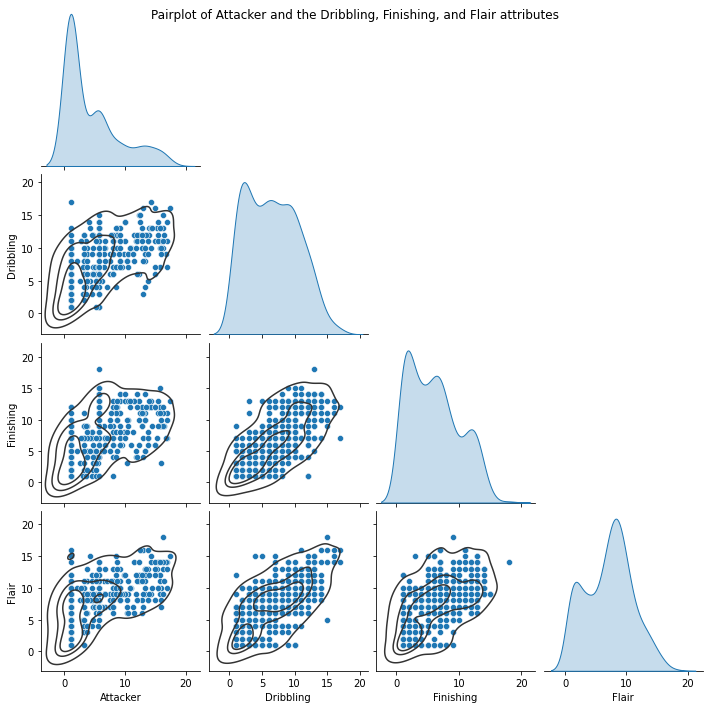

In [ ]:
g = sns.pairplot(data17_df.sample(500), diag_kind='kde', kind='scatter', palette='husl', 
                vars=['Attacker', 'Dribbling', 'Finishing', 'Flair'], corner=True)
g.map_lower(sns.kdeplot, levels=4, color=".2")
g.fig.suptitle('Pairplot of Attacker and the Dribbling, Finishing, and Flair attributes');

The same can be concluded for the Attacker position - no clear relationship between this position and the selected attributes. The density plots in these scatter plots are almost vertical, with highest density at lower attacker scores. The distribution of the attributes is less uniform but it doesn't show any clear distribution.

###Correlation between Midfielder and selected attributes

Looking for abilities that are somewhat correlated with the Midfielder position, we see that there aren't any. So, we just plot a KDE plot of the distribution of the Midfielder rankings and see that more than half of the players perform poorly in this position.

In [ ]:
data17_corrmatrix.loc[(data17_corrmatrix['Midfielder'] > 0.5) | (data17_corrmatrix['Midfielder'] <= -0.5)]
# nothing is strongly correlated with being a midfielder

,Height,Weight,AerialAbility,CommandOfArea,Communication,Eccentricity,Handling,Kicking,OneOnOnes,Reflexes,...,Pressure,Professional,Sportsmanship,Temperament,Controversy,Goalkeeper,Sweeper,Attacker,Defender,Midfielder
Midfielder,-0.250406,0.07562,-0.281096,-0.271859,-0.267364,-0.156754,-0.285123,-0.271811,-0.268086,-0.287743,...,0.011691,0.064964,0.088266,-0.003263,0.072799,-0.305553,-0.046577,0.212843,-0.030259,1.0


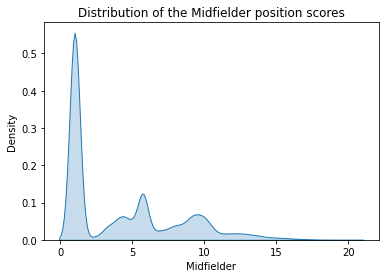

In [ ]:
f = plt.figure()
sns.kdeplot(data17_df['Midfielder'], shade=True)
plt.title("Distribution of the Midfielder position scores");

###Correlation between Goalkeeper and selected attributes

The Goalkeeper position is strongly correlated with 11 abilities. The correlation matrix is shown below together with a pairplot of the Goalkeeper position and the chosen abilities.

In [ ]:
data17_corrmatrix.loc[(data17_corrmatrix['Goalkeeper'] > 0.5) | (data17_corrmatrix['Goalkeeper'] <= -0.5)]

,Height,Weight,AerialAbility,CommandOfArea,Communication,Eccentricity,Handling,Kicking,OneOnOnes,Reflexes,...,Pressure,Professional,Sportsmanship,Temperament,Controversy,Goalkeeper,Sweeper,Attacker,Defender,Midfielder
AerialAbility,0.319843,0.057896,1.000000,0.842079,0.825440,0.489145,0.863806,0.835399,0.824305,0.870721,...,0.015331,0.028753,0.014580,0.013178,-0.022729,0.913827,-0.042770,-0.256910,-0.219853,-0.281096
CommandOfArea,0.300543,0.068352,0.842079,1.000000,0.831043,0.506383,0.848427,0.828733,0.830037,0.855927,...,0.019170,0.035974,0.016238,0.005944,-0.014902,0.890177,-0.042854,-0.250823,-0.215140,-0.271859
Communication,0.292467,0.076039,0.825440,0.831043,1.000000,0.525467,0.831022,0.819597,0.830460,0.841986,...,0.016009,0.040256,0.020126,-0.001283,-0.008232,0.870470,-0.041604,-0.244085,-0.209210,-0.267364
Eccentricity,0.177972,0.081247,0.489145,0.506383,0.525467,1.000000,0.479278,0.494510,0.540759,0.506986,...,0.006580,0.042569,0.030785,-0.017736,0.032629,0.509243,-0.024873,-0.141567,-0.124447,-0.156754
Handling,0.312036,0.050659,0.863806,0.848427,0.831022,0.479278,1.000000,0.847231,0.833736,0.889646,...,0.017627,0.028607,0.009581,0.009531,-0.025646,0.929661,-0.045411,-0.259328,-0.224597,-0.285123
Kicking,0.301843,0.064208,0.835399,0.828733,0.819597,0.494510,0.847231,1.000000,0.824478,0.856879,...,0.015747,0.031632,0.006338,-0.002257,-0.016574,0.887861,-0.040838,-0.246831,-0.214693,-0.271811
OneOnOnes,0.297520,0.084320,0.824305,0.830037,0.830460,0.540759,0.833736,0.824478,1.000000,0.850779,...,0.016292,0.043867,0.024104,-0.001954,-0.005103,0.869172,-0.041103,-0.241372,-0.210832,-0.268086
Reflexes,0.316572,0.054805,0.870721,0.855927,0.841986,0.506986,0.889646,0.856879,0.850779,1.000000,...,0.017154,0.033284,0.017202,0.010966,-0.020958,0.938509,-0.043291,-0.263896,-0.226745,-0.287743
RushingOut,0.286062,0.073049,0.800439,0.802750,0.798375,0.533177,0.808331,0.794961,0.807426,0.824910,...,0.018611,0.043186,0.027531,0.005707,-0.004688,0.852312,-0.041806,-0.240276,-0.205055,-0.261018
TendencyToPunch,0.288578,0.067120,0.790245,0.787979,0.788936,0.528653,0.797500,0.783364,0.795182,0.815237,...,0.013409,0.036502,0.023752,0.003665,-0.002770,0.844771,-0.038220,-0.238085,-0.204640,-0.258905


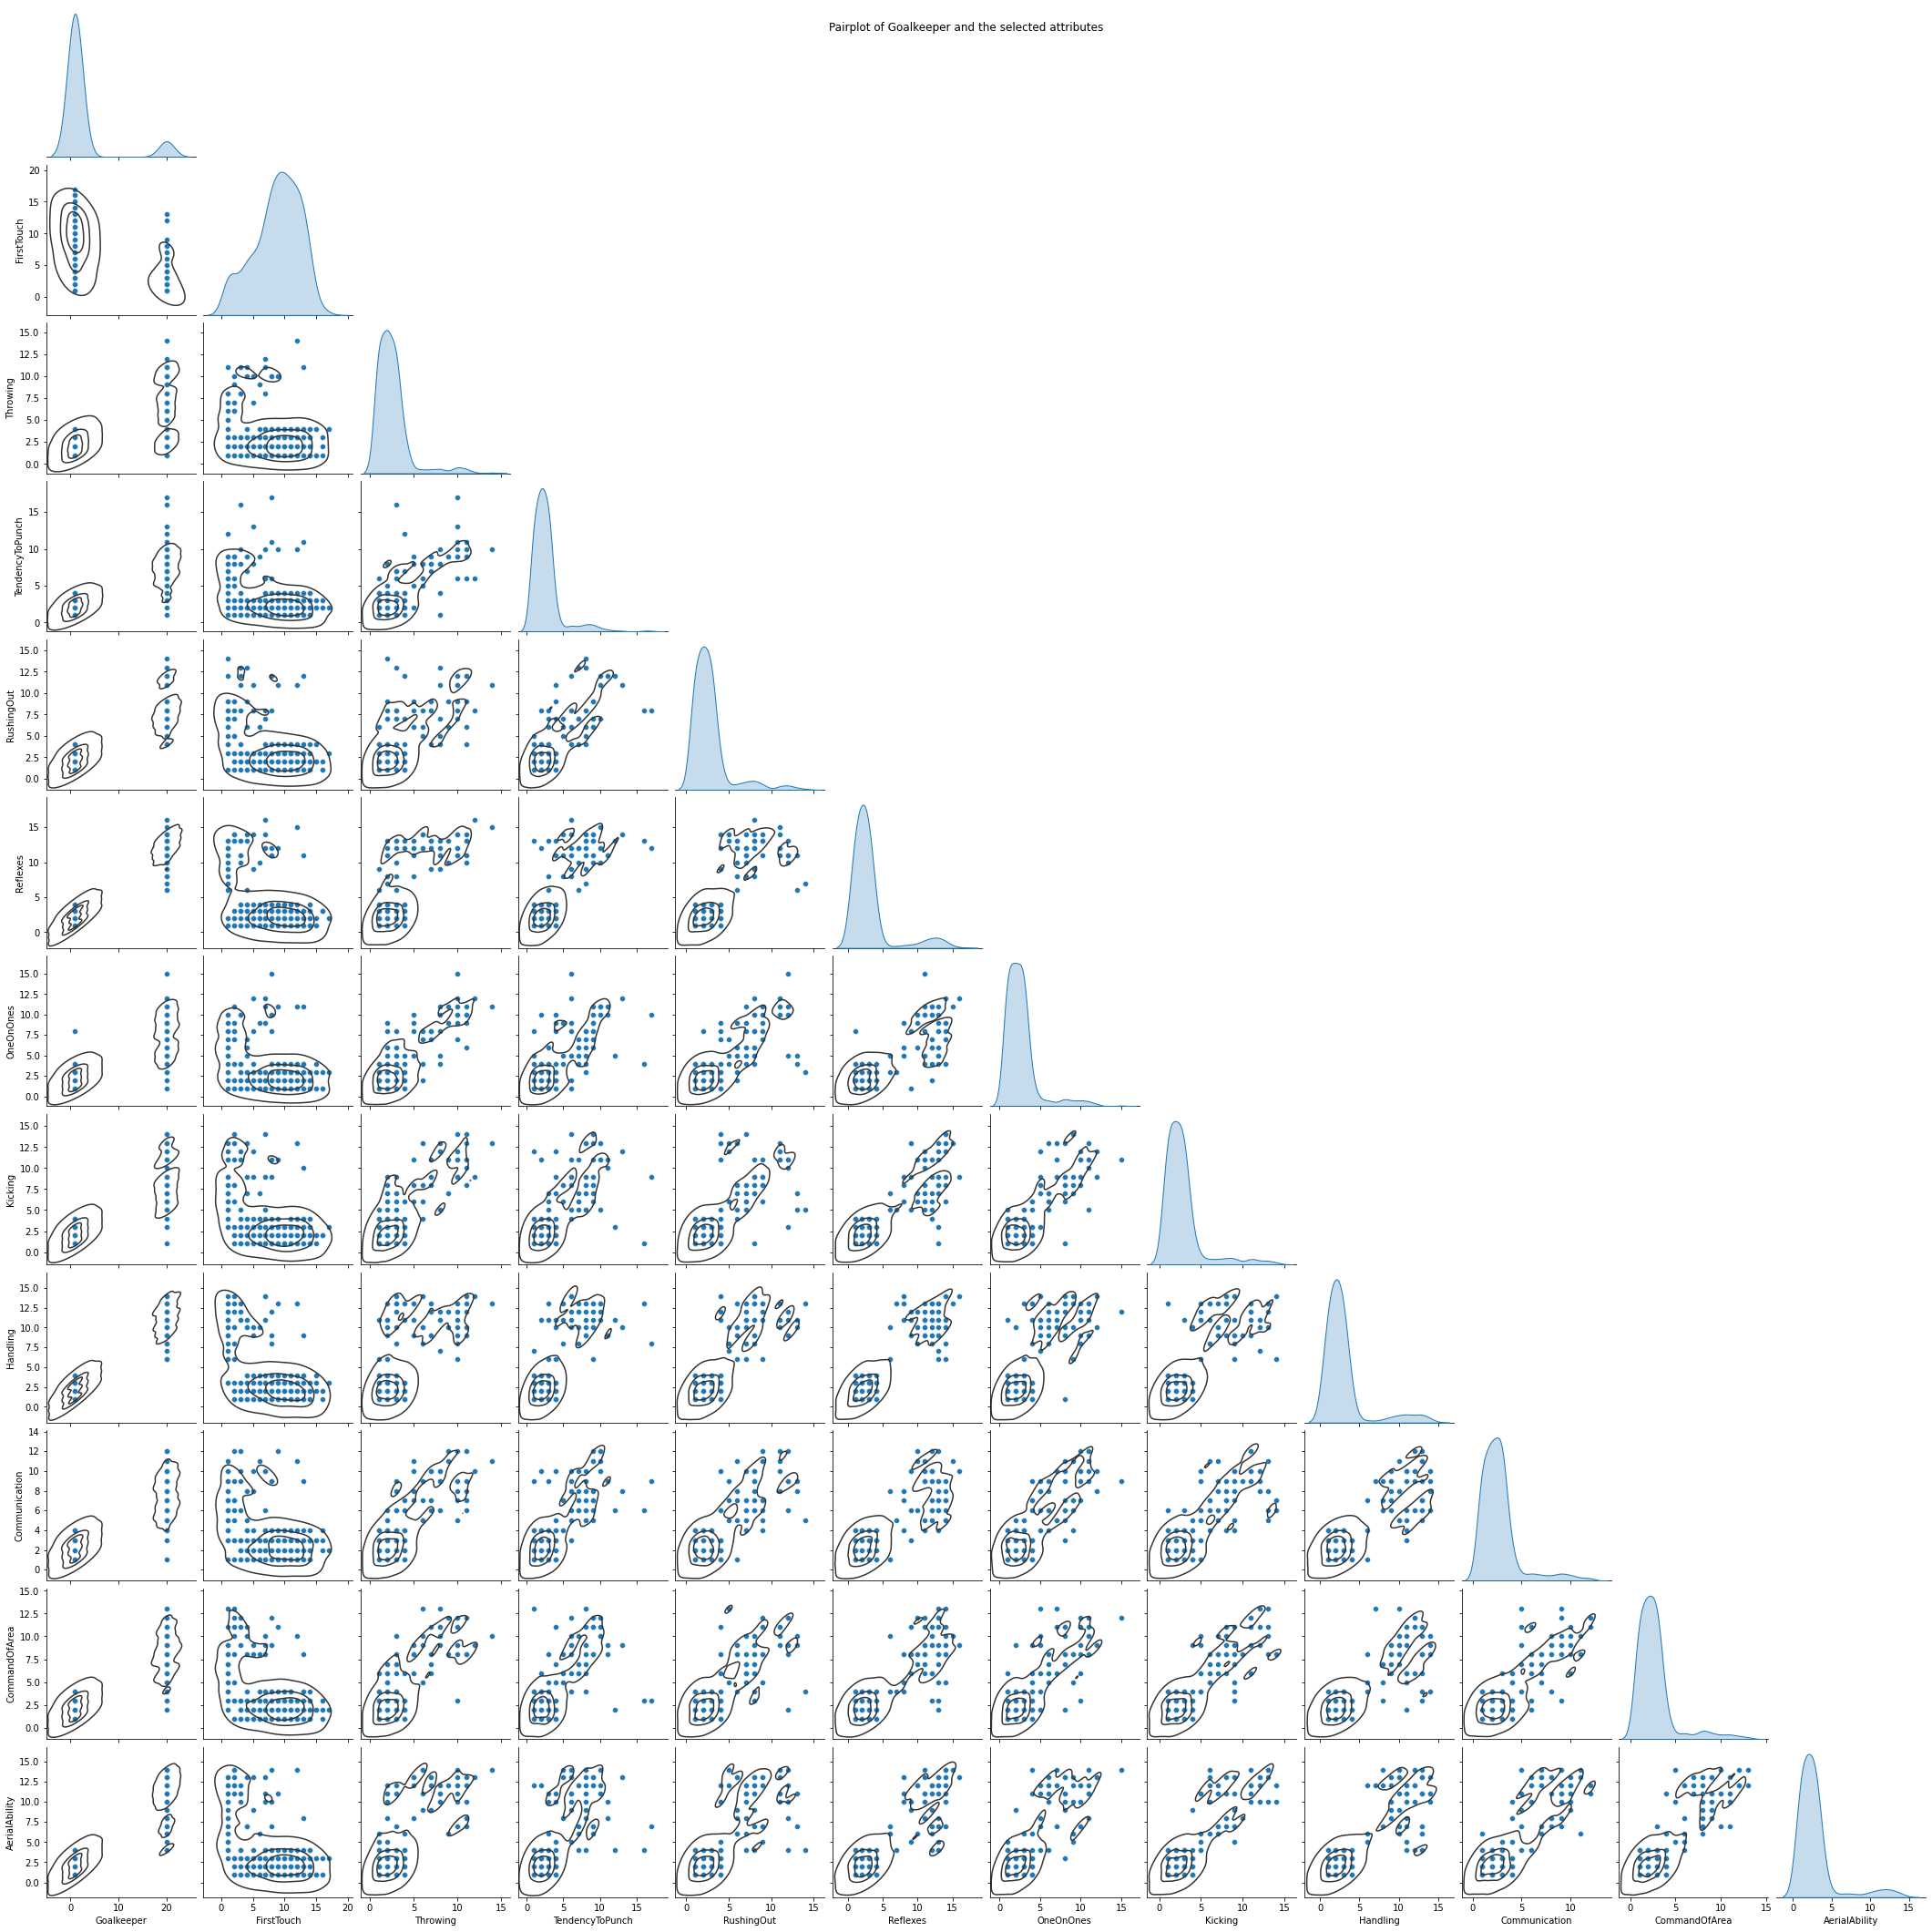

In [ ]:
g = sns.pairplot(data17_df.sample(500), diag_kind='kde', kind='scatter', palette='husl', vars=['Goalkeeper', 'FirstTouch', 'Throwing', \
             'TendencyToPunch', 'RushingOut', 'Reflexes', 'OneOnOnes', 'Kicking', 'Handling', 'Communication', 'CommandOfArea', 'AerialAbility'],
             corner=True)
g.map_lower(sns.kdeplot, levels=4, color=".2")
g.fig.suptitle('Pairplot of Goalkeeper and the selected attributes');

From the pairplot above, we can see that the distribution of most attributes is centered at low scores, which is different from the distribution of the attributes that we saw above. The distribution of the goalkeeper scores is the most peculiar, with the majority of the players having low scores. This makes sense as there are very few Goalkeepers compared to other positions. For most attributes, it seems like there is a clear cut value - if the player scores above that value, then they are a good Goalkeeper and vice versa.

##Weekly Wage Analyses

### General Wage Distributions

Now let's visualize the distribution of wages for all players in 2020 and then compare it to the distribution of wages for only those players in 2020 who've been playing since 2017 (the more seasoned players).

We'll only consider the players who are actually payed. It's unclear whether the players whose "Weekly Wage (EUR)" value is 0 are actually volunteer players or if Football Manager just didn't have wage data available for them, so we'll exclude them.

Max Weekly Wage: €1200k = €1200000
Min Weekly Wage: €0.002k = €2
Median Weekly Wage: €0.325k = €325
Mean Weekly Wage: €2.148205569972433k = €2148



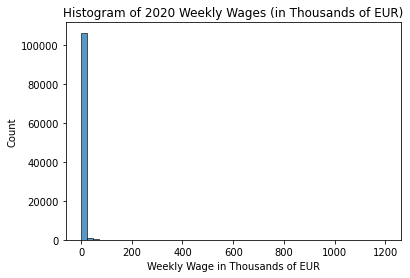

In [ ]:
data20_df_wages = data20_df[data20_df["Weekly Wage (EUR)"] > 0]["Weekly Wage (EUR)"]

max_weekly_wage_2020 = (data20_df_wages / 1000).max()
min_weekly_wage_2020 = (data20_df_wages / 1000).min()
med_weekly_wage_2020 = (data20_df_wages / 1000).median()
mean_weekly_wage_2020 = (data20_df_wages / 1000).mean()

print("Max Weekly Wage: €" + str(int(max_weekly_wage_2020)) + "k = €" + str(int(max_weekly_wage_2020 * 1000)))
print("Min Weekly Wage: €" + str(min_weekly_wage_2020) + "k = €" + str(int(min_weekly_wage_2020 * 1000)))
print("Median Weekly Wage: €" + str(med_weekly_wage_2020) + "k = €" + str(int(med_weekly_wage_2020 * 1000)))
print("Mean Weekly Wage: €" + str(mean_weekly_wage_2020) + "k = €" + str(int(mean_weekly_wage_2020 * 1000)))

print("")

hist_wage_2020 = sns.histplot(data = data20_df_wages / 1000, bins = 50);
hist_wage_2020.set_xlabel("Weekly Wage in Thousands of EUR");
hist_wage_2020.set_title("Histogram of 2020 Weekly Wages (in Thousands of EUR)");

Zooming in on the left side of the table:

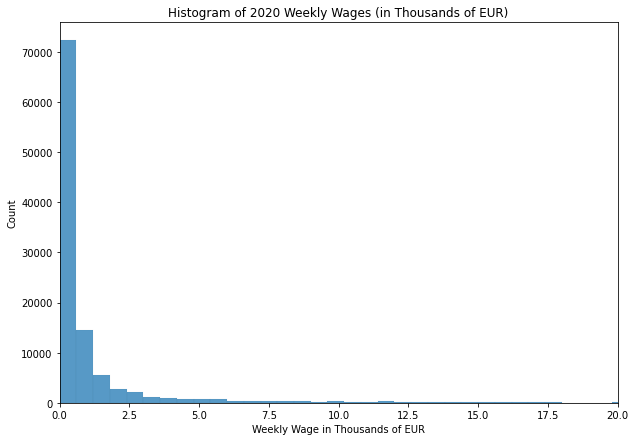

In [ ]:
plt.rcParams["figure.figsize"] = (10,7)
hist_wage_2020 = sns.histplot(data = data20_df_wages / 1000, bins = 2000);
hist_wage_2020.set_xlabel("Weekly Wage in Thousands of EUR");
hist_wage_2020.set_title("Histogram of 2020 Weekly Wages (in Thousands of EUR)");
hist_wage_2020.set_xlim(0,20);

With a minimum weekly wage of €2 and a median weekly wage of €325 despite a mean weekly wage of €2,148 and a maximum weekly wage of €1,200,000, it's clear that weekly wages are heavily skewed towards the right (towards higher wages) due to a small subset of extraordinarily well-payed players.

The mean wage is more than six times larger than the median wage, meaning this rightward skew is very strong. These well-compensated outlier players are being paid much much more than their fellow footballers.

Now let's take a look at the wage distribution for players in 2020 who've been playing since 2017 (as opposed to the earlier situation involving all players in 2020).

Like before, we'll only consider those who are actually being paid a non-zero wage.

Max Weekly Wage: €1200.0k = €1200000
Min Weekly Wage: €0.002k = €2
Median Weekly Wage: €0.6k = €600
Mean Weekly Wage: €3.625765474100305k = €3625



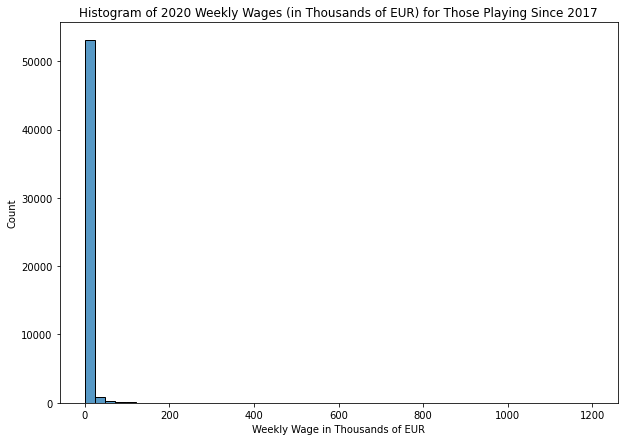

In [ ]:
joined_data_df_wages = cleaned_joined_df[cleaned_joined_df["Weekly Wage (EUR) (2020)"] > 0]["Weekly Wage (EUR) (2020)"]

max_weekly_wage_joined = (joined_data_df_wages / 1000).max()
min_weekly_wage_joined = (joined_data_df_wages / 1000).min()
med_weekly_wage_joined = (joined_data_df_wages / 1000).median()
mean_weekly_wage_joined = (joined_data_df_wages / 1000).mean()

print("Max Weekly Wage: €" + str(max_weekly_wage_joined) + "k = €" + str(int(max_weekly_wage_joined * 1000)))
print("Min Weekly Wage: €" + str(min_weekly_wage_joined) + "k = €" + str(int(min_weekly_wage_joined * 1000)))
print("Median Weekly Wage: €" + str(med_weekly_wage_joined) + "k = €" + str(int(med_weekly_wage_joined * 1000)))
print("Mean Weekly Wage: €" + str(mean_weekly_wage_joined) + "k = €" + str(int(mean_weekly_wage_joined * 1000)))

print("")

hist_wage_joined = sns.histplot(data = joined_data_df_wages / 1000, bins = 50);
hist_wage_joined.set_xlabel("Weekly Wage in Thousands of EUR");
hist_wage_joined.set_title("Histogram of 2020 Weekly Wages (in Thousands of EUR) for Those Playing Since 2017");

As we can see from the wage distribution for 2020 players who've played since 2017, the minimum and maximum weekly wages have stayed the same and the distribution is still heavily right-skewed (albeit a bit less as the mean is now only 6.04x larger than the median whereas in the distribution of all 2020 players, it was 6.6x larger than the median).

However, the average (both median and mean) weekly wages are higher for these seasoned players than the averages for all 2020 players. This is probably unsurprising as these players (those in 2020 who've been playing since 2017) are more experienced (meaning more valuable and thus worth more). It could also be that these players have stuck around for multiple seasons because they're more valuable (and are thus paid more).

Either way, it's interesting to see how the median weekly wage almost doubled (from €325 to €600) when considering those who've been playing the past four years instead of considering everyone playing in 2020.


### Wage vs. Position

Let's take a look at how weekly wages are distributed for each of the position groupings (attacker, midfielder, defender, and goalkeeper).

Are the positions generally paid equally or are some positions better paid?

Are all the positions' wage distributions relatively compact or is there great variety in the wages of a position's players?

To visualize these distributions, we'll create boxplots of the wage distributions for each of the position groups and display them side-by-side.

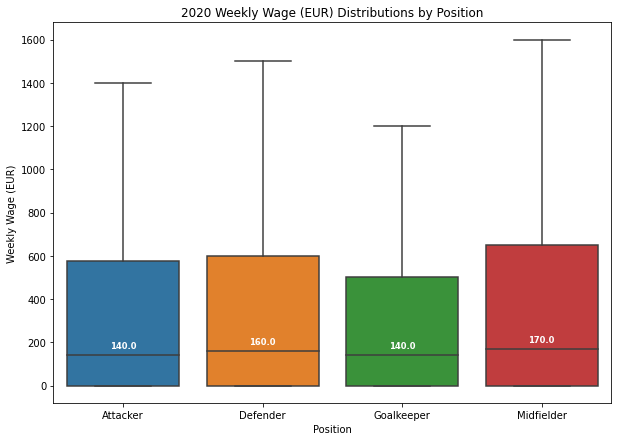

In [ ]:
data20_df_pos_wage = data20_df[["Position", "Weekly Wage (EUR)"]].sort_values(by = "Position")
medians = data20_df_pos_wage.groupby(["Position"])["Weekly Wage (EUR)"].median()
vertical_offset = data20_df_pos_wage["Weekly Wage (EUR)"].median() * 0.2

pos_wage_bxplot = sns.boxplot(x = "Position", y = "Weekly Wage (EUR)", data = data20_df_pos_wage, showfliers = False);

for xtick in pos_wage_bxplot.get_xticks():
  pos_wage_bxplot.text(xtick, medians[xtick] + vertical_offset, medians[xtick], horizontalalignment = "center", size = "small", color = "w", weight = "bold");

pos_wage_bxplot.set_title("2020 Weekly Wage (EUR) Distributions by Position");
pos_wage_bxplot.set_xticklabels(["Attacker", "Defender", "Goalkeeper", "Midfielder"]);


Note: The values in white above the median lines for each boxplot are the median values.

Note II (the sequel nobody asked for): Outliers were exluded from the boxplot visualizations as they completely destroyed the scaling and made the plots borderline unreadable. Since these boxplots are based on medians and quartiles as opposed to means, the few outliers being ignored have a marginal impact on these distributions.

As we quickly see by looking at these boxplots, all four position groups have about the same average (median) pay.

However, some positions are more variable with their wages than others.

Goalkeepers have a notably more compact wage distribution than the other positions. On the flipside, midfielders have the least compact/most variable wage distribution compared to the other positions.

As someone relatively unfamiliar with Football, any guess I make as to why this is should be taken with an entire shipping container's worth of salt.

Maybe goalkeepers are the least variable when it comes to wages because they are the smallest position (in terms of numbers of players, not in terms of importance). If a team only has about two goalies (main and a backup), there are not a lot of intra-team comparisons to be made when deciding wages. You pay the main goalie X and then pay the backup goalie something less. But you can't create some complex hierarchy of player worth for the goalies as there's only two. But with the other more populated positions, you can more easily create a spectrum based on the players' worth and determine pay accordingly. Those at the top and bottom of a large hierarchy will have a bigger pay disparity than those at the extremes of a very small hierarchy.

Midfielders don't have the least compact wage distribution by a large factor compared to attackers and defenders, but maybe their distribution is slighly less compact because midfielders are the hardest to judge. Attackers and defenders have clear offensive and defensive stats to base performance off of. But midfielders seem to fall in a middleground between the two in which performance becomes a bit more muddied. If one midfielder is better offensively and another is better defensively, which is better? It's harder to say. They're being compared on a wider range of metrics. And thus it's harder to pinpoint their worth and the amount to pay them. And so maybe that's why midfielders are paid more variable wages than the other positions.

##Preferred Foot Analyses


Now we'll take a long at the distributions of preferred feet (left-footedness vs. right-footedness) both for all 2020 players and for only those 2020 players who've been playing since 2017.

For the purposes of creating a ternary distinction between a left vs. right vs. either preference, we'll consider both "Right" and "Right Only" as a right foot preference and "Left" and "Left Only" as a left foot preference, leaving only "Either" as the true both-footedness option.

Total Players: 144743

Left-Footed Players: 29839 (20.62%)
Ambidextrous Players: 3544 (2.45%)
Right-Footed Players: 111360 (76.94%)



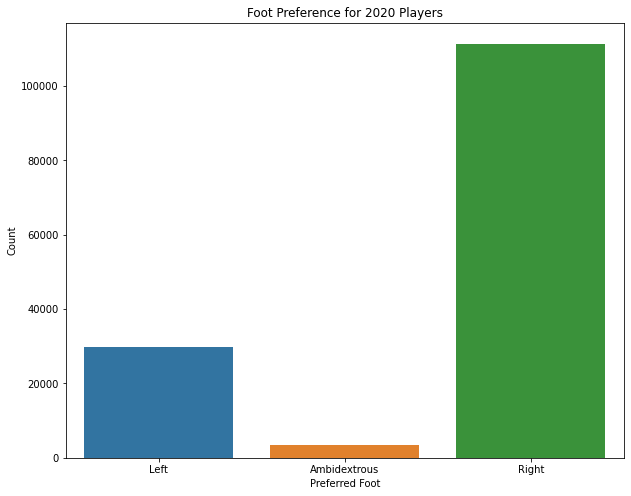

In [ ]:
def left_or_right(preference):
  if "Left" in preference:
    return "Left"
  elif "Right" in preference:
    return "Right"
  else:
    return "Ambidextrous"

data20_df_feet = data20_df.copy()

data20_df_feet["Preferred Foot"] = data20_df["Preferred Foot"].apply(left_or_right)

player_2020_count = data20_df_feet["Preferred Foot"].count()

r_foot_2020_count = data20_df_feet[data20_df_feet["Preferred Foot"] == "Right"]["Preferred Foot"].count()
r_foot_2020_percent = ((r_foot_2020_count / player_2020_count) * 100).round(2)

l_foot_2020_count = data20_df_feet[data20_df_feet["Preferred Foot"] == "Left"]["Preferred Foot"].count()
l_foot_2020_percent = ((l_foot_2020_count / player_2020_count) * 100).round(2)

ambi_foot_2020_count = data20_df_feet[data20_df_feet["Preferred Foot"] == "Ambidextrous"]["Preferred Foot"].count()
ambi_foot_2020_percent = ((ambi_foot_2020_count / player_2020_count) * 100).round(2)

print("Total Players: " + str(player_2020_count))

print("")

print("Left-Footed Players: " + str(l_foot_2020_count) + " (" + str(l_foot_2020_percent) + "%)")
print("Ambidextrous Players: " + str(ambi_foot_2020_count) + " (" + str(ambi_foot_2020_percent) + "%)")
print("Right-Footed Players: " + str(r_foot_2020_count) + " (" + str(r_foot_2020_percent) + "%)")

print("")

plt.figure(figsize=(10,8))
hist_feet_2020 = sns.countplot(x = "Preferred Foot", data = data20_df_feet);
hist_feet_2020.set_ylabel("Count");
hist_feet_2020.set_title("Foot Preference for 2020 Players");

While it's unsurprising that the vast majority of players are right-footed, it is interesting that while it's estimated that a little over 10% of the world is left-dominant, about 20% of these footballers are left-dominant.

To wager a guess for why this is, while left- vs. right-dominance doesn't matter much for non-atheletes, the distinction becomes very relevant for atheletes (especially those playing team sports). 

If a football team was composed of all right-dominant players, they'd be significantly weaker on one side of the field, so they'd prefer to pick up a sizable amount of left-dominant players to strengthen their team on that side of the field.

And thus left-dominant people are overrepresented in team sports (as they provide a rare but useful skill).

Now we'll take a look at the distribution of foot preference for only those 2020 players who've been playing since 2017.

Total Players: 73966

Left-Footed Players: 16322 (22.07%)
Ambidextrous Players: 1844 (2.49%)
Right-Footed Players: 55800 (75.44%)



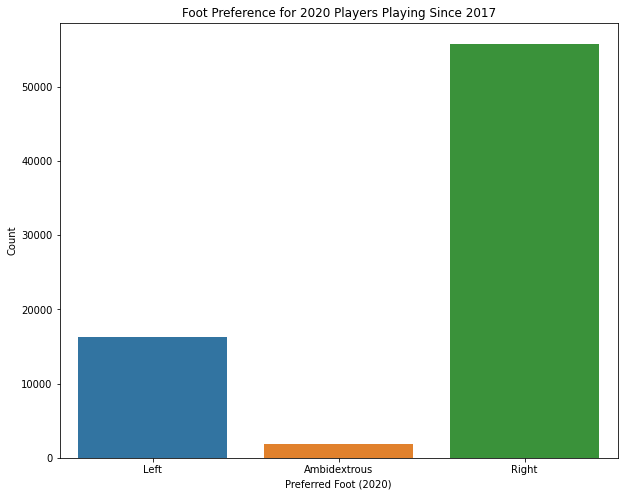

In [ ]:
joined_df_feet = cleaned_joined_df.copy()

joined_df_feet["Preferred Foot (2020)"] = cleaned_joined_df["Preferred Foot (2020)"].apply(left_or_right)

player_joined_count = joined_df_feet["Preferred Foot (2020)"].count()

r_foot_joined_count = joined_df_feet[joined_df_feet["Preferred Foot (2020)"] == "Right"]["Preferred Foot (2020)"].count()
r_foot_joined_percent = ((r_foot_joined_count / player_joined_count) * 100).round(2)

l_foot_joined_count = joined_df_feet[joined_df_feet["Preferred Foot (2020)"] == "Left"]["Preferred Foot (2020)"].count()
l_foot_joined_percent = ((l_foot_joined_count / player_joined_count) * 100).round(2)

ambi_foot_joined_count = joined_df_feet[joined_df_feet["Preferred Foot (2020)"] == "Ambidextrous"]["Preferred Foot (2020)"].count()
ambi_foot_joined_percent = ((ambi_foot_joined_count / player_joined_count) * 100).round(2)

print("Total Players: " + str(player_joined_count))

print("")

print("Left-Footed Players: " + str(l_foot_joined_count) + " (" + str(l_foot_joined_percent) + "%)")
print("Ambidextrous Players: " + str(ambi_foot_joined_count) + " (" + str(ambi_foot_joined_percent) + "%)")
print("Right-Footed Players: " + str(r_foot_joined_count) + " (" + str(r_foot_joined_percent) + "%)")

print("")

plt.figure(figsize=(10,8))
hist_feet_joined = sns.countplot(x = "Preferred Foot (2020)", data = joined_df_feet, order = ["Left", "Ambidextrous", "Right"]);
hist_feet_joined.set_ylabel("Count");
hist_feet_joined.set_title("Foot Preference for 2020 Players Playing Since 2017");

While it may not be statistically significant, there does appear to be a slight decrease in right-footedness and a slight increase in left-footedness when considering only the 2020 players who've been around since 2017 instead of all 2020 players. 

It seems there was about a 1.5% decrease in right-footedness with a corresponding 1.5% increase in left-footedness (with ambidextrousness staying constant).

If this is a significant difference, then maybe it's because left-dominant players (due to their rareness) are valued higher and thus teams are less prone to releasing their left-dominant players. And since left-dominant players are in higher demand, those players are more incentivized financially to continue playing year after year (so perhaps they won't view retirement favorably as soon as right-dominant players).

To visualize these changes in foot preference between all 2020 players and those 2020 players who've been playing since 2017, let's visualize a barplot with both distributions side by side.

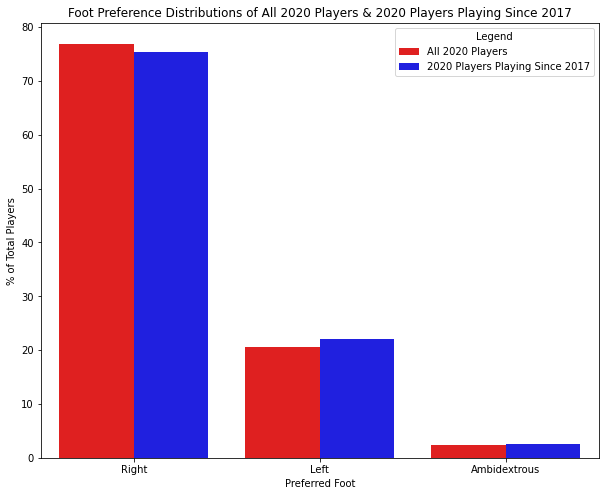

In [ ]:
pref_2020_lst = data20_df_feet["Preferred Foot"].value_counts() / data20_df_feet["Preferred Foot"].count() * 100
pref_2017_2020_lst = joined_df_feet["Preferred Foot (2020)"].value_counts() / joined_df_feet["Preferred Foot (2020)"].count() * 100

comb_df = pd.concat([pref_2020_lst, pref_2017_2020_lst], axis=1)
comb_df.columns = ["All 2020 Players", "2020 Players Playing Since 2017"]

comb_df = comb_df.reset_index().melt(id_vars = ["index"])

plt.figure(figsize=(10,8))
sns.barplot(x = "index", y = "value", hue = "variable", data = comb_df, palette = ["red", "blue"], dodge = True);
plt.xlabel("Preferred Foot");
plt.ylabel("% of Total Players");
plt.gca().legend().set_title("Legend");
plt.title("Foot Preference Distributions of All 2020 Players & 2020 Players Playing Since 2017");

We can now more clearly see the previously noted slight proportional decrease in right-footed players and the slight increase in left-footed players when we compare all 2020 players to those who've been playing since 2017.

However, this graph also showcases how small that change really was. As a result, it's most likely not an indication of any real or significant shift in foot preference within the sport.

####Player Position vs Foot Preference

For further analyses of preferred foot, it would be useful to see whether there is a strong foot preference for certain positions. After some data processing to get the right information in the format we want, we plot a barplot to show this relationship.

In [ ]:
data20_df['Preferred Foot'] = data20_df['Preferred Foot'].str.split(' ').str[0]

In [ ]:
def position(val):
  if val == 'A':
    val = 'Attacker'
  elif val == 'D':
    val = 'Defender'
  elif val == 'M':
    val = 'Midfielder'
  else:
    val = 'Goalkeeper'
  return val

In [ ]:
feet_grouped_df = pd.get_dummies(data20_df['Position'], prefix=None)
feet_grouped_df['Preferred Foot'] = data20_df['Preferred Foot']
feet_grouped_df = feet_grouped_df.groupby('Preferred Foot', as_index=True).sum()
feet_grouped_df = feet_grouped_df.reset_index().melt(id_vars = ["Preferred Foot"])
feet_grouped_df['variable'] = feet_grouped_df['variable'].apply(position)

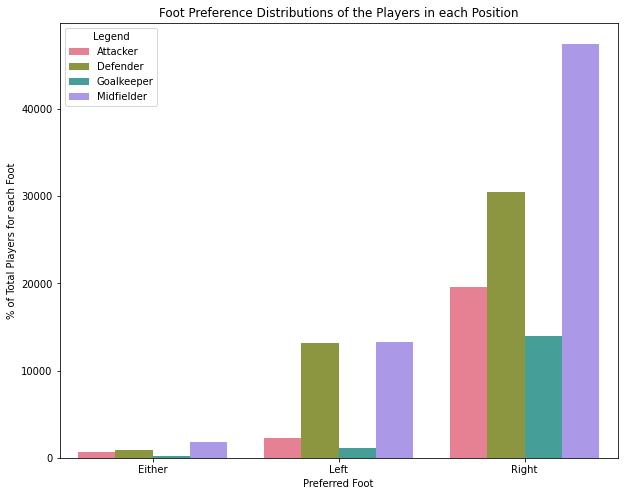

In [ ]:
plt.figure(figsize=(10,8))
sns.barplot(x="Preferred Foot", y='value', hue='variable', data=feet_grouped_df, dodge=True, palette='husl')
plt.xlabel("Preferred Foot");
plt.ylabel("% of Total Players for each Foot");
plt.gca().legend(loc='upper left').set_title("Legend");
plt.title("Foot Preference Distributions of the Players in each Position");

Given that there is a strong preference among players for playing with the right foot, it is not unexpected that all positions tend towards being played with the right foot. Surprisingly, most Goalkeepers and Midfielders prefer playing with their right foot. That is true for the other two positions, but it is not as striking.

## Relation Between Age and Current Ability

Let's now consider the relationship between age and current ability. Does current ability decrease or increase with age? Or maybe it increases up to a certain age before decreasing?

To try and answer these questions, we'll create a jointplot to showcase the relationship between age and current ability of 2020 players.

This jointplot will consist of a scatterplot (of age vs. current ability) in the middle with a plotted regression line, a histogram of the age distribution on the top, and a histogram of the current ability distribution on the right-hand side.

Note: It's important to remember that we're technically only looking at the relationship between current ability and age for those who were playing professional football when the data was taken. This is NOT the same as the general relationship between current ability and age (as those who are playing professionally must meet a certain performance threshold and thus those that can no longer meet said threshold due to age would vanish from our professional dataset). 

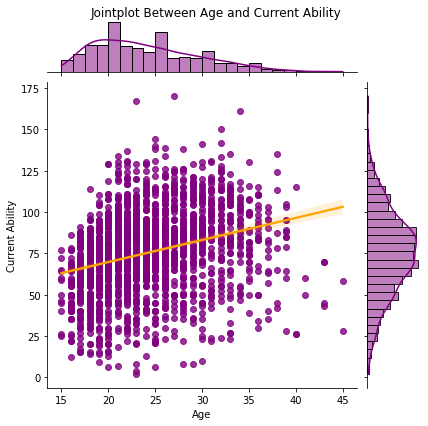

In [ ]:
## age vs current ability joint plot

age_ca_df = data20_df[["Age", "Current Ability"]]

sns.jointplot(data = age_ca_df.sample(n=2000, random_state = 1), x = "Age", y = "Current Ability", kind = "reg", color = "purple", joint_kws = {"line_kws": {"color": "orange"}});
plt.suptitle("Jointplot Between Age and Current Ability");
plt.subplots_adjust(top = 0.95);

As we can see from the regression line in the above jointplot, there is a slight positive correlation between age and current ability when it comes to current professional football players.

This certainly goes against my preconceived notion that when considering all people, age and current ability are positively correlated up until about 30-ish and then negatively correlated as bodies start to deteriorate.

However, we're working exclusively with datapoints representing current professional players. And any oldies who've lost their edge wouldn't have been resigned and would no longer be professional players. So they would not appear in the dataset, making it look like older ages aren't linked to lower athletic abilities.

So to guess why this slight positive correlation can be seen, I'd say that the only way an older player could stick around in the big leagues would be if they were exceptionally good (as it would generally be more worthwhile to drop the oldies who will only get worse and start investing in a currently less-skilled younger player who could grow and evolve into a star).

So many of the older players that still remain in the professional leagues must be considerably skilled (enough to dissuade management from replacing them with fresh talent with high potential). And thus it looks like there's a positive relationship between age and current ability even past the 30s.

As for the positive relationship pre-30s, that's not really surprising. It makes sense that as the body stays relatively close to its prime (supposedly around age 25), the increasing experience a player receives from playing will lead to better and better abilities each year. For example, if the body stays relatively equally strong from ages 25 to 28, it would make sense that the 28-year old with (presumably) a few more years of experience over the 25-year old would better.

As for the individual age and current ability distrubtions seen on the top and right side of the jointplot respectively, we can see that the age distribution (top) is more concentrated around younger ages and has a right tail (towards the older ages). Unsurprisingly, younger players are more common in the professional leagues and there are fewer and fewer players at older and older ages.

For the current ability distribution (right), it appears to be relatively normally distributed. Most players are pretty average (by professional standards) with some exceptional standouts and some underperforming players.

Let's take a quick look at the minimums, medians, and maximums for these two distributions so we can put some numbers to these pictures.

In [ ]:
age_min = age_ca_df["Age"].min()
age_med = age_ca_df["Age"].median()
age_max = age_ca_df["Age"].max()

ca_min = age_ca_df["Current Ability"].min()
ca_med = age_ca_df["Current Ability"].median()
ca_max = age_ca_df["Current Ability"].max()

print("Min Age: " + str(age_min))
print("Median Age: " + str(age_med))
print("Max Age: " + str(age_max))

print("")

print("Min Ability: " + str(ca_min))
print("Median Ability: " + str(ca_med))
print("Max Ability: " + str(ca_max))

Min Age: 14
Median Age: 23.0
Max Age: 53

Min Ability: 1
Median Ability: 76.0
Max Ability: 195


Since the median age is much closer to the minimum age, we can see numeric proof of the age distribution being mainly left (young) concentrated with a right (older) skew.

The median for the current ability distribution is closer to the minimum ability than the maximum ability but not by a large degree, so there doesn't seem to be a considerable skew in either direction.

What's most interesting is that nobody was given an ability of 200 (the maximum possible by Football Manager's standards). Every player has room for improvement according to Football Manager.

The lack of a 200 ability player is probably just because I don't play professionally. Despite not having played football since I was 7, I have absolutely no room for improvement. My skills are impeccable.

##Geography-based Analyses


Football is *the* world's game. [FIFA claims](https://www.fifa.com/tournaments/mens/worldcup/2018russia/media-releases/more-than-half-the-world-watched-record-breaking-2018-world-cup) that more than 1.12 billion people watched FIFA World Cup Final in 2018; that's about every 7th person on the planet! This contextualizes the sport's vast geographical footprint as it relates to fans, but there is certainly salient info to be gained about potential geographical trends as they relate to players, as well. Armed with our dataframes, [documentation on chloropleths](https://plotly.github.io/plotly.py-docs/generated/plotly.express.choropleth.html), and a [helpful Stack Exchange post](https://stackoverflow.com/questions/59297227/color-map-based-on-countries-frequency-counts), we begin our geographical-based EDA efforts:

###Player representation by country

To get a sense for where the players in our datasets are coming from and pontentially locate biases, let's visualize how many players from each country are represented in Football Manager.

In [ ]:
geo2020_freq = data20_df[['Country','Name']]
geo2020_freq = geo2020_freq.groupby('Country').count()
geo2020_freq.reset_index(inplace=True)

fig = px.choropleth(data_frame = geo2020_freq, locations="Country", locationmode = 'country names',
                    color="Name", hover_name='Name', color_continuous_scale=px.colors.sequential.deep,
                    labels = {'Name' : 'Number of Players'}, 
                    title = 'Number of Professional Players in Football Manager 2020')

fig.show()

Now let's compare to the joined dataset.

In [ ]:
joined_freq = cleaned_joined_df[['Country','Name']]
joined_freq = joined_freq.groupby('Country').count()
joined_freq.reset_index(inplace=True)

fig = px.choropleth(data_frame = joined_freq, locations="Country", locationmode = 'country names',
                    color="Name", hover_name='Name', color_continuous_scale=px.colors.sequential.deep,
                    labels = {'Name' : 'Number of Professional Players'}, 
                    title = 'Number of Professional Players by Country that appear in both FM2017 and FM2020')
fig.show()

The shrinking of our dataset after the join becomes very evident when we consider the extremes of the legend colorbars for the two plots. Nevertheless, it is also important to note that the plots retain a similar color distribution at least visually. This serves as further support for the validity of our selected join method. One of our worries was that the join would discard players from some countries at a disprortionate rate to other countries; however, the fact that the two plots have a similar color distribution suggests that instance removal was more or less proportionate.

As far as interesting insights from these two plots go, the graph would have us believe that not many professionals players come from Africa. This might seem surprising, given how many greats the African continent has given us - think the likes of George Weah, Samuel Eto'o, Didier Drogba, and most recently Mohamed Salah. In this sense, our data is misleading, however, which this plot has helped reveal. Looking at [the list of leagues represented in Football Manager 2020](https://www.gfinityesports.com/football-manager/football-manager-2020-leagues-list-in-fm-20/), it is worth noting that while FM20 tends to go deep down the football league pyramid for most European countries (usually, at least the two highest divisions are represented), the whole of Africa is represented only by two leagues in South Africa. Indeed, this explains why South Africa appears as the darkest-colored African country on the chloropleth. This bias is something we need to be aware of going forward.

###Geographical ability distribution

Aware of this bias towards players from non-European countries coming from better leagues, let's plot median player ability by country to confirm our current understanding that European countries should have lower median ability due to many players being present in lower leagues.

In [ ]:
geoability = cleaned_joined_df[['Country','Current Ability (2020)']]
geoability = geoability.groupby('Country').median()
geoability.reset_index(inplace=True)

fig = px.choropleth(data_frame = geoability, locations='Country', locationmode = 'country names',
                    color='Current Ability (2020)', hover_name='Current Ability (2020)', 
                    color_continuous_scale=px.colors.sequential.GnBu, labels = {'Name' : 'Median Curreny Ability'}, 
                    title = 'Median Player Ability - Joined DF')

fig.show()

The plot seems to confirm that the non-European players represented in our dataset are some of the best players that country has produced.

###Geographical wage distribution

Now being full cognizant of the fact that European contries are represented by many lower-league teams in the game while other countries tend to only be represented by their top two divisions at most, we expect the distribution of the median wage per player to actually be higher for non-European nations. Lower leagues is not where the money is at in football, and for instance, having many British players from lower divisions represented in the game will drag the national average down.

Given that only the best players tend to be good enough to attract the attention of foreign scouts and consequently play in foreign leagues, we expect high median values in African countries as well as other non-European countries not which do not have many players represented in the game. Those few represented in the game are presumably some of the best players in their country, and their salary is thus likely to be higher, too. The plot below confirms this hypothesis: Saudi Arabia is not typically seen as a footballing powerhouse, but being represented only by 139 players in the dataset allows it to attain the status of a country with the maximum median player wage value. 

Meanwhile, European countries, being affected by the presence of lower tier divisions, have relatively low median player wages despite what a person not aware of the dataset's idiosyncrasies would expect.


In [ ]:
geo2020_freq = cleaned_joined_df[['Country','Weekly Wage (EUR) (2020)']]
geo2020_freq = geo2020_freq.groupby('Country').median()
geo2020_freq.reset_index(inplace=True)

fig = px.choropleth(data_frame = geo2020_freq, locations="Country", locationmode = 'country names',
                    color="Weekly Wage (EUR) (2020)", hover_name='Weekly Wage (EUR) (2020)', 
                    color_continuous_scale=px.colors.sequential.GnBu, labels = {'Name' : 'Median Player Wage'}, 
                    title = 'Median Player Wage by Nation - Joined DF')

fig.show()

As a sanity check, let's also plot the maximum wage a player from any one nation gets. As expected, countries known for producing solid players (European & South American nations) are represented with higher wage figures on this plot. Note also the influence of outliers on this plot - it is not hard to deduce that Argentina emerges as leader due to Lionel Messi, *the Fly*, being Argentinian.

In [ ]:
geojoined_freq = cleaned_joined_df[['Country','Weekly Wage (EUR) (2020)']]
geojoined_freq = geojoined_freq.groupby('Country').max()
geojoined_freq.reset_index(inplace=True)

fig = px.choropleth(data_frame = geojoined_freq, locations="Country", locationmode = 'country names',
                    color="Weekly Wage (EUR) (2020)", hover_name='Weekly Wage (EUR) (2020)', 
                    color_continuous_scale=px.colors.sequential.GnBu, labels = {'Name' : 'Max Player Wage'}, 
                    title = 'Max Player Wage by Nation - Joined DF')

fig.show()

###Player Position Geomaps

In this section we explore the distribution of player position across the different countries. We sum the number of players for each position in each country and geographically represent it. <br>
Given that most players are from South America, Brazil and Argentina in particular, it is not surprising then to see a high concentration of players in each position in those regions. It is also interesting to note that not that many Attackers come from Europe compared to the other three positions.

In [ ]:
pos_nat_df = pd.get_dummies(cleaned_joined_df['Position'], prefix='position')
pos_nat_df['Country'] = cleaned_joined_df['Country']
pos_nat_grouped = pos_nat_df.groupby('Country', as_index=False).sum()

####Geo-distribution of Defenders

In [ ]:
geo2020_positionD = pos_nat_grouped[['Country','position_D']]

fig = px.choropleth(data_frame = geo2020_positionD, locations="Country", locationmode = 'country names',
                    color="position_D", hover_name='position_D', color_continuous_scale=px.colors.sequential.Inferno,
                    labels = {'position_D' : 'Number of Defenders'}, 
                    title = 'Distribution of Defenders Across Countries Football Manager 2020')

fig.show()

####Geo-distribution of Midfielders

In [ ]:
geo2020_positionM = pos_nat_grouped[['Country','position_M']]

fig = px.choropleth(data_frame = geo2020_positionM, locations="Country", locationmode = 'country names',
                    color="position_M", hover_name='position_M', color_continuous_scale=px.colors.sequential.Inferno,
                    labels = {'position_M' : 'Number of Midfielders'}, 
                    title = 'Distribution of Midfielders Across Countries Football Manager 2020')

fig.show()

####Geo-distribution of Attackers

In [ ]:
geo2020_positionA = pos_nat_grouped[['Country','position_A']]

fig = px.choropleth(data_frame = geo2020_positionA, locations="Country", locationmode = 'country names',
                    color="position_A", hover_name='position_A', color_continuous_scale=px.colors.sequential.Inferno,
                    labels = {'position_A' : 'Number of Attackers'}, 
                    title = 'Distribution of Attackers Across Countries Football Manager 2020')

fig.show()

####Geo-distribution of Goalkeepers

In [ ]:
geo2020_positionG = pos_nat_grouped[['Country','position_G']]

fig = px.choropleth(data_frame = geo2020_positionG, locations="Country", locationmode = 'country names',
                    color="position_G", hover_name='position_G', color_continuous_scale=px.colors.sequential.Inferno,
                    labels = {'position_G' : 'Number of Goalkeepers'}, 
                    title = 'Distribution of Goalkeepers Across Countries Football Manager 2020')

fig.show()

##Are Latin American players more aggressive? Tackling stereotypes






The common wisdom is that South American players are more aggressive and temperamental. This has caused some controversy in football, and indeed, having ethnically motivated stereotypes form part of the football folklore seems problematic, not least because of FIFA's commitment to eliminating racism. This stereotype receives widespread attention from time to time: an English commentator got into trouble fairly recently when he [attributed a South American player's red card to "Latin Temperament"](https://www.si.com/soccer/2021/05/04/cbs-announcer-jim-beglin-di-maria-red-card-latino-temperament).

So, to try to confirm or dispel the rumors, let's plot the median aggressivity and temperament on our chloropleths.


In [ ]:
geoaggro = cleaned_joined_df[['Country','Aggression']]
geoaggro  = geoaggro.groupby('Country').median()
geoaggro.reset_index(inplace=True)

fig = px.choropleth(data_frame = geoaggro, locations="Country", locationmode = 'country names',
                    color="Aggression", hover_name='Aggression', 
                    color_continuous_scale=px.colors.sequential.Sunset, labels = {'Name' : 'Median Player Aggression'}, 
                    title = 'Median Player Aggression by Nation - Joined DF')

fig.show()

In [ ]:
geotemper = cleaned_joined_df[['Country','Temperament']]
geotemper  = geotemper.groupby('Country').median()
geotemper.reset_index(inplace=True)

fig = px.choropleth(data_frame = geotemper, locations="Country", locationmode = 'country names',
                    color="Temperament", hover_name='Temperament', 
                    color_continuous_scale=px.colors.sequential.Sunset, labels = {'Name' : 'Median Player Temperament'}, 
                    title = 'Median Player Temperament by Nation - Joined DF')

fig.show()

Just visually, it would seem that South American players are not overly aggressive or temperamental. In fact, South America looks like the least temperamental continent out of all of them! Visual intuition can only take us so far, though. Let's examine closer by mapping countries to continents and grouping by continents.

In [ ]:
# join on country names
continents_df = pd.read_csv('https://raw.githubusercontent.com/datasets/country-codes/master/data/country-codes.csv',na_filter = False)
continents_df = continents_df[['official_name_en', 'Continent']]

joined_continents_df = cleaned_joined_df.merge(continents_df, left_on = ['Country'], right_on = ['official_name_en'], how = 'left', indicator=True)
# map to improve readability
continent_mapping = {'AF': 'Africa', 'AS': 'Asia', 'EU': 'Europe', 'NA': 'North America', 
                    'OC': 'Oceania', 'SA': 'South America'}
                  
# show mean temperament vs aggression
joined_continents_df['Continent'] = joined_continents_df['Continent'].map(continent_mapping)
joined_continents_df = joined_continents_df[['Continent','Aggression','Temperament']]

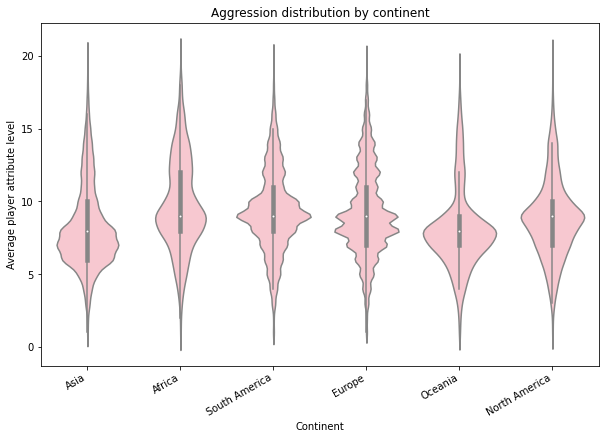

In [ ]:
f,ax = plt.subplots(figsize=(10, 7))
aggrog = sns.violinplot(x='Continent',y='Aggression',data=joined_continents_df,color='pink')

aggrog.get_figure().autofmt_xdate()
aggrog.set_xlabel('Continent')
aggrog.set_ylabel('Average player attribute level')
aggrog.set_title('Aggression distribution by continent')
plt.show()

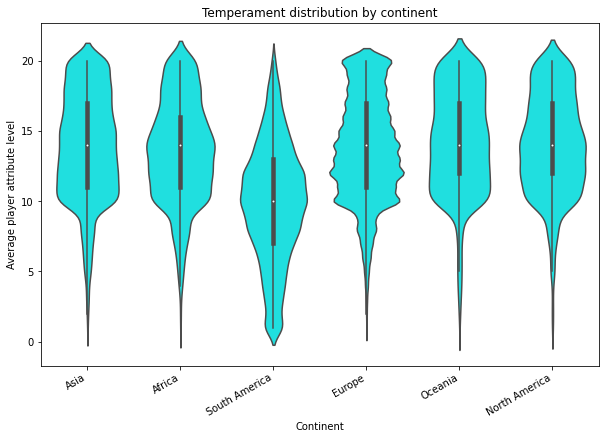

In [ ]:
f,ax = plt.subplots(figsize=(10, 7))
tempg = sns.violinplot(x='Continent',y='Temperament',data=joined_continents_df,color='cyan')

tempg.get_figure().autofmt_xdate()
tempg.set_xlabel('Continent')
tempg.set_ylabel('Average player attribute level')
tempg.set_title('Temperament distribution by continent')
plt.show()

In [ ]:
joined_continents_df = joined_continents_df.groupby(['Continent']).mean()
joined_continents_df.reset_index(inplace=True)
joined_continents_df[['Continent','Aggression','Temperament']]

,Continent,Aggression,Temperament
0,Africa,9.776446,13.565399
1,Asia,8.226851,13.890339
2,Europe,9.273729,13.745249
3,North America,8.821874,14.053478
4,Oceania,8.044630,14.293352
5,South America,9.345379,9.930274


So it seems then from both our violinplots and the simple table that the notion that South American players are more aggressive and temperamental than all other players is false, albeit still very hurtful. Specifically, when compared to all other continents, South America and its players are second in terms of average aggression (though Europe is very close behind) but is dead last in terms of temperament, which is perhaps a more surprising finding. Indeed, the temperament distribution as seen from the relevant violinplot sees South America acquire a very idiosyncratic shape in the sense that where the fourth quartile for most tempermental South American players begins, other continents mostly find their temperament median. Either way, they are not most aggressive or most temperamental on average, as judged by scouts of Football Manager.

Nevertheless, it's also important here to consider that this data is only reflective of the best of the best in Latin American football. Taking the idiosyncrasies of our dataset into consideration, we concede that it is possible the results would be different if together with the most elite South American players playing in elite domestic and foreign leagues we would also consider players in lower echelons of the game, the results could be different. Nevertheless, this doesn't necessarily imply that in truth they are more aggressive and temperamental; the burden of proof is on those who are ignorant enough to repeat the stereotype without knowing any better. 

##Are players born in earlier months of the year more represented in football?

Because the year-group cutoffs in youth sports usually come at the start of the year, the oldest (and hence) most experienced players within their year groups are by design people born at the start of the year that marks the upper limit of the year-group age cutoff. As a [great article on FiveThirtyEight](https://fivethirtyeight.com/features/why-athletes-birthdays-affect-who-goes-pro-and-who-becomes-a-star/) explains, "*those who are relatively older appear stronger, faster, etc., but they’re really just older and therefore more advanced in their maturation*" and it is these people that get selected to progress to school teams and advanced categories more and earlier than their younger peers. How pronounced is this effect in professional soccer? Let's plot the relation between ability and birth month as well as get a sense for how much each birth month is represented by players in our joined dataset.

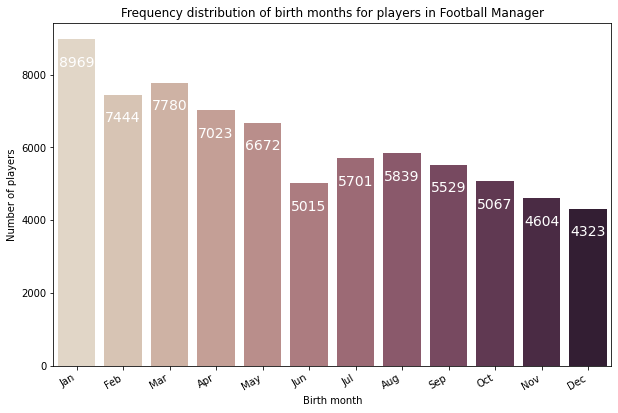

In [ ]:
months_df = cleaned_joined_df.copy()
month_mapping = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr',
                 5: 'May', 6: 'Jun', 7: 'Jul', 8:'Aug',
                 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
months_df['Birth month str'] = months_df['Birth month'].map(month_mapping)

f,ax = plt.subplots(figsize=(10, 7))
month_freqs = sns.countplot(x='Birth month str',data=months_df,
                            order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],
                            palette="ch:.25")
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}',
                (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='top', color='white', size=14)
month_freqs.get_figure().autofmt_xdate()
month_freqs.set_xlabel('Birth month')
month_freqs.set_ylabel('Number of players')
month_freqs.set_title('Frequency distribution of birth months for players in Football Manager')
plt.show()

This simple countplot demonstrates is a clear downward trend in the sense that fewer players who play professionally are born in later stages of the year. Indeed, there are 107.5% as many players born in January in our joined dataset as there are in December! It's disheartening how something as relatively arbitrary as when we as humans start our years can destroy the hopes of young children wishing to become professional football players, but in some way it's also fascinating how such decisions can have very nuanced and unexpected consequences. It would be interesting to see, however, whether this birth date advantage lasts throughout a player's career. To investigate, let's plot the distribution of player ability in our joined dataset as related to the birth month.

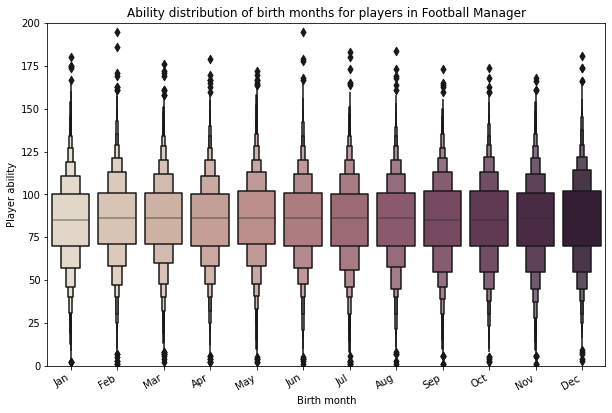

In [ ]:
month_abil = sns.boxenplot(x='Birth month str',y='Current Ability (2020)',data=months_df,
                            order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],
                            palette="ch:.25")

month_abil.get_figure().autofmt_xdate()
month_abil.set_xlabel('Birth month')
month_abil.set_ylabel('Player ability')
month_abil.set_title('Ability distribution of birth months for players in Football Manager')
month_abil.set_ylim(0,200)
plt.show()

On first glance, this does not seem to suggest that a lasting advantage is created by being born early in the year. If you make it to the professional game then, your birth date can't carry you anymore as much. This can be seen even better when we zoom in on the boxenplot to reveal that for all birth months, the range of ability for 50 percent of players born in that month (the largest box) hovers somewhere around the range of 70 to 100 and no clear correlation emerges. The verdict is then that while being born earlier in the year is advantageous when one wants to become a football player, when someone makes it as one, the benefit is no longer as clearly pronounced.

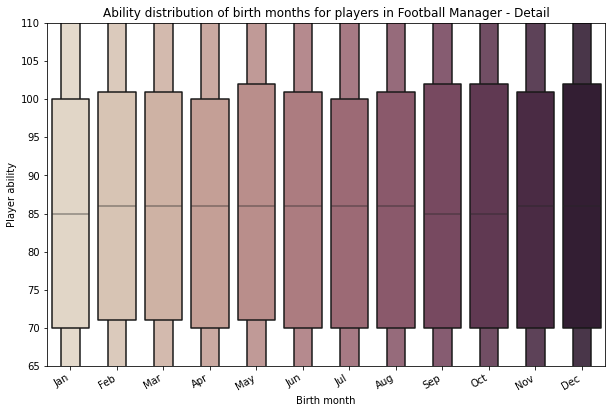

In [ ]:
month_abil_small = sns.boxenplot(x='Birth month str',y='Current Ability (2020)',data=months_df,
                            order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],
                            palette="ch:.25")

month_abil_small.get_figure().autofmt_xdate()
month_abil_small.set_xlabel('Birth month')
month_abil_small.set_ylabel('Player ability')
month_abil_small.set_title('Ability distribution of birth months for players in Football Manager - Detail')
month_abil_small.set_ylim(65,110)
plt.show()

#**Models**

##Regression Models

###Linear Regression for Predicting Overall Ability

In this section, we perform a simple Linear Regression on the joined data for the purpose of predicting the ability of the player from his attributes. We believe this to be possible as one would expect that players with higher ranking of their abilities to perform better. <br>

After selecting the attributes as features and the Current Ability (2020) column as the label, we split the data into a training and testing sets with a size of 80% and 20%, respectively.
We used a seed (random_state) of 1900 to honor the fact that Football was introduced to the Olympics in the 1900 Paris Summer Olympic Games (as the first Olympic team sport, too).

In [ ]:
ability = cleaned_joined_df['Current Ability (2020)']

to_keep = ['AerialAbility', 'CommandOfArea', 'Communication', 'Eccentricity', 'Handling', 'Kicking', 'OneOnOnes', \
           'Reflexes', 'RushingOut', 'TendencyToPunch', 'Throwing', 'Corners', 'Crossing', 'Dribbling', 'Finishing', \
           'FirstTouch', 'Freekicks', 'Heading', 'LongShots', 'Longthrows', 'Marking', 'Passing', 'PenaltyTaking', \
           'Tackling', 'Technique', 'Aggression', 'Anticipation', 'Bravery', 'Composure', 'Concentration', 'Vision', \
           'Decisions', 'Determination', 'Flair', 'Leadership', 'OffTheBall', 'Positioning', 'Teamwork', 'Workrate', \
           'Acceleration', 'Agility', 'Balance', 'Jumping', 'LeftFoot', 'NaturalFitness', 'Pace', 'RightFoot', 'Stamina', \
           'Strength', 'Consistency', 'Dirtiness', 'ImportantMatches', 'InjuryProness', 'Versatility', 'Adaptability', \
           'Ambition', 'Loyalty', 'Pressure', 'Professional', 'Sportsmanship', 'Temperament', 'Controversy']
           
features = cleaned_joined_df[to_keep]

In [ ]:
# getting the train and test data
x_train_lr, x_test_lr, y_train_lr, y_test_lr = train_test_split(features, ability, test_size = 0.2, random_state = 1900)

The following cell fits a Linear Regression model to the training data and predicts the ability score for each player in the test data. <br>

The metrics we will use to assess the performance of the Linear Regression models are R Square (R2) score and the Root Mean Squared Error (RMSE value). <br>
The R2 score measures how much variability in the dependent variable is explained by the model. The R2 score ranges from 0 to 1 and the higher the value, the better the model fits the data. <br>
While R2 is a relative measure of how good the model fits the data, the RMSE value is an absolute measure as it measures how much the predicted result deviates from the actual values, on average. <br>
We are not using an accuracy score here since it is impossible for the model to predict the exact value of the player's ability, especially since that range is theoretically continuous but in practice we have discrete values. Instead, we care about how close the predicted values are to the actual ones and we can get that from the RMSE value.




In [ ]:
lin_reg = LinearRegression().fit(x_train_lr, y_train_lr)
y_pred_lr = lin_reg.predict(x_test_lr)

score_lr = r2_score(y_test_lr.values, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test_lr.values, y_pred_lr))

print(f'The R2 score is {round(score_lr, 5)}.')
print(f'The RMSE score is {round(rmse_lr, 5)}, which is about {100*round(rmse_lr/np.mean(ability),2)}% of \
the mean ability score.')

The R2 score is 0.68396.
The RMSE score is 13.52865, which is about 16.0% of the mean ability score.


From the scores above, we can see that this model does a mediocre job in predicting the ability of a player. The R2 score tells us that about 68% of the dependent data can be explained by the model. The RMSE value is about 15% of the mean ability score, so on average the predicted value is not too far off the actual one. <br>
One reason why the model cannot do better is that there might some sort of interaction between the explanatory variables. If some of attributes are correlated to each other, then they don't provide independent information and the coefficient estimates of the model can be misleading. To get around this potential issue, we will do ridge and lasso regularized regression. The basic idea of ridge and lasso is to introduce some bias in the model for the purpose of decreasing the variance and reduicng the RMSE value. They do this by imposing constraints or regularizing the coefficients in the model. Ridge regularization keeps all predictor variables in the model and it is thus useful when a larger number of them are significant for the model. Lasso regularization, on the other hand, can shrink some coefficients to zero, removing the insignificant variables from the model.


####Ridge Regularized Linear Regression

Fit a Ridge regression model on the training set, with 𝜆 chosen by cross-validation. `RidgeCV` performs hyperparameter optimization by testing the provided values for 𝜆 through cross validation. The best 𝜆 value is stored in `ridge_select` and the corresponding Ridge model is trained. The resulting R2 score and RMSE value are pretty much the same as in the unregularized model, so Ridge Regularization doesn't improve the model.

In [ ]:
lambdas = np.linspace(1, 1000, 100)

ridgecv = RidgeCV(alphas=lambdas, scoring='neg_mean_squared_error')
ridgecv.fit(x_train_lr, y_train_lr)
ridge_select = ridgecv.alpha_

In [ ]:
ridge = Ridge(alpha=ridge_select)
ridge.fit(x_train_lr, y_train_lr)
y_pred_ridge = ridge.predict(x_test_lr)

score_ridge = r2_score(y_test_lr.values, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test_lr.values, y_pred_ridge))

print(f'The R2 score is {round(score_ridge, 5)}.')
print(f'The RMSE score is {round(rmse_ridge, 5)}.')

The R2 score is 0.68396.
The RMSE score is 13.5286.


####Lasso Regularized Linear Regression

Fit a Lasso model on the training set, with 𝜆 chosen by cross-validation. `LassoCV` automatically picks 100 𝜆 parameters to test and picks the best value. The selected value is named `lasso_select` and we train the corresponding Lasso model, and calculate the R2 score and RMSE value. We see that these scores don't show any improvement in the model.

In [ ]:
lassocv = LassoCV()
lassocv.fit(x_train_lr, y_train_lr)
lasso_select = lassocv.alpha_

In [ ]:
lasso = Lasso(alpha=lasso_select)
lasso.fit(x_train_lr, y_train_lr)
y_pred_lasso = lasso.predict(x_test_lr)

score_lasso = r2_score(y_test_lr.values, y_pred_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test_lr.values, y_pred_lasso))

print(f'The R2 score is {round(score_lasso, 5)}.')
print(f'The RMSE score is {round(rmse_lasso, 5)}.')

The R2 score is 0.68399.
The RMSE score is 13.52805.


####Linear Regression with PCA

We will also do PCA before building a Linear Regression model. PCA will get rid of any feature redundancies, retaining the signal while removing the noise. It can also be useful in showing us how the different combinations between the attributes can lead to the ability scores. <br>

We'll aim for our training features to collectively explain 90% of the variance. So if we reach 90% with X/Y features, we'll ingore the remaining Y - X features that simply aren't predictive enough to include in our training process.

In [ ]:
scaler = StandardScaler()

x_train_sc_lr = scaler.fit_transform(x_train_lr)
x_test_sc_lr = scaler.transform(x_test_lr)

pca = PCA(n_components = x_train_sc_lr.shape[1])

pca_x_train_lr = pca.fit_transform(x_train_sc_lr)

By plotting the explained variance ratios as we increase the number of features, we can identify how many features we need to use to surpass the desired 90% explained variance threshold. <br>
Then, we can create our random Linear Regression model using that smaller number of features.

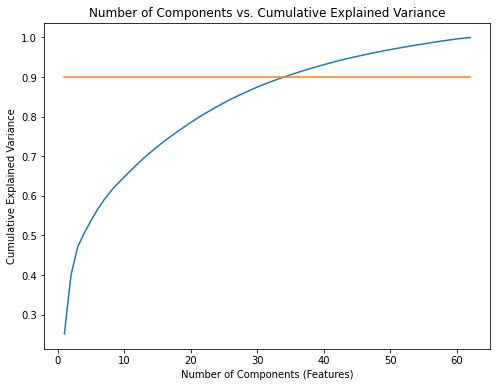

We first surpass 90% explained variance with 34 components.


In [ ]:
cum_expl_var_ratios_lr = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(cum_expl_var_ratios_lr)+1), cum_expl_var_ratios_lr)
plt.plot(np.arange(1, len(cum_expl_var_ratios_lr)+1), [0.90]*len(cum_expl_var_ratios_lr))
plt.xlabel("Number of Components (Features)")
plt.ylabel("Cumulative Explained Variance")
plt.title("Number of Components vs. Cumulative Explained Variance")
plt.show()

for i in range(len(cum_expl_var_ratios_lr)):
  if cum_expl_var_ratios_lr[i] >= 0.90:
    print("We first surpass 90% explained variance with " + str(i + 1) + " components.")
    break

In [ ]:
pca_lr = PCA(n_components = 34)

pca_x_train_sc_lr = pca_lr.fit_transform(x_train_sc_lr)

# The x train/test set with only the ideal 34 components
pca_x_test_sc_lr = pca_lr.transform(x_test_sc_lr)

In [ ]:
lin_reg_pca = LinearRegression().fit(pca_x_train_sc_lr, y_train_lr)
y_pred_pca_lr = lin_reg_pca.predict(pca_x_test_sc_lr)

score_pca_lr = r2_score(y_test_lr.values, y_pred_pca_lr)
rmse_pca_lr = np.sqrt(mean_squared_error(y_test_lr.values, y_pred_pca_lr))

print(f'The R2 score is {round(score_pca_lr, 5)}.')
print(f'The RMSE score is {round(rmse_pca_lr, 5)}.')

The R2 score is 0.66405.
The RMSE score is 13.94829.


There isn't an improvement to the model when doing PCA. We can thus conclude that it isn't collinearity between the variables or noise that hinders the performance of the Linear Regression model. <br>
It could be that the exact relationship between the attributes and ability is not exactly linear, which is why about a third of the dependent data cannot be explained by the model. The model could also struggle to give a better fit to the data because from the EDA we see that ability is normally distributed, meaning that not all ability scores are equally probable. Given that the attributes are not all distributed normally, the model might be prevented from performing well for these reasons.

###Linear Regression for Predicting Weekly Wage

Next, we will try to build a Linear Regression model for predicting the weekly wage of the player. It would make sense that the current ability of the player affects how much that player is being paid. Because the relationship between ability and wage might not necessarily be linear, we will use `PolynomialFeatures` to increase the complexity of the model by introducing higher-order terms of ability. We can then choose the best model by finding the one with the smallest MSE test value. By choosing the smallest MSE test value, we make sure that the chosen model is the best at preventing overfitting and underfitting.

In [ ]:
wage = cleaned_joined_df['Weekly Wage (EUR) (2020)']
ability = cleaned_joined_df['Current Ability (2020)']

In [ ]:
x_train_wage, x_test_wage, y_train_wage, y_test_wage = train_test_split(ability, wage, test_size = 0.2, random_state = 1900)

In [ ]:
mse_train = []
mse_test = []
arrayx_tr = x_train_wage.to_numpy()
arrayx_te = x_test_wage.to_numpy()
model = LinearRegression(fit_intercept=False, positive=True)

# generate polynomial features up to the ith degree
for i in range(21):
    x_tr = PolynomialFeatures(i).fit_transform(arrayx_tr.reshape(-1,1))
    x_te = PolynomialFeatures(i).fit_transform(arrayx_te.reshape(-1,1))
    fit2 = model.fit(x_tr, y_train_wage)
    mse_tr = mean_squared_error(y_train_wage.to_list(), fit2.predict(x_tr))
    mse_te = mean_squared_error(y_test_wage.to_list(), fit2.predict(x_te))
    mse_train.append(mse_tr)
    mse_test.append(mse_te)

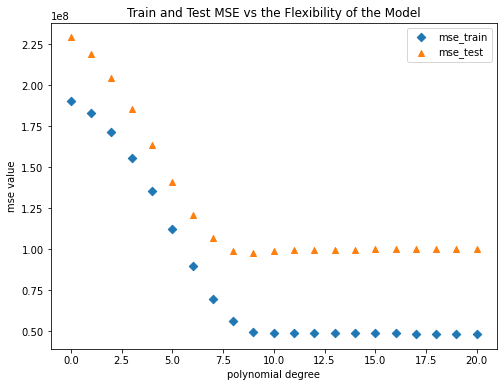

In [ ]:
min_index = mse_test.index(min(mse_test))

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(list(range(len(mse_train))), mse_train, marker="D", label='mse_train')
ax.scatter(list(range(len(mse_test))), mse_test, marker="^", label='mse_test')
ax.set_xlabel("polynomial degree")
ax.set_ylabel("mse value")
ax.set_title("Train and Test MSE vs the Flexibility of the Model")
plt.legend();

In [ ]:
print(f'Minimum test MSE occurs at polynomial degree of {min_index}.')

Minimum test MSE occurs at polynomial degree of 9.


We will now build a Linear Regression model with 9 polynomial degrees.

In [ ]:
x_tr = PolynomialFeatures(min_index).fit_transform(arrayx_tr.reshape(-1,1))
x_te = PolynomialFeatures(min_index).fit_transform(arrayx_te.reshape(-1,1))
fit_wage = model.fit(x_tr, y_train_wage)

score_wage = r2_score(y_test_wage, fit_wage.predict(x_te))
rmse_wage = np.sqrt(mean_squared_error(y_test_wage, fit_wage.predict(x_te)))

print(f'The R2 score is {round(score_wage, 5)}.')
print(f'The RMSE score is {round(rmse_wage, 5)}.')

The R2 score is 0.57336.
The RMSE score is 9881.9149.


In [ ]:
print(f'Mean weekly wage is {round(np.mean(wage))} EUR.')

Mean weekly wage is 2680 EUR.


In [ ]:
num_zero_wage = len(cleaned_joined_df[cleaned_joined_df["Weekly Wage (EUR) (2020)"] == 0])/len(cleaned_joined_df)

print(f'We can see that about {round(100*num_zero_wage)}% of all players have a weekly wage of 0 EUR. This is a lot.')

We can see that about 26% of all players have a weekly wage of 0 EUR. This is a lot.


This model for predicting the weekly wage is not good. The RMSE value is much bigger than the mean weekly wage, suggesting that on average, the model's prediction deviates a lot from the actual wage. The R2 score suggests that almost half of the data cannot be explained by the independent variable, which all depend on the player's ability. One reason for why this could be so is that about 26% of the players have a reported weekly wage of 0 EUR, so not all wages have equal probability in our dataset. The model can thus struggle to find a good fit. Another reason could be that the ability alone is not enough to predict the player's wage as the wage can also depend on whether the player is currently playing for a club or not and other factors.

###Linear Regression for Predicting Player's Value

From the previous section, we can see that we can't really predict a player's wage based on their ability, but maybe we can predict someone's value based on how good they are. One would expect that the current ability of the player predicts their worth. We repeat the same procedure as above when building a Linear Regression model and generating polynomial features.

In [ ]:
value = cleaned_joined_df['Value (EUR) (2020)']
ability = cleaned_joined_df['Current Ability (2020)']

In [ ]:
x_train_val, x_test_val, y_train_val, y_test_val = train_test_split(ability, value, test_size = 0.2, random_state = 1900)

In [ ]:
mse_train = []
mse_test = []
arrayx_tr = x_train_val.to_numpy()
arrayx_te = x_test_val.to_numpy()
model = LinearRegression(fit_intercept = False, positive=True)
for i in range(21):
    x_tr = PolynomialFeatures(i).fit_transform(arrayx_tr.reshape(-1,1))
    x_te = PolynomialFeatures(i).fit_transform(arrayx_te.reshape(-1,1))
    fit2 = model.fit(x_tr, y_train_val)
    mse_tr = mean_squared_error(y_train_val.to_list(), fit2.predict(x_tr))
    mse_te = mean_squared_error(y_test_val.to_list(), fit2.predict(x_te))
    mse_train.append(mse_tr)
    mse_test.append(mse_te)

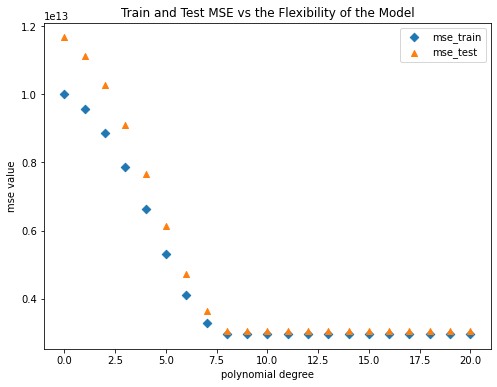

In [ ]:
min_index = mse_test.index(min(mse_test))

# plot the MSE values to find the lowest test error
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(list(range(len(mse_train))), mse_train, marker="D", label='mse_train')
ax.scatter(list(range(len(mse_test))), mse_test, marker="^", label='mse_test')
ax.set_xlabel("polynomial degree")
ax.set_ylabel("mse value")
ax.set_title("Train and Test MSE vs the Flexibility of the Model")
plt.legend();

In [ ]:
print(f'Minimum test MSE occurs at polynomial degree of {min_index}.')

Minimum test MSE occurs at polynomial degree of 19.


In [ ]:
x_tr = PolynomialFeatures(min_index).fit_transform(arrayx_tr.reshape(-1,1))
x_te = PolynomialFeatures(min_index).fit_transform(arrayx_te.reshape(-1,1))
fit_val = model.fit(x_tr, y_train_val.values.tolist())

score_val = r2_score(y_test_val.values.tolist(), fit_val.predict(x_te))
rmse_val = np.sqrt(mean_squared_error(y_test_val.values.tolist(), fit_val.predict(x_te)))

print(f'The R2 score is {round(score_val, 5)}.')
print(f'The RMSE score is {round(rmse_val)}.')

The R2 score is 0.73983.
The RMSE score is 1742405.


In [ ]:
print(f'The mean value in EUR of the players is {round(np.mean(value))} EUR.')

The mean value in EUR of the players is 596237 EUR.


In [ ]:
num_zero_val = len(cleaned_joined_df[cleaned_joined_df["Value (EUR) (2020)"] == 0])/len(cleaned_joined_df)

print(f'We can see that about {round(100*num_zero_val)}% of all players have a value of 0 EUR. This is a lot.')

We can see that about 26% of all players have a value of 0 EUR. This is a lot.


This model doesn't do a great job at predicting the player's worth either. The RMSE value is way to high even though the R2 score is not that bad. It is just very curious why the RMSE value is that large. Similar to the previous model, a huge fraction of the players have a value of 0 EUR, which could affect the goodness of fit of the model. The exact fraction is not the same for the wage and value columns, suggesting that not all players with wage of 0 EUR have a value of 0 EUR and vice versa. Nonetheless, it is true that for the most part, the statement above applies. Hence, there is a common factor that influence the wage and value of a player to be 0 EUR, but we don't know why this is so.

##Random Forest Classifiers

###Binary Classifier (International Caps)

####Defining Features and Target Labels

Before we can do any training and predicting, we'll need to clearly define which variables we'll use as features to train our model and what we want our target label to be, what we want our model to predict.

As for the label, we already have a binary label for international caps called "IntCaps Binary Label" (which is 0 for players with no international caps and 1 for players with at least one international cap). Indeed, there is no bigger joy for a professional footballer than to earn an international cap, i.e. for him to have a chance to repesent his country in an official match. But with this joy comes responsibility and only the very best of the best are ever called up to play for their country. With this binary label, we set out to quantify just how much a player's ability predicts the presence of international caps for said player.

As for the features, we'll ignore the columns corresponding to the target lables (both for international caps and current ability), the columns corresponding to 2020-specific data (as the international caps data was 2017-specific, so we're trying to predict 2017 international cap count from 2017 stats only), a few other columns that shouldn't have any predictive power (like name), and some redundant columns (like age and born since we already have birth year, month, and day as well as position as we already have numeric scores for a player's skill at each of the position groups).

In [ ]:
label = cleaned_joined_df["IntCaps Binary Label"]

features = cleaned_joined_df.drop(columns = ["IntCaps Binary Label", "Current Ability (2020) Multiclass Label",
                                             "Potential Ability (2020)", "Current Ability (2020)", "Weekly Wage (EUR) (2020)",
                                             "Value (EUR) (2020)", "Position (2020)", "Preferred Foot (2020)", "Division (2020)",
                                             "Country", "Name", "Club (2020)", "IntCaps", "IntGoals", "Born", "Age", "Position"])

####Splitting Data Into Test & Train Sets

We need to split our data into a training set on which we'll train our random forest classifiers and a testing set on which we'll test our trained model.

We'll use a common 80/20 train-test split, meaning we'll train on 80% of the data and withhold the remaining 20% for testing purposes.

In keeping with the Olympian spirit, we keep our seed at 1900.

In [ ]:
x_train_rf, x_test_rf, y_train_rf, y_test_rf = train_test_split(features, label, test_size = 0.2, random_state = 1900)

####Initial PCA

We'll perform some Principal Component Analysis, which will help inform us about how much predictive power the various features have in regards to whether a player has any international caps or not.

Hopefully, this will allow us to ingore a sizable number of features with little predictive power in our random forest classifiers.

We'll aim for our training features to collectively explain 90% of the variance. So if we reach 90% with X/Y features, we'll ingore the remaining Y - X features that simply aren't predictive enough to include in our training process.

In [ ]:
scaler = StandardScaler()

x_train_sc_rf = scaler.fit_transform(x_train_rf)

x_test_sc_rf = scaler.transform(x_test_rf)

pca = PCA(n_components = x_train_sc_rf.shape[1])

pca_x_train_rf = pca.fit_transform(x_train_sc_rf)

Now that we have our PCA model, we'll want to find the explained variance ratios of the model as we increase the number of features used (always choosing the next most explanatory feature as the one to add next).

We'll plot this relationship to see just how many variables (features) we need to surpass our desired 90% explained variance threshold.

Then, we can create our random forest classifiers using that smaller number of features (which should speed up computation considerably).

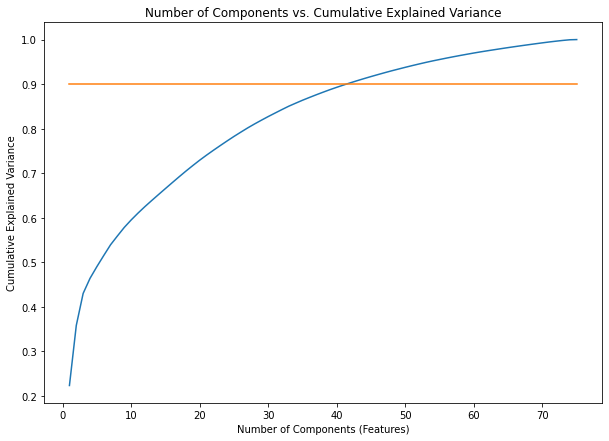


We first surpass 90% explained variance with 42 components.


In [ ]:
cum_expl_var_ratios_rf = np.cumsum(pca.explained_variance_ratio_)

plt.plot(np.arange(1, 76), cum_expl_var_ratios_rf)
plt.plot(np.arange(1, 76), [0.90]*75)
plt.xlabel("Number of Components (Features)")
plt.ylabel("Cumulative Explained Variance")
plt.title("Number of Components vs. Cumulative Explained Variance")
plt.show()

print("")

for i in range(len(cum_expl_var_ratios_rf)):
  if cum_expl_var_ratios_rf[i] >= 0.90:
    print("We first surpass 90% explained variance with " + str(i + 1) + " components.")
    break

####Random Forest Classifier With "Ideal" PCA

Now that we know we can achieve over 90% explained variance with only 42 components (as opposed to the total 75 features we considered using), we can proceed to construct our random forest classifiers using this much smaller set of components.

In [ ]:
ideal_pca_rf = PCA(n_components = 42)

ideal_pca_rf.fit_transform(x_train_sc_rf)

# The x train/test set with only the ideal 42 components
ideal_pca_x_train_sc_rf = ideal_pca_rf.transform(x_train_sc_rf)
ideal_pca_x_test_sc_rf = ideal_pca_rf.transform(x_test_sc_rf)

With just these 42 components, let's create our binary random forest classifier.

Once it's created, we'll use our random forest classifier to predict the values of our x test set and then compare it to the actual values (what it should've predicted) in the y test set.

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators = 3, max_depth = 2)

rf_classifier.fit(ideal_pca_x_train_sc_rf, y_train_rf)

rf_preds = rf_classifier.predict(ideal_pca_x_test_sc_rf)

rf_accuracy = metrics.accuracy_score(y_test_rf, rf_preds)

print("Our Random Forest Binary Classifier predicts with " + str(round(rf_accuracy * 100, 2)) + "% accuracy whether a player has any international caps")

Our Random Forest Binary Classifier predicts with 91.71% accuracy whether a player has any international caps


####Hyperparameter Tuning

So with our default random forest with 3 trees (n_estimators) and a max depth of 2, we get a pretty good initial accuracy.

But would tweaking either of those parameters result in an even better testing accuracy?

Let's see how changing the number of trees (n_estimators) and max depth affects our testing accuracy and choose whichever combination results in the highest accuracy.

In [ ]:
combos_dict = {}

n_est_lst = []
m_depth_lst = []
acc_lst = []

for n_est in range(1, 102, 10):
  for m_depth in range(1, 12, 2):
    rf_classifier = RandomForestClassifier(n_estimators = n_est, max_depth = m_depth)
    rf_classifier.fit(ideal_pca_x_train_sc_rf, y_train_rf)
    rf_preds = rf_classifier.predict(ideal_pca_x_test_sc_rf)
    rf_accuracy = metrics.accuracy_score(y_test_rf, rf_preds)
    combos_dict[(n_est, m_depth)] = rf_accuracy
    n_est_lst.append(n_est)
    m_depth_lst.append(m_depth)
    acc_lst.append(rf_accuracy)

best_combo = None
max_acc = 0

for combo in combos_dict.keys():
  if combos_dict[combo] > max_acc:
    best_combo = combo
    max_acc = combos_dict[combo]

print("We get the highest testing accuracy (" + str(round(max_acc * 100, 2)) + "%) with " + str(best_combo[0]) + " trees and with a max depth of " + str(best_combo[1]))

We get the highest testing accuracy (92.78%) with 51 trees and with a max depth of 11


Let's visualize the testing accuracies we receive when creating Random Forest Classifiers using these different hyperparameters.

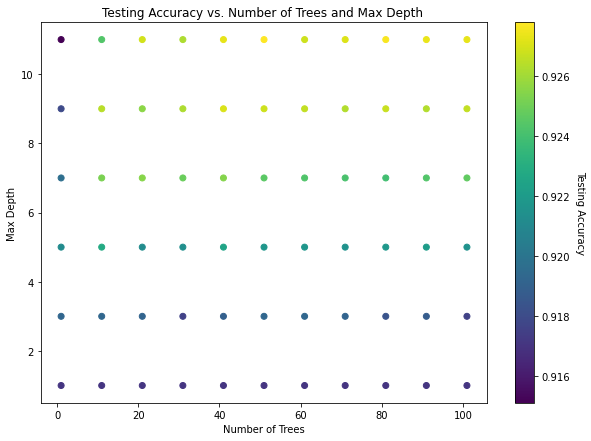

In [ ]:
fig, ax = plt.subplots();
d_points = ax.scatter(n_est_lst, m_depth_lst, c = acc_lst, cmap = sns.color_palette("viridis", as_cmap = True));
cbar = fig.colorbar(d_points);
ax.set_xlabel("Number of Trees");
ax.set_ylabel("Max Depth");
ax.set_title("Testing Accuracy vs. Number of Trees and Max Depth ");
cbar.set_label("Testing Accuracy", rotation = 270, labelpad = 15);

As we can see in the above plot, increasing the maximum depth improves our testing accuracy. Increasing the number of trees in the forest also increases the testing accuracy generally but with less consistency than the maximum depth.

This would suggest that if we were to increase the maximum depth (and potentially the number of trees) further, we might be able to achieve even greater testing accuracies. However, that would further increase the model's computational complexity and drive up its training time. I had tried to test with combos of number of trees up to 1000 and maximum depths up to 20, but it was taking an absurd amount of time. It's all about tradeoffs, and I personally don't think the boost in accuracy is worth it.

Now that we've tested a wide variety of combinations of number of estimators (trees) and max depths, let's create our final Random Forest Classifier using the best combination we found in the above tuning process.

And with this final Random Forest Classifier, let's calculate its accuracy.

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators = best_combo[0], max_depth = best_combo[1])

rf_classifier.fit(ideal_pca_x_train_sc_rf, y_train_rf)

rf_preds = rf_classifier.predict(ideal_pca_x_test_sc_rf)

rf_accuracy = metrics.accuracy_score(y_test_rf, rf_preds)

print("Our hyper-tuned Random Forest Binary Classifier predicts with " + str(round(rf_accuracy * 100, 2)) + "% accuracy whether a player has any international caps")

Our hyper-tuned Random Forest Binary Classifier predicts with 92.72% accuracy whether a player has any international caps


This hyper-tuned Random Forest Classifier has an accuracy that is about 1% higher than our initial Random Forest Classifier (before any hyperparameter tuning).

While that's not a huge increase, it is a meaningful increase as we were already at ~92% accuracy with our initial Random Forest Classifier. So if we were wrong about 8% of the time with the initial model and now are wrong about 7% of the time with this new model (with an accuracy of ~93%), our error rate dropped by an 8th (12.5%) due to our hyperparameter tuning process.

Presumably, if we wanted to get a higher accuracy, we could redo our PCA process and select a higher number of components that reached a higher explained variance threshold like 95% instead of our current 90% goal.

However, like with anything, including more features comes with a tradeoff. The computation time would increase if we included extra features. So maybe we could increase our accuracy by another % or two, but it would take longer to train our model.

I think we've found a nice middleground. Our ideal Random Forest Classifier already took 40s to train and make predictions (which is totally fine on its own), and the hyperparameter tuning process took 12+m. That's getting a bit long. If we included more features to try and get a higher accuracy, that tuning process would then take an annoyingly long amount of time. I could graduate, get married, have 3 children, see my kids off to college, retire, and die of old age before it finished, and I'd prefer not to.

###Multiclass Classifier (Current Ability - 2020)

####Defining Features and Target Labels

Like we did with the binary case, we'll first need to define which variables (columns) we'll use as training features and which we'll use as our target label (what we want the model to predict).

As for the label, we already have our desired multiclass label for 2020 current ability called "Current Ability (2020) Multiclass Label" (which is 1 for any player in the top 1/4 of potential current ability scores, 2 for any player in the next highest 1/4, 3 for any player in the second lowest 1/4, and 4 for any player in the lowest 1/4).

As for the features, we'll use the same features as with the random forest binary classifier above (as we were only using 2017 features then and only want to use 2017 features now so as to predict future 2020 performance). The same things that were relevant/irrelevant have not changed. The main difference is that we're predicting a different value.

In [ ]:
label = cleaned_joined_df["Current Ability (2020) Multiclass Label"]

features = cleaned_joined_df.drop(columns = ["IntCaps Binary Label", "Current Ability (2020) Multiclass Label",
                                             "Potential Ability (2020)", "Current Ability (2020)", "Weekly Wage (EUR) (2020)",
                                             "Value (EUR) (2020)", "Position (2020)", "Preferred Foot (2020)", "Division (2020)",
                                             "Country", "Name", "Club (2020)", "IntCaps", "IntGoals", "Born", "Age", "Position"])

#### Splitting Data Into Test & Train Sets

We'll again need to split this data into a training set on which we'll train our random forest multiclass classifier and a testing set on which we'll test said classifier's performance.

We'll use a common 80/20 train-test split, so we'll train on 80% of the data and withhold the remainign 20% for testing purposes.

Like before, we'll use a seed (random_state) for reproducibility purposes. There's no reason we can't use 1900 again, so let's reuse it.

In [ ]:
x_train_rf, x_test_rf, y_train_rf, y_test_rf = train_test_split(features, label, test_size = 0.2, random_state = 1900)

#### Initial PCA

We'll now perform some Principal Component Analysis to help us see how much predictive power the various features bring to the table when predicting 2020 current ability.

Hopefully this will prove as useful as it did in the binary case with allowing us to ignore a large chunk of the features that have little predictive power in our coming classifiers.

Like before, we'll aim for our training features to collectively explain at least 90% of the overall variance. So if we reach 90% with X/Y features, we'll ingore the remaining Y - X features that simply aren't predictive enough to include in our training process.

In [ ]:
scaler = StandardScaler()

x_train_sc_rf = scaler.fit_transform(x_train_rf)

x_test_sc_rf = scaler.transform(x_test_rf)

pca = PCA(n_components = x_train_sc_rf.shape[1])

pca_x_train_rf = pca.fit_transform(x_train_sc_rf)

With our newly constructed PCA model, we'll want to find the explained variance ratios of the model as we increase the number of features used (always choosing the next most explanatory feature as the one to add next).

Like before, we'll plot this relationship to see just how many variables (features) we need to surpass our desired 90% explained variance threshold.

Then, we can create our random forest multiclass classifiers using that (hopefully) smaller number of features, which will (hopefully) considerably speed up computation times.

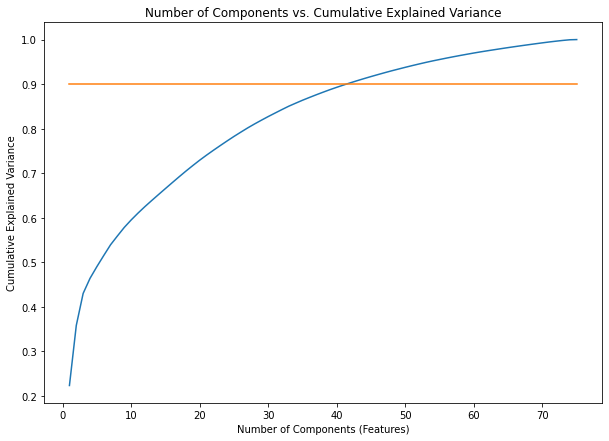


We first surpass 90% explained variance with 42 components.


In [ ]:
cum_expl_var_ratios_rf = np.cumsum(pca.explained_variance_ratio_)

plt.plot(np.arange(1, 76), cum_expl_var_ratios_rf)
plt.plot(np.arange(1, 76), [0.90]*75)
plt.xlabel("Number of Components (Features)")
plt.ylabel("Cumulative Explained Variance")
plt.title("Number of Components vs. Cumulative Explained Variance")
plt.show()

print("")

for i in range(len(cum_expl_var_ratios_rf)):
  if cum_expl_var_ratios_rf[i] >= 0.90:
    print("We first surpass 90% explained variance with " + str(i + 1) + " components.")
    break

#### Random Forest Classifier With "Ideal" PCA

We again see that we reach 90% explained variance with 42 components. Since we used the same exact features, this shouldn't be surprising. 

(This repetitive initial classifier set-up process for the multiclass classifier is included so that if you simply want to run the frandom forest multiclass classifier cells, you do not have to have previously ran the random forest binary classifier cells).

But now that we know we only need those 42 components to reach 90% explained variance (out of the total 75 features we initially considered using), we can proceed and make our random forest multiclass classifiers using this much smaller set of components.

In [ ]:
ideal_pca_rf = PCA(n_components = 42)

ideal_pca_rf.fit_transform(x_train_sc_rf)

# The x train/test set with only the ideal 42 components
ideal_pca_x_train_sc_rf = ideal_pca_rf.transform(x_train_sc_rf)
ideal_pca_x_test_sc_rf = ideal_pca_rf.transform(x_test_sc_rf)

With only these 42 components, let's create our random forest multiclass classifier.

After it's created, we'll use our random forest classifier to predict the values of our x test set and then compare it to the actual values (what it should've predicted) in the y test set.

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators = 3, max_depth = 2)

rf_classifier.fit(ideal_pca_x_train_sc_rf, y_train_rf)

rf_preds = rf_classifier.predict(ideal_pca_x_test_sc_rf)

rf_accuracy = metrics.accuracy_score(y_test_rf, rf_preds)

print("Our Random Forest Binary Classifier predicts with " + str(round(rf_accuracy * 100, 2)) + "% accuracy the range in which a player's 2020 current ability falls")

Our Random Forest Binary Classifier predicts with 66.47% accuracy the range in which a player's 2020 current ability falls


**Correction: The above should say "Multiclass" not "Binary". The accuracy is correctly referring to the accuracy of the multiclass classifier, it's just the text that's inc

#### Hyperparameter Tuning

With our default random forest with 3 trees (n_estimators) and a max depth of 2, we get a decent initial accuracy.

Let's try and tweak those two parameters so that we get a better testing accuracy.

We'll see how changing the number of trees (n_estimators) and max depth affects our testing accuracy and we'll choose whichever combination affords us the highest accuracy.

In [ ]:
combos_dict = {}

n_est_lst = []
m_depth_lst = []
acc_lst = []

for n_est in range(1, 102, 10):
  for m_depth in range(1, 12, 2):
    rf_classifier = RandomForestClassifier(n_estimators = n_est, max_depth = m_depth)
    rf_classifier.fit(ideal_pca_x_train_sc_rf, y_train_rf)
    rf_preds = rf_classifier.predict(ideal_pca_x_test_sc_rf)
    rf_accuracy = metrics.accuracy_score(y_test_rf, rf_preds)
    combos_dict[(n_est, m_depth)] = rf_accuracy
    n_est_lst.append(n_est)
    m_depth_lst.append(m_depth)
    acc_lst.append(rf_accuracy)

best_combo = None
max_acc = 0

for combo in combos_dict.keys():
  if combos_dict[combo] > max_acc:
    best_combo = combo
    max_acc = combos_dict[combo]

print("We get the highest testing accuracy (" + str(round(max_acc * 100, 2)) + "%) with " + str(best_combo[0]) + " trees and with a max depth of " + str(best_combo[1]))

We get the highest testing accuracy (78.23%) with 51 trees and with a max depth of 11


Let's visualize the testing accuracies we receive when creating Random Forest Classifiers using these different hyperparameters.

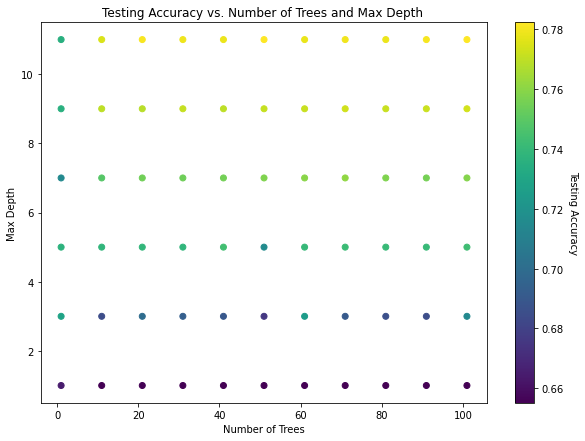

In [ ]:
fig, ax = plt.subplots();
d_points = ax.scatter(n_est_lst, m_depth_lst, c = acc_lst, cmap = sns.color_palette("viridis", as_cmap = True));
cbar = fig.colorbar(d_points);
ax.set_xlabel("Number of Trees");
ax.set_ylabel("Max Depth");
ax.set_title("Testing Accuracy vs. Number of Trees and Max Depth ");
cbar.set_label("Testing Accuracy", rotation = 270, labelpad = 15);

Just like with the binary case, we can see that generally more depth means a higher accuracy and so does more trees to an extent (more trees stop helping with accuracy improvements much quicker with this multiclass case than in the binary case).

Our accuracy has risen about 12% from ~66% to ~78%. That's a nice boost from the hyperparameter tuning process.

Now this accuracy isn't nearly as good as we were able to achieve with our binary model predicting whether a player had any international caps or not, but that is probably to be expected.

Even from a personal human guessing point of view, it would be much easier to guess from a player's 2017 stats whether or not they have ever played on the international stage before. If someone's really good for their country, then probably. If they aren't, then probably not. But it's much harder to predict a player's ability in 2020 based on their 2017 performance. Future injuries are unforseeable, and it's hard to tell whether a player will improve or fall off based on their current status. It's not like we know the inner details of the player's mental state and their drive. Predicting the future is obviously harder than predicting the past, which explains why our binary international caps classifier (involving whether a player had previously played on the international stage) would likely inherently perform better than our multiclass 2020 ability classifier (involving future performance).

But predicting the future with ~78% accuracy isn't that bad either. Sure, it's wrong a bit more than 1/5 times. But to know the future with almost ~80% accuracy is pretty cool.

That being said, this isn't the most useful prediction as we're dividing the players into 4 huge buckets of ability. It might not be that hard for real human scouts and recruiters to make the same predictions. It'd be like predicting which kids would get an A/B vs. C/D vs. F in a class based on their grades in the prerequisite classes. Those buckets are much more easily identifiable than smaller buckets like A+ vs. A vs. A-.

However, the smaller we make these buckets, the less data we have on each bucket we want to predict. So there's an inherent tradeoff there. But that could be a potential next step to explore if we could find more player data.

###Multiclass Classifier (Position)

We can also use a similar random forest multiclass classifier to try and predict what position group a player belongs to based on their 2017 stats.

We've simplified beyond individual positions into position groups so that we have a more manageable number of buckets (one for Attackers, one for Defenders, one for Midfielders, and one for Goalkeepers).

####Defining Features and Target Labels

Same deal as before. We need to define which variables we'll use as training features and which we'll use as our target label.

In this case, our label will be "Position" (A for Attacker, M for Midfielder, D for Defender, and G for goalkeeper), which reflects a player's position from our 2017 data.

Our features will be the same as before, as we still want to make predictions using our 2017-related columns and weren't using position as an indicator of ability or international caps to begin with.

In [ ]:
label = cleaned_joined_df["Position"]

features = cleaned_joined_df.drop(columns = ["IntCaps Binary Label", "Current Ability (2020) Multiclass Label",
                                             "Potential Ability (2020)", "Current Ability (2020)", "Weekly Wage (EUR) (2020)",
                                             "Value (EUR) (2020)", "Position (2020)", "Preferred Foot (2020)", "Division (2020)",
                                             "Country", "Name", "Club (2020)", "IntCaps", "IntGoals", "Born", "Age", "Position"])

####Splitting Data Into Test & Train Sets

Just like before, we'll split our data into a training set on which we'll train our classifier(s) and a testing set on which we'll test the performance of our classifier(s).

We'll use the same 80/20 train-test split as before for consistency. 80% of the data will fall into the training set and the remaining 20% will be withheld for testing purposes.

We'll also use the same seed (random_state) as before for reproducibility purposes. That was 1900, so we'll use 1900 here.

In [ ]:
x_train_rf, x_test_rf, y_train_rf, y_test_rf = train_test_split(features, label, test_size = 0.2, random_state = 1900)

####Initial PCA

The time has come to perform some fan-favorite Principal Component Analysis to see how much predictive power the various features hold in predicting a player's position.

As before, this should allow us to ignore a lot of features that lack predictive power when making our classifier(s).

And since we're using the same features and data, this should lead to the same results as before, but we'll check to be sure.

We'll still aim for our training features to collectively explain at least 90% of the overall variance. So if we reach 90% variance with X/Y features, we'll ignore the remaining Y - X features that lack sufficient predictive power to be useful in our training process.

In [ ]:
scaler = StandardScaler()

x_train_sc_rf = scaler.fit_transform(x_train_rf)

x_test_sc_rf = scaler.transform(x_test_rf)

pca = PCA(n_components = x_train_sc_rf.shape[1])

pca_x_train_rf = pca.fit_transform(x_train_sc_rf)

Now that we have our PCA model, we can find the explained variance ratios of the model as we include more and more features (always choosing the next most explanatory feature as the one to add next).

We'll plot this relationship to see visually how many variables (features) we'll need to get over that 90% explained variance threshold we've imposed.

Then, we'll create our random forest multiclass classifiers using our (hopefully) smaller set of features. That should lead to considerably faster computation times.

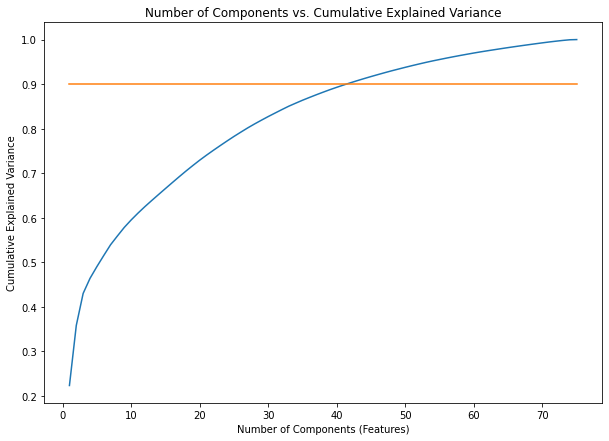


We first surpass 90% explained variance with 42 components.


In [ ]:
cum_expl_var_ratios_rf = np.cumsum(pca.explained_variance_ratio_)

plt.plot(np.arange(1, 76), cum_expl_var_ratios_rf)
plt.plot(np.arange(1, 76), [0.90]*75)
plt.xlabel("Number of Components (Features)")
plt.ylabel("Cumulative Explained Variance")
plt.title("Number of Components vs. Cumulative Explained Variance")
plt.show()

print("")

for i in range(len(cum_expl_var_ratios_rf)):
  if cum_expl_var_ratios_rf[i] >= 0.90:
    print("We first surpass 90% explained variance with " + str(i + 1) + " components.")
    break

####Random Forest Classifier With "Ideal" PCA

Unsurprisingly, we still get to 90% explained variance with at least 42 components. This is highly repetitive of the previous random forest classifiers, but it's repeated here so that any user can run any of one the classifiers by themselves without having to have run parts of another classifier's section.

Now that we know we only need 42 components (compared to our initial 75 features) to reach 90% explained variance, we can make our random forest multiclass classifiers using this smaller set of components.

In [ ]:
ideal_pca_rf = PCA(n_components = 42)

ideal_pca_rf.fit_transform(x_train_sc_rf)

# The x train/test set with only the ideal 42 components
ideal_pca_x_train_sc_rf = ideal_pca_rf.transform(x_train_sc_rf)
ideal_pca_x_test_sc_rf = ideal_pca_rf.transform(x_test_sc_rf)

With only these 42 components remaining, let's create our random forest multiclass classifier.

Once it's created, we can it to predict the values of our x test set and then compare it to the actual values (what it should've predicted) in the y test set.

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators = 3, max_depth = 2)

rf_classifier.fit(ideal_pca_x_train_sc_rf, y_train_rf)

rf_preds = rf_classifier.predict(ideal_pca_x_test_sc_rf)

rf_accuracy = metrics.accuracy_score(y_test_rf, rf_preds)

print("Our Random Forest Binary Classifier predicts with " + str(round(rf_accuracy * 100, 2)) + "% accuracy the range in which a player's 2020 current ability falls")

Our Random Forest Binary Classifier predicts with 76.27% accuracy the range in which a player's 2020 current ability falls


**Correction: The above text output should refer to the accuracy for predicting player position, not player ability. The accuracy value is correct (it is the accuracy for predicting player position), the text explaining what it's referring to is a typo however.

**Correction: It should also say "Multiclass" not "Binary". Maybe improving my reading comprehension skills is a good potential next step.

####Hyperparameter Tuning

Our default random forest with 3 trees (n_estimators) and a max depth of 2 gave us a pretty decent initial accuracy.

Like before, let's try and tweak these hyperparameters to try and get a better testing accuracy.

We'll see our changing the number of trees (n_estimators) and max depth affects our testing accuracy and we'll choose whichever combination results in the best accuracy.

In [ ]:
combos_dict = {}

n_est_lst = []
m_depth_lst = []
acc_lst = []

for n_est in range(1, 102, 10):
  for m_depth in range(1, 12, 2):
    rf_classifier = RandomForestClassifier(n_estimators = n_est, max_depth = m_depth)
    rf_classifier.fit(ideal_pca_x_train_sc_rf, y_train_rf)
    rf_preds = rf_classifier.predict(ideal_pca_x_test_sc_rf)
    rf_accuracy = metrics.accuracy_score(y_test_rf, rf_preds)
    combos_dict[(n_est, m_depth)] = rf_accuracy
    n_est_lst.append(n_est)
    m_depth_lst.append(m_depth)
    acc_lst.append(rf_accuracy)

best_combo = None
max_acc = 0

for combo in combos_dict.keys():
  if combos_dict[combo] > max_acc:
    best_combo = combo
    max_acc = combos_dict[combo]

print("We get the highest testing accuracy (" + str(round(max_acc * 100, 2)) + "%) with " + str(best_combo[0]) + " trees and with a max depth of " + str(best_combo[1]))

We get the highest testing accuracy (90.42%) with 81 trees and with a max depth of 11


Let's visualize the testing accuracies we receive when creating Random Forest Classifiers using these different hyperparameters.

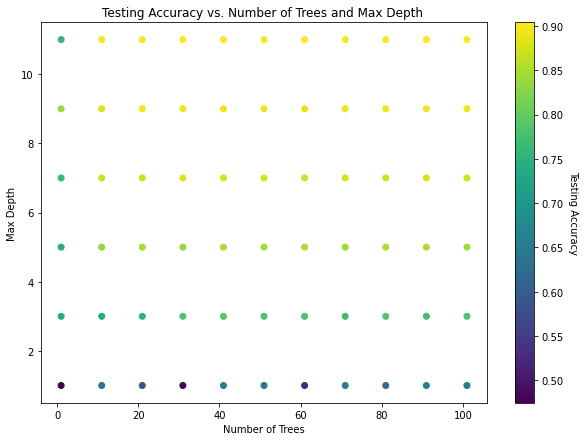

In [ ]:
fig, ax = plt.subplots();
d_points = ax.scatter(n_est_lst, m_depth_lst, c = acc_lst, cmap = sns.color_palette("viridis", as_cmap = True));
cbar = fig.colorbar(d_points);
ax.set_xlabel("Number of Trees");
ax.set_ylabel("Max Depth");
ax.set_title("Testing Accuracy vs. Number of Trees and Max Depth ");
cbar.set_label("Testing Accuracy", rotation = 270, labelpad = 15);

Like with both the international caps and current ability classifiers, we see that generally more trees and more depth increase the accuracy (to an extent).

However, unlike with the current ability multiclass classifier, we see a much larger boost to our testing accuracy with this hyperparameter tuning.

We jumped from about 76% accuracy with our initial model to just over 90% accuracy after hyperparameter tuning.

That's pretty good. Not perfect, but pretty good.

I'm assuming that we were able to perform much better with these position predictions than with our 2020 ability predictions as we're (like our better international caps predictions) not predicting the future. We're predicing a player's position based on their current stats. And it's also probably easier to predict position than future skill because different positions will specialize in certain skills, which will then serve as huge indicators of which position they play. However, there still might be some confusion (and hence why our classifier was wrong almost 10% of the time) because certain positions (like Midfielders maybe) don't have as much hyper-specific specialization as other positions (like Attackers specializing in shooting or kicking or something specific to their job).

But predicting position group with over 90% accuracy is solid. Presumably if we were to get more data, we could see even higher prediction accuracies.

##Feedforward Neural Net Classifiers

As we've mentioned for player abilities, to know the future 80% of the time is indeed pretty cool. Nevertheless, CIS 545 has left us with one last ace up our sleeves - a chance to try and be even more prophetic by leveraging compositional features. In this vein, we will define and optimize a Feedforward Neural Network Classifier, which hopefully will increase our predictive power with its intrinsic ability to identify more delicate and complex interrelations between player attributes that are hidden deep within its inner layers.

With this classifier, our goal remains the same, that is to correctly predict whether a player has played in an international match as well as to try and place him in the correct current ability bucket based on his attributes as they were listed in Football Manager 2017. As we've seen already, the latter classification is rather tricky - and indeed there is a reason why the best football scouts get so much money. So, to catch our breath a little after completing the more Herculean effort of placing players into ability buckets, we'll train our model one last time to determine how predictive player attributes are of their position (a sanity check of sorts) and compare the performance of our Neural Network to a Random forest.

A note on hyperparameter tuning: empirically, training our network has proven to take some time and to fully test all the different hyperparameters and their different combinations would be rather computationally unfeasible. First we have the pressure from the simple fact that training takes time and second we are also faced by the exponential number of different permutations of different parameters that can vary and in the end, testing every combination even when we step e.g. by 100 neurons per layer becomes virtually impossible. For the purposes of this project, we have set out to find a balance where we finetune as finely as possible but also with the clock in mind. The specifications for our hyperparameter optimization are as follows: we do vary the number of hidden layers and the number of neurons within them, but to prevent exponential buildup, we constrain each inner layer to have the same activation function and the same number of neurons. There are just too many permutations to consider otherwise! Outside of changing the activation function and the number of neurons as well as the depth of the FNN, we also try out three different learning rates scaled by a factor of 10 for each classifier. It is not perfect, but common sense (in terms of computational feasibility in this context, but also just in general) never is.

###Building the Framework for a Feedforward Neural Network Classifier

While the morphology of our individual neural networks will ultimately be different for the three different classifications we want to make, the procedure used to train each of these classifiers will be largely the same. In this section, we define a process that takes the skeleton of an FNN and uses the input features and labels to train it. Later on, we will utilize this common framework to implement the three classifiers more concretely. We start building this framework through constructing multiple helpers that are consequently used in conjunction with the train_network() and test_network() functions, which serve as culminations for the construction of this common bedrock for our classifiers.

The first helper serves create a context, loss criterion, accuracy metric, and trainer for the FNN model which it also initializes.


In [ ]:
def create_ctx_criterion_metric_trainer(net, optimizer, learning_rate):
  ctx =  mx.gpu() if mx.context.num_gpus() else mx.cpu() # use available GPUs or resort to CPUs
  net.initialize(mx.init.Xavier(), ctx=ctx) # initialize network
  criterion = mx.gluon.loss.SoftmaxCrossEntropyLoss() # define loss criterion
  metric = mx.metric.Accuracy() # define accuracy metric
  trainer = mx.gluon.Trainer(net.collect_params(),optimizer=optimizer,optimizer_params={'learning_rate':learning_rate})
  return ctx, criterion, metric, trainer

Unlike in HW5, we are not feeding the network with images, but instead with player instances which appear in our joined pandas dataframe. As such, to define the train_loader and test_loader for our FNN, we define the following helper which is used to split our data into train and test sections and then to load it into data loaders that can be used by mxnet. To make this function callable for each of the three classifiers we will later employ, we let the user select the label that will be predicted by the model. Because this section of the project is in essence our attempt to construct a model that directly outperforms the previous ML classifiers we defined, the features used in this helpers are hard coded into the helper and are identical to the ones used with the random forest classifer.

To help complete this function, we referred to the following [Stack Exchange post](https://stackoverflow.com/questions/65395273/mxnet-load-data-from-csv-file-with-pandas-and-feed-to-nn-models) describing how to lead pandas data into an mxnet data loader.

Notice how the Olympian spirit is alive and well with our random state set at 1900.

In [ ]:
def split_and_load(label, batch_size):
  # specify features and split
  features = cleaned_joined_df.drop(columns = ["IntCaps Binary Label", "Current Ability (2020) Multiclass Label",
                                               "Potential Ability (2020)", "Current Ability (2020)", "Weekly Wage (EUR) (2020)",
                                               "Value (EUR) (2020)", "Position (2020)", "Preferred Foot (2020)", "Division (2020)",
                                               "Country", "Name", "Club (2020)", "IntCaps", "IntGoals", "Born", "Age", "Position"])
  x_train, x_test, y_train, y_test = train_test_split(features, label, test_size = 0.2, random_state = 1900)

  # parse data to make it loadable into mxnet data loader 
  y_train = np.array(y_train.to_numpy().reshape(-1,1), dtype=np.float32)
  y_test = np.array(y_test.to_numpy().reshape(-1,1), dtype=np.float32)
  x_train = np.array(x_train.to_numpy(), dtype=np.float32)
  x_test = np.array(x_test.to_numpy(), dtype=np.float32)

  # define data loaders
  train_dataset = mx.gluon.data.dataset.ArrayDataset(x_train, y_train)
  train_loader = mx.gluon.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_dataset = mx.gluon.data.dataset.ArrayDataset(x_test, y_test)
  test_loader = mx.gluon.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

  return train_loader, test_loader

With the data loaded, we define a function to train our network and then one to test it using the split determined by a call to split_and_load(). Notice that the user defined parameters allow the two functions to be universally applicable across all three classifiers, which makes the consequent subsections of this section relatively short.

In [ ]:
# the 'print' param determines whether to print progress or not
def train_network(net, train_loader, epochs, learning_rate, optimizer, printOut = True):
  if printOut:
    print("-------------------------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------------------------")
    print("Training FNN...")
  accuracy_list = []
  loss_list = []
  for e in range(1, epochs + 1):
    epoch_loss = 0.0
    epoch_databatch_size = 0.0
    metric.reset() # reset loss at each record
    for i, (data, labels) in enumerate(train_loader):
      data = data.as_in_context(ctx)
      labels = labels.as_in_context(ctx)
      with autograd.record():
        z = net(data) # make the actual predictions
        loss = criterion(z,labels)
        metric.update(preds = z.as_nd_ndarray(),labels = labels) 
      loss.backward()
      trainer.step(data.shape[0])
      epoch_databatch_size += data.shape[0]
      epoch_loss += mx.nd.sum(loss.as_nd_ndarray()).asscalar()
    accuracy_list.append(metric.get()[1])
    loss_list.append(epoch_loss/epoch_databatch_size)
    if printOut: 
      print(f'The loss for Epoch {e} is: {epoch_loss/epoch_databatch_size}. The accuracy for Epoch {e} is {metric.get()[1]}')
  if printOut:
    print("Finished training.")
    print("-------------------------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------------------------")
  return accuracy_list, loss_list

In essence, the test_model() function is the smaller brother to the train_network() one. The main difference (apart from being invoked on test data) stems from only running one epoch in this function.

In [ ]:
def test_model(net, test_loader, optimizer, printOut = True):
  if printOut:
    print("\nTesting FNN...")
  metric = mx.metric.Accuracy()
  databatch_size = 0.0
  cumulative_loss = 0.0
  for i, (data, labels) in enumerate(test_loader):
      data = data.as_in_context(ctx)
      labels = labels.as_in_context(ctx)
      with autograd.record():
        z = net(data) # make the actual predictions
        loss = criterion(z,labels)
        metric.update(preds = z.as_nd_ndarray(),labels = labels)
      databatch_size += data.shape[0]
      cumulative_loss += mx.nd.sum(loss.as_nd_ndarray()).asscalar()
  testing_accuracy = metric.get()[1]
  testing_loss = cumulative_loss / databatch_size
  if printOut:
    print("-------------------------------------------------------------------------------------------")
    print(f"The loss for running the FNN on the test data is {testing_loss}. The accuracy is {testing_accuracy}")
    print("-------------------------------------------------------------------------------------------")
  return testing_accuracy

Finally, akin to HW5, to spectate how our model progress from one training epoch to another, let's define a function to plot the Training Accuracy and Training Loss on the y-axes and the Number of training epochs elapsed on the x-axis. The details on how to implement a lineplot with a double y-axis for this function came from the [following Stack Exchange post](https://stackoverflow.com/questions/47591650/second-y-axis-time-series-seaborn).

In [ ]:
def plot_training(accuracy_list, loss_list, num_epochs, title):
  f,ax = plt.subplots(figsize=(10, 7))
  fnn_g = sns.lineplot(x=range(1,num_epochs + 1),y=accuracy_list,marker='o',color='g')
  ax2 = fnn_g.axes.twinx()
  sns.lineplot(x=range(1,num_epochs + 1),y=loss_list,marker='o',color='b',ax=ax2)
  fnn_g.legend(handles=[Line2D([], [], marker='_', color="g", label='Training Accuracy'), 
                        Line2D([], [], marker='_', color="b", label='Training Loss')],loc='upper center')
  fnn_g.set_xlabel('Number of training epochs elapsed',fontsize=13)
  ax.set_ylabel('Training accuracy',fontsize=13,color="g")
  ax2.set_ylabel('Training loss',fontsize=13,color="b")
  fnn_g.set_title(f'FNN {title} - Training accuracy and loss as function of a number of training epochs',fontsize=15)
  plt.show()

###Binary Classifier (International Caps)

####Naive network

In essence, all the hard work has already been done. With our extensive framework for creating feedforward neural networks, to build a classifier it suffices to specify its structure and then proceed to call all our helpers with our desired parameters. That said, finding optimal parameters is of utmost importance and is handled for each classifier. 

Before we delve into hyperparameter tuning, however, let's see our FNN framework in action in a proof-of-concept type of way. Let's take our most primitive label - the international caps one - and try to make predictions about it using the most primitive FNN we can conceivably define: one with no inner layers and with just two possible classifications at the end. "Has or doesn't have international caps" is the question, of course.

-------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------
Training FNN...
The loss for Epoch 1 is: 2019.1523106955437. The accuracy for Epoch 1 is 0.9177482593118367
The loss for Epoch 2 is: 1078.6204843727414. The accuracy for Epoch 2 is 0.9149259785033462
The loss for Epoch 3 is: 193.98562151113651. The accuracy for Epoch 3 is 0.9084026228621646
The loss for Epoch 4 is: 21.53149057035898. The accuracy for Epoch 4 is 0.9056479415939972
The loss for Epoch 5 is: 21.934663220954974. The accuracy for Epoch 5 is 0.9045156492935849
The loss for Epoch 6 is: 22.139236936914198. The accuracy for Epoch 6 is 0.9048536469952004
The loss for Epoch 7 is: 13.431375793727259. The accuracy for Epoch 7 is 0.9039748529709998
The loss for Epoch 8 is: 21.756211222662845. The accuracy for Epoch 8 is 0.902639762049618
The loss for Epoch 9 is: 22.88356194478557. The accuracy for Epoch

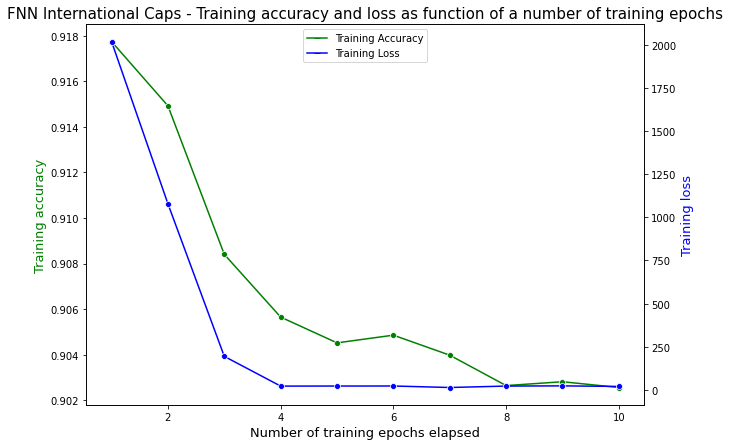

In [ ]:
# define structure of FNN
net = gluon.nn.Sequential()
with net.name_scope():
  net.add(nn.Dense(2)) 

# call helpers to initialize objects used in training
ctx, criterion, metric, trainer = create_ctx_criterion_metric_trainer(net,'adam', 0.0001)

#train & test
train_loader, test_loader = split_and_load(cleaned_joined_df["IntCaps Binary Label"], 50)
accuracy_list, loss_list = train_network(net, train_loader, 10, 0.0001, 'adam')
test_model(net, test_loader, 'adam')
plot_training(accuracy_list, loss_list, 10, "International Caps")

With the most primitive neural network we could possibly build, we have acquired an accuracy of around 90%, which is solid, but probably does not utilize the entirety of the predictive power of feedforward neutral networks. Furthermore, the performance of our model on the training data worsened with each epoch, pointing to the non-optimal structure of our FNN as it currently stands.

####Hyperparameter Tuning

Indeed, the most primitive model works "good enough", but let's see if we can do better. Let's start by trying out all possible combinations for the number of hidden levels in our network and the number of neurons in each layer to some reasonable upper threshold and see where that leads us. Let's use the sigmoid function as [the internet suggests](https://towardsdatascience.com/what-are-hyperparameters-and-how-to-tune-the-hyperparameters-in-a-deep-neural-network-d0604917584a) it is a popular choice for binary predictions. Let's try out a feasible number of feasible combinations for the number of hidden levels in our network and the number of neurons in each layer, capping the first at 4 and the latter at 500 (while stepping by 100). Feasible is a relative term, but in our mind it is unreasonable to be running one cell for hours. For computational simplicity, let's make each layer have the same number of neurons. We train with 5 epochs to speed up the process.

We get the highest testing accuracy (93.38%) with 4 inner layers and 500 neurons per layer


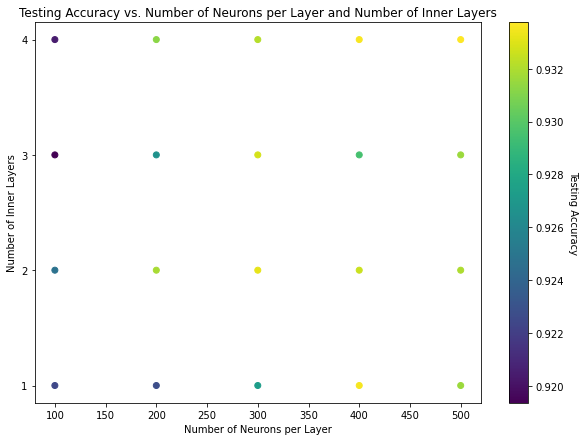

In [ ]:
combos_dict = {}
num_neuron_lst = []
depth_lst = []
acc_lst = []

# make one global train/test split used by each call
train_loader, test_loader = split_and_load(cleaned_joined_df["IntCaps Binary Label"], 50)

for j in range(100,501,100): # limit each layer at 500, step by 100
  for i in range(1,5): # do at most 4 layers
    net = gluon.nn.Sequential()
    with net.name_scope(): 
      for k in range(1,i+1): # do at most 4 layers 
          net.add(nn.Dense(j,activation='sigmoid'))
      net.add(nn.Dense(2)) # last layer has to have binary output

    ctx, criterion, metric, trainer = create_ctx_criterion_metric_trainer(net,'adam',0.0001)

    train_network(net, train_loader, 5, 0.0001, 'adam',printOut=False)
    test_acc = test_model(net, test_loader, 'adam', printOut=False)
    combos_dict[(i, j)] = test_acc # record current accuracy with current j,i combo
    acc_lst.append(test_acc)
    num_neuron_lst.append(j)
    depth_lst.append(i)

best_combo = None
max_acc = 0

for combo in combos_dict.keys():
  if combos_dict[combo] > max_acc:
    best_combo = combo
    max_acc = combos_dict[combo]

print(f"We get the highest testing accuracy ({round(max_acc * 100, 2)}%) with {best_combo[0]}\
 inner layers and {best_combo[1]} neurons per layer")

fig, ax = plt.subplots();
d_points = ax.scatter(num_neuron_lst, depth_lst, c = acc_lst, cmap = sns.color_palette("viridis", as_cmap = True));
cbar = fig.colorbar(d_points);
ax.set_xlabel("Number of Neurons per Layer");
ax.set_ylabel("Number of Inner Layers");
ax.yaxis.get_major_locator().set_params(integer=True)
ax.set_title("Testing Accuracy vs. Number of Neurons per Layer and Number of Inner Layers");
cbar.set_label("Testing Accuracy", rotation = 270, labelpad = 15);

Out of the combinations that we started with, the most optimal is the one using 500 neurons per layer at 4 hidden layers, i.e. the most complex FNN we have trained on. With international caps then, it seems that an even more complex model would do perhaps do better. Given that the previous cell took 33 minutes to run and hypertuning on 20 even more complex models would presumably take even longer, let us consider just 4 models for our next round of hypertuning, letting the number of inner layers range from 4 to 5 and the number of neurons per layer range from 500 to 750 with a jump of 250.

We get the highest testing accuracy (93.4%) with 4 inner layers and 500 neurons per layer


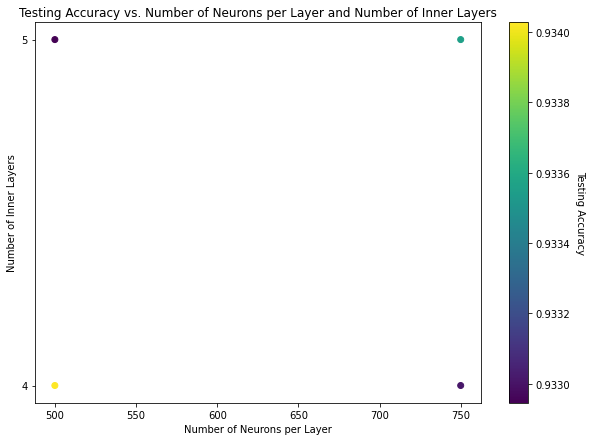

In [ ]:
bcombos_dict = {}
num_neuron_lst = []
depth_lst = []
acc_lst = []

# make one global train/test split used by each call
train_loader, test_loader = split_and_load(cleaned_joined_df["IntCaps Binary Label"], 50)

for j in range(500,751,250): # limit each layer at 500, step by 250
  for i in range(4,6): # do 4 and 5 layers
    net = gluon.nn.Sequential()
    with net.name_scope(): 
      for k in range(1,i+1): # do 4 and 5 layers
          net.add(nn.Dense(j,activation='sigmoid'))
      net.add(nn.Dense(2)) # last layer has to have binary output

    ctx, criterion, metric, trainer = create_ctx_criterion_metric_trainer(net,'adam',0.0001)

    # train and test network
    train_network(net, train_loader, 5, 0.0001, 'adam',printOut=False)
    test_acc = test_model(net, test_loader, 'adam', printOut=False)
    combos_dict[(i, j)] = test_acc # record current accuracy with current j,i combo
    acc_lst.append(test_acc)
    num_neuron_lst.append(j)
    depth_lst.append(i)

# set up framework for inter-model comparison
best_combo = None
max_acc = 0

for combo in combos_dict.keys():
  if combos_dict[combo] > max_acc:
    best_combo = combo
    max_acc = combos_dict[combo]

print(f"We get the highest testing accuracy ({round(max_acc * 100, 2)}%) with {best_combo[0]}\
 inner layers and {best_combo[1]} neurons per layer")

fig, ax = plt.subplots();
d_points = ax.scatter(num_neuron_lst, depth_lst, c = acc_lst, cmap = sns.color_palette("viridis", as_cmap = True));
cbar = fig.colorbar(d_points);
ax.set_xlabel("Number of Neurons per Layer");
ax.set_ylabel("Number of Inner Layers");
ax.yaxis.get_major_locator().set_params(integer=True)
ax.set_title("Testing Accuracy vs. Number of Neurons per Layer and Number of Inner Layers");
cbar.set_label("Testing Accuracy", rotation = 270, labelpad = 15);

Interestingly, the least complex FNN in this second batch of hypertuning turned out to be most predictive, albeit just by about 0.1%. Firstly (and fortunately), this shows that the FNN with 500 neurons per layer and 4 layers is optimal for our label at least within the set of FNN configurations we consider to be computationally feasible for our purposes. Secondly, this shows that with an FNN, there is no simple relationship of the type "the more the merrier." Now, it is almost certain that the number of layers and neurons could be finetuned further, but this would take long and it is not clear that the incremental gains in accuracy would be significant. Note that even in our first batch of 20 potential models we tried, the performance differed by about 1.2% (as judging by the legend) and yet the models took about half an hour to train. At this point we remember the trade off between accuracy and time investment and decide to step away from altering the number of layers and neurons for our international caps classifier and turning our attention to different hyperparameters. 

Let's take the most optimal FNN arrangement we have found (4 layers, 500 neurons per each) and continue our hyperparameter tuning by varying the activation function. To prevent exponential blowup from the number of possibilities we could test, let's not mix them up and just make the entire network use one function in each layer. For speed let's use 5 training epochs.



In [ ]:
for elt in ['sigmoid','relu','tanh']:
  net = gluon.nn.Sequential()
  with net.name_scope():
    net.add(nn.Dense(500,activation=elt))
    net.add(nn.Dense(500,activation=elt))  
    net.add(nn.Dense(500,activation=elt)) 
    net.add(nn.Dense(500,activation=elt))   
    net.add(nn.Dense(2)) 

  ctx, criterion, metric, trainer = create_ctx_criterion_metric_trainer(net,'adam', 0.0001)

  train_loader, test_loader = split_and_load(cleaned_joined_df["IntCaps Binary Label"], 50)
  accuracy_list, loss_list = train_network(net, train_loader, 5, 0.0001, 'adam',printOut=False)
  print(f"{elt}: ")
  test_model(net, test_loader, 'adam')

sigmoid: 

Testing FNN...
-------------------------------------------------------------------------------------------
The loss for running the FNN on the test data is 0.1746697881137541. The accuracy is 0.9271326213329728
-------------------------------------------------------------------------------------------
relu: 

Testing FNN...
-------------------------------------------------------------------------------------------
The loss for running the FNN on the test data is 0.2230876131765135. The accuracy is 0.9102338785994322
-------------------------------------------------------------------------------------------
tanh: 

Testing FNN...
-------------------------------------------------------------------------------------------
The loss for running the FNN on the test data is 0.16821575035438882. The accuracy is 0.9330809787751791
-------------------------------------------------------------------------------------------


We go with tanh, it seems. Now let's see for the learning rate, trying three different configurations with adjacent ones varying by a factor of 10. 


In [ ]:
for elt in [0.01, 0.001, 0.0001]:
  net = gluon.nn.Sequential()
  with net.name_scope():
    net.add(nn.Dense(500,activation="tanh"))  
    net.add(nn.Dense(500,activation="tanh")) 
    net.add(nn.Dense(500,activation="tanh")) 
    net.add(nn.Dense(500,activation="tanh"))   
    net.add(nn.Dense(2)) 

  ctx, criterion, metric, trainer = create_ctx_criterion_metric_trainer(net,'adam', elt)

  train_loader, test_loader = split_and_load(cleaned_joined_df["IntCaps Binary Label"], 50)
  accuracy_list, loss_list = train_network(net, train_loader, 5, elt, 'adam',printOut=False)
  print(f"Learning rate {elt}: ")
  test_model(net, test_loader, 'adam')

Learning rate 0.01: 

Testing FNN...
-------------------------------------------------------------------------------------------
The loss for running the FNN on the test data is 0.29078085420481237. The accuracy is 0.9170609706637826
-------------------------------------------------------------------------------------------
Learning rate 0.001: 

Testing FNN...
-------------------------------------------------------------------------------------------
The loss for running the FNN on the test data is 0.2625951070778653. The accuracy is 0.9170609706637826
-------------------------------------------------------------------------------------------
Learning rate 0.0001: 

Testing FNN...
-------------------------------------------------------------------------------------------
The loss for running the FNN on the test data is 0.1770844165433406. The accuracy is 0.9289576855481952
-------------------------------------------------------------------------------------------


And so we go with the lowest rate of 0.0001 which has the lowest loss and highest accuracy. There are more parameters to still be optimized, but for the sake of not making this project unreasonably long, let's not continue any further and assume the model we have constructed is optimal within bounds of temporal feasability. So, our winner is a network with 4 hidden layers, 500 neurons per layer and it uses a tanh activation function along its layers with a learning rate of 0.0001. Let's train it for 10 epochs and see how much we've improved.

-------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------
Training FNN...
The loss for Epoch 1 is: 0.2147463128964912. The accuracy for Epoch 1 is 0.920046643682823
The loss for Epoch 2 is: 0.18575654454710097. The accuracy for Epoch 2 is 0.9260292030014196
The loss for Epoch 3 is: 0.17956061758046088. The accuracy for Epoch 3 is 0.9274487933482052
The loss for Epoch 4 is: 0.17442752883862686. The accuracy for Epoch 4 is 0.9288007841546677
The loss for Epoch 5 is: 0.17190695285619834. The accuracy for Epoch 5 is 0.9303724734671804
The loss for Epoch 6 is: 0.16981088916299503. The accuracy for Epoch 6 is 0.9308287703643615
The loss for Epoch 7 is: 0.16891638625871255. The accuracy for Epoch 7 is 0.9303048739268573
The loss for Epoch 8 is: 0.1684112702946807. The accuracy for Epoch 8 is 0.9295612789833029
The loss for Epoch 9 is: 0.16666128588989573. The accuracy 

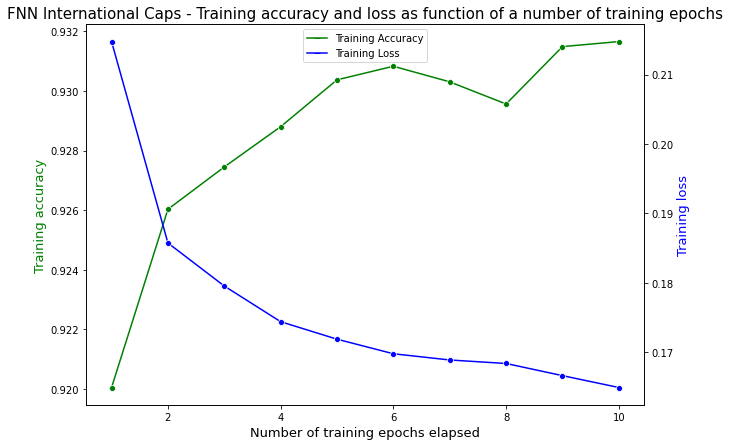

In [ ]:
net = gluon.nn.Sequential()
with net.name_scope():
  net.add(nn.Dense(500,activation="tanh"))  
  net.add(nn.Dense(500,activation="tanh")) 
  net.add(nn.Dense(500,activation="tanh")) 
  net.add(nn.Dense(500,activation="tanh"))
  net.add(nn.Dense(2)) 

ctx, criterion, metric, trainer = create_ctx_criterion_metric_trainer(net,'adam', 0.0001)

train_loader, test_loader = split_and_load(cleaned_joined_df["IntCaps Binary Label"], 50)
accuracy_list, loss_list = train_network(net, train_loader, 10, 0.0001, 'adam')
test_model(net, test_loader, 'adam')
plot_training(accuracy_list, loss_list, 10, "International Caps")

In the end, we jumped from an accuracy of about 90.1% without any parameter tunning to an accuracy of about 93.3%. In the context of our database, this means that around 2000 more players were classified correctly. In absolute terms, hypertuning took about 60 minutes of pure machine time to achieve an increase in accuracy of about 3.2%. Perhaps our hypertuning was worth it: we have incurred a one-time overhead cost to improve the predictiveness of our model by a non-negligible amount. Of course, more parameters could be varied (optimizer, batch size, etc.) and even the ones we did tune could be done so more diligently (we could potentially try out an exponential number of activation function permutations).

###Multiclass Classifier (Current Ability - 2020)

Our multiclass classifier seems more complex than the one relating to international caps among other things because of how we decided to define our labels - the previous one was binary while this current one has 4 buckets associated with it. Based on the fact that determining the current ability of a player based on their attributes from some time ago seems like a non-straightforward task and the correlations that will be implicitly deduced by our FNN presumably being less trivial than those deciding for a binary label, we predict that the initial accuracy of our model without any finetuning will be smaller than with the binary international caps label.

####Naive network

Once again let's build the most primitive network possible and see where that takes us. No hidden layers, just pure vibes for now.

-------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------
Training FNN...
The loss for Epoch 1 is: 24245.830104150453. The accuracy for Epoch 1 is 0.5585581018049077
The loss for Epoch 2 is: 20997.818453136962. The accuracy for Epoch 2 is 0.6802541742716149
The loss for Epoch 3 is: 17969.558992020993. The accuracy for Epoch 3 is 0.723095382951396
The loss for Epoch 4 is: 14834.872421229433. The accuracy for Epoch 4 is 0.7266781585885216
The loss for Epoch 5 is: 11744.306965263751. The accuracy for Epoch 5 is 0.7241093760562428
The loss for Epoch 6 is: 8717.712545461001. The accuracy for Epoch 6 is 0.7276921516933685
The loss for Epoch 7 is: 5630.708252483197. The accuracy for Epoch 7 is 0.7241093760562428
The loss for Epoch 8 is: 2498.1606908748868. The accuracy for Epoch 8 is 0.7232136821469614
The loss for Epoch 9 is: 167.51294470920465. The accuracy for Epoch

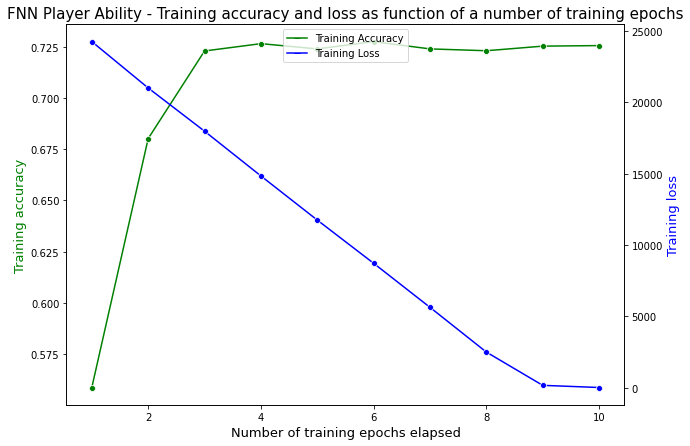

In [ ]:
net = gluon.nn.Sequential()
with net.name_scope():
  net.add(nn.Dense(4)) 

ctx, criterion, metric, trainer = create_ctx_criterion_metric_trainer(net,'adam', 0.0001)

train_loader, test_loader = split_and_load(cleaned_joined_df["Current Ability (2020) Multiclass Label"], 50)
accuracy_list, loss_list = train_network(net, train_loader, 10, 0.0001, 'adam')
test_model(net, test_loader, 'adam')
plot_training(accuracy_list, loss_list, 10, "Player Ability")

Sadly, non-optimized parameters don't get us very far, as we've expected. With an accuracy of just 71.6%, this classifier is where we really hope that our hyperparameter tuning efforts will pay off with a greater accuracy increase after optimization.

####Hyperparameter Tuning

Once again let's try out a feasible number of feasible combinations for the number of hidden levels in our network and the number of neurons in each layer. Hence, we set limits once again at at most 4 layers and at most 500 neurons per layer. This time, we start with the relu fuction to prevent having to deal with a vanishing gradient. Let's also train for 7 epochs to account for the fact that our classifier is less trivial this time.

We get the highest testing accuracy (75.96%) with 3 inner layers and 500 neurons per layer


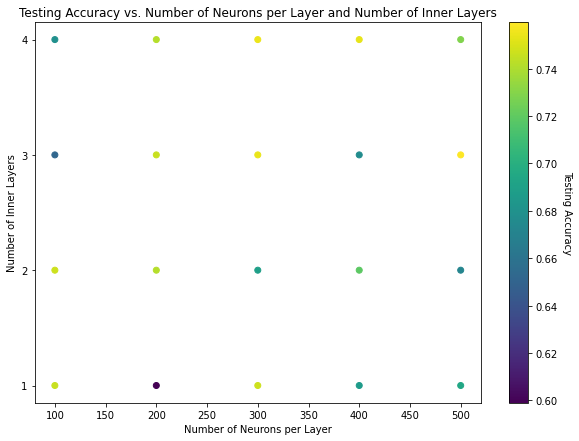

In [ ]:
combos_dict = {}
num_neuron_lst = []
depth_lst = []
acc_lst = []

# make one global train/test split used by each call
train_loader, test_loader = split_and_load(cleaned_joined_df["Current Ability (2020) Multiclass Label"], 50)

for j in range(100,501,100): # limit each layer at 500, step by 100
  for i in range(1,5): # do at most 4 layers
    net = gluon.nn.Sequential()
    with net.name_scope(): 
      for k in range(1,i+1): # do at most 4 layers 
          net.add(nn.Dense(j,activation='relu'))
      net.add(nn.Dense(4)) # last layer has 4 labels

    ctx, criterion, metric, trainer = create_ctx_criterion_metric_trainer(net,'adam',0.0001)

    train_network(net, train_loader, 7, 0.0001, 'adam',printOut=False)
    test_acc = test_model(net, test_loader, 'adam', printOut=False)
    combos_dict[(i, j)] = test_acc # record current accuracy with current j,i combo
    acc_lst.append(test_acc)
    num_neuron_lst.append(j)
    depth_lst.append(i)

best_combo = None
max_acc = 0

for combo in combos_dict.keys():
  if combos_dict[combo] > max_acc:
    best_combo = combo
    max_acc = combos_dict[combo]

print(f"We get the highest testing accuracy ({round(max_acc * 100, 2)}%) with {best_combo[0]}\
 inner layers and {best_combo[1]} neurons per layer")

fig, ax = plt.subplots();
d_points = ax.scatter(num_neuron_lst, depth_lst, c = acc_lst, cmap = sns.color_palette("viridis", as_cmap = True));
cbar = fig.colorbar(d_points);
ax.set_xlabel("Number of Neurons per Layer");
ax.set_ylabel("Number of Inner Layers");
ax.yaxis.get_major_locator().set_params(integer=True)
ax.set_title("Testing Accuracy vs. Number of Neurons per Layer and Number of Inner Layers");
cbar.set_label("Testing Accuracy", rotation = 270, labelpad = 15);

As expected, with a seemingly complex label, a relatively complex FNN is also required, and here it is worth noting that the different models differed in performance by almost 16% this time, i.e., there is greater variation in terms of model performance than with a more trivial binary label. Perhaps this points to the greater intrinsic complexity of mapping the features to a less straightforwar label? In any case, we stick to our winner at 3 layers 500 neurons. Let's continue our hyperparameter tuning process by varying the activation function then. 5 training epochs are taken.


In [ ]:
for elt in ['sigmoid','relu','tanh']:
  net = gluon.nn.Sequential()
  with net.name_scope():
    net.add(nn.Dense(500,activation=elt))
    net.add(nn.Dense(500,activation=elt))  
    net.add(nn.Dense(500,activation=elt))     
    net.add(nn.Dense(4)) 

  ctx, criterion, metric, trainer = create_ctx_criterion_metric_trainer(net,'adam', 0.0001)

  train_loader, test_loader = split_and_load(cleaned_joined_df["Current Ability (2020) Multiclass Label"], 50)
  accuracy_list, loss_list = train_network(net, train_loader, 5, 0.0001, 'adam',printOut=False)
  print(f"{elt}: ")
  test_model(net, test_loader, 'adam')

sigmoid: 

Testing FNN...
-------------------------------------------------------------------------------------------
The loss for running the FNN on the test data is 0.362537886224948. The accuracy is 0.7543598756252535
-------------------------------------------------------------------------------------------
relu: 

Testing FNN...
-------------------------------------------------------------------------------------------
The loss for running the FNN on the test data is 111.55147942054057. The accuracy is 0.739624171961606
-------------------------------------------------------------------------------------------
tanh: 

Testing FNN...
-------------------------------------------------------------------------------------------
The loss for running the FNN on the test data is 0.38291048166902736. The accuracy is 0.7469244288224957
-------------------------------------------------------------------------------------------


Sigmoid it is. What about the learning rate?


In [ ]:
for elt in [0.01, 0.001, 0.0001]:
  net = gluon.nn.Sequential()
  with net.name_scope():
    net.add(nn.Dense(500,activation="sigmoid"))
    net.add(nn.Dense(500,activation="sigmoid"))    
    net.add(nn.Dense(500,activation="sigmoid"))        
    net.add(nn.Dense(4)) 

  ctx, criterion, metric, trainer = create_ctx_criterion_metric_trainer(net,'adam', elt)

  train_loader, test_loader = split_and_load(cleaned_joined_df["Current Ability (2020) Multiclass Label"], 50)
  accuracy_list, loss_list = train_network(net, train_loader, 5, elt, 'adam',printOut=False)
  print(f"Learning rate {elt}: ")
  test_model(net, test_loader, 'adam')

Learning rate 0.01: 

Testing FNN...
-------------------------------------------------------------------------------------------
The loss for running the FNN on the test data is 0.583039737696968. The accuracy is 0.6551304582939029
-------------------------------------------------------------------------------------------
Learning rate 0.001: 

Testing FNN...
-------------------------------------------------------------------------------------------
The loss for running the FNN on the test data is 0.377602916215926. The accuracy is 0.7628768419629579
-------------------------------------------------------------------------------------------
Learning rate 0.0001: 

Testing FNN...
-------------------------------------------------------------------------------------------
The loss for running the FNN on the test data is 0.3598616177543086. The accuracy is 0.7606462079221306
-------------------------------------------------------------------------------------------


0.001 is the way to go. So we have a network with 3 hidden layers, 500 neurons per layer and it uses a sigmoid activation function along its layers with a learning rate of 0.001. Let's train it for 10 epochs and see how much we've improved.

-------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------
Training FNN...
The loss for Epoch 1 is: 0.4915673014101147. The accuracy for Epoch 1 is 0.692929088082201
The loss for Epoch 2 is: 0.42578749904717667. The accuracy for Epoch 2 is 0.7314439261813019
The loss for Epoch 3 is: 0.41222687787138684. The accuracy for Epoch 3 is 0.738558777800311
The loss for Epoch 4 is: 0.40648575344200444. The accuracy for Epoch 4 is 0.7424288514838099
The loss for Epoch 5 is: 0.39833054808955287. The accuracy for Epoch 5 is 0.7455046305685121
The loss for Epoch 6 is: 0.3936316394454558. The accuracy for Epoch 6 is 0.7486818089636991
The loss for Epoch 7 is: 0.3933064420961555. The accuracy for Epoch 7 is 0.7482593118366795
The loss for Epoch 8 is: 0.3872722103171373. The accuracy for Epoch 8 is 0.7512843912661394
The loss for Epoch 9 is: 0.38367872405614667. The accuracy for

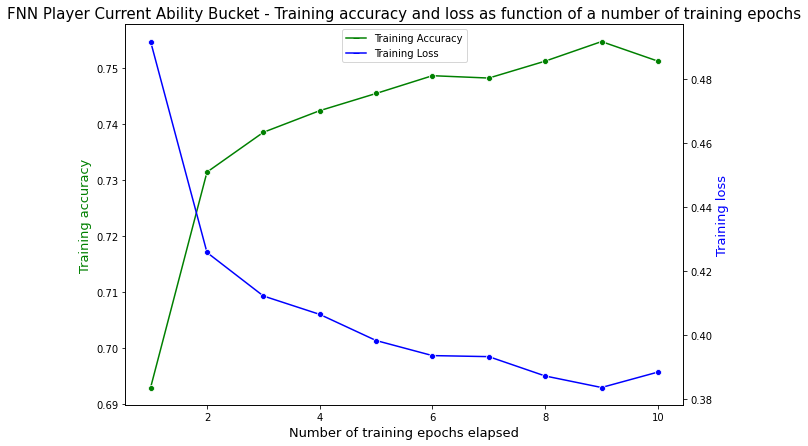

In [ ]:
net = gluon.nn.Sequential()
with net.name_scope():
  net.add(nn.Dense(500,activation="sigmoid"))
  net.add(nn.Dense(500,activation="sigmoid"))    
  net.add(nn.Dense(500,activation="sigmoid"))   
  net.add(nn.Dense(4)) 

ctx, criterion, metric, trainer = create_ctx_criterion_metric_trainer(net,'adam', 0.001)

train_loader, test_loader = split_and_load(cleaned_joined_df["Current Ability (2020) Multiclass Label"], 50)
accuracy_list, loss_list = train_network(net, train_loader, 10, 0.001, 'adam')
test_model(net, test_loader, 'adam')
plot_training(accuracy_list, loss_list, 10, "Player Current Ability Bucket")

A result of around 72.8% for a classifier as nuanced as ability buckets is solid in isolation, but much less so when we consider that our random forest classifiers achieved the same accuracy without any finetuning. Recall, however, that the FNN model could probably be finetuned further; our first foray into the optimal number of layers and neutrons per layer could suggest that adding more neurons per layer could be beneficial because the model we ultimately chose was at the upper limit for the number of neurons in a layer and it is not known whether more neurons per layer could improve predictive power. Sadly however, we must concede that with this classifier, our finetuning efforts were a questionable time investment as an almost 50-minute-long cell execution only effected an accuracy improvement of 1.2% percent. In this particular case then, the random forest classifier emerges as the clearly superior one as it takes less time to train, improves much more during training, and ultimately achieves an accuracy that's higher by 6%.

###Multiclass Classifier (Position)

####Naive network

As already mentioned, the mapping from attributes to positions feels like a greater semantic link than attributes with just ability: a striker we can expect to shoot well and a defender to defend well, but you could have both defenders and attackers of great current ability! Hence, we expect this multiclass classifier to work better than at least the Current Ability one.

This label requires minor pre-processing, however. In our split_and_load() function, we assume that our label is a numerical value, so let us first create a simple mapping from position to a numerical label ad hoc when dealing with predicting position.

In [ ]:
position_int_mapping = {'G':1,'D':2,'M':3,'A':4}
cleaned_joined_df['Position_num'] = cleaned_joined_df['Position'].str.strip().map(position_int_mapping)

Now we proceed as usual: at first, let's try no hidden layers, 4 outputs.

-------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------
Training FNN...
The loss for Epoch 1 is: 15356.618783369433. The accuracy for Epoch 1 is 0.40855472182789154
The loss for Epoch 2 is: 12306.499295041986. The accuracy for Epoch 2 is 0.5102413303589536
The loss for Epoch 3 is: 9298.610054230921. The accuracy for Epoch 3 is 0.5993037247346717
The loss for Epoch 4 is: 6213.660886377461. The accuracy for Epoch 4 is 0.6322923004123572
The loss for Epoch 5 is: 3300.9375540924743. The accuracy for Epoch 5 is 0.6454066112350436
The loss for Epoch 6 is: 2205.5864796467326. The accuracy for Epoch 6 is 0.6529777597512337
The loss for Epoch 7 is: 1566.5505645539515. The accuracy for Epoch 7 is 0.6803555735820996
The loss for Epoch 8 is: 916.1926584094028. The accuracy for Epoch 8 is 0.7556614615020618
The loss for Epoch 9 is: 372.9225817767876. The accuracy for Epoch

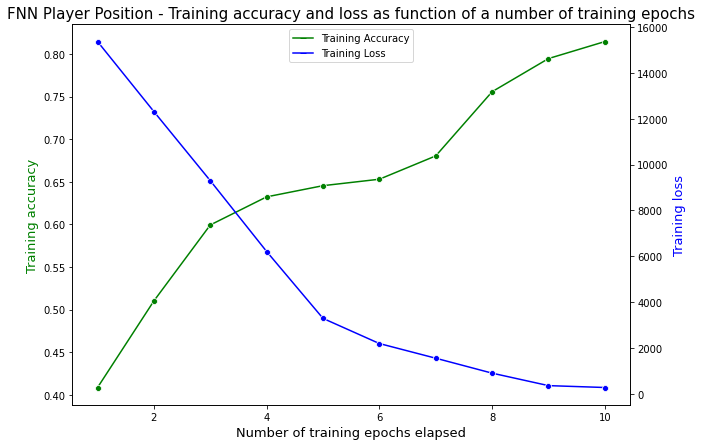

In [ ]:
net = gluon.nn.Sequential()
with net.name_scope():
  net.add(nn.Dense(4))

ctx, criterion, metric, trainer = create_ctx_criterion_metric_trainer(net,'adam', 0.0001)

train_loader, test_loader = split_and_load(cleaned_joined_df["Position_num"], 50)
accuracy_list, loss_list = train_network(net, train_loader, 10, 0.0001, 'adam')
test_model(net, test_loader, 'adam')
plot_training(accuracy_list, loss_list, 10, "Player Position")

As expected, without any optimization, our model performs better on position than on ability, and in real life the semantic connection between ability and attributes indeed seems more elusive than between position and attributes. Nevertheless, this is no excuse to keep our model unimproved, as with our previous classifiers we saw our hypertuning improve performance by a couple of percentage points.



####Hyperparameter Tuning

The procedure is similar. 4 layers at most, 500 neurons per layer max, 5 epochs, the most prescriptive models will emerge as the winner.

In [ ]:
combos_dict = {}
num_neuron_lst = []
depth_lst = []
acc_lst = []

# make one global train/test split used by each call
train_loader, test_loader = split_and_load(cleaned_joined_df["Position_num"], 50)

for j in range(100,501,100): # limit each layer at 500, step by 100
  for i in range(1,5): # do at most 4 layers
    net = gluon.nn.Sequential()
    with net.name_scope(): 
      for k in range(1,i+1): # do at most 4 layers 
          net.add(nn.Dense(j,activation='relu'))
      net.add(nn.Dense(4)) # last layer has 4 labels

    ctx, criterion, metric, trainer = create_ctx_criterion_metric_trainer(net,'adam',0.0001)

    train_network(net, train_loader, 5, 0.0001, 'adam',printOut=False)
    test_acc = test_model(net, test_loader, 'adam', printOut=False)
    combos_dict[(i, j)] = test_acc # record current accuracy with current j,i combo
    acc_lst.append(test_acc)
    num_neuron_lst.append(j)
    depth_lst.append(i)

best_combo = None
max_acc = 0

for combo in combos_dict.keys():
  if combos_dict[combo] > max_acc:
    best_combo = combo
    max_acc = combos_dict[combo]

print(f"We get the highest testing accuracy ({round(max_acc * 100, 2)}%) with {best_combo[0]}\
 inner layers and {best_combo[1]} neurons per layer")

We get the highest testing accuracy (84.09%) with 1 inner layers and 500 neurons per layer


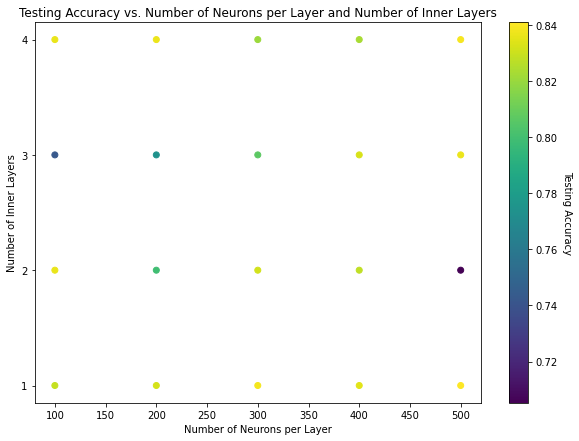

In [ ]:
fig, ax = plt.subplots();
d_points = ax.scatter(num_neuron_lst, depth_lst, c = acc_lst, cmap = sns.color_palette("viridis", as_cmap = True));
cbar = fig.colorbar(d_points);
ax.set_xlabel("Number of Neurons per Layer");
ax.set_ylabel("Number of Inner Layers");
ax.yaxis.get_major_locator().set_params(integer=True)
ax.set_title("Testing Accuracy vs. Number of Neurons per Layer and Number of Inner Layers");
cbar.set_label("Testing Accuracy", rotation = 270, labelpad = 15);

While the previous two labels seemed to require more complex FNNs to be more prescriptive, interestingly, this one does best with just one inner layer which has 500 neurons per layer. This further proves that with FNNs, more complex does not necessarily equal better. The specter of overfitting always looms close, after all. We take this into consideration as we determine the best activation function for our purposes.


In [ ]:
for elt in ['sigmoid','relu','tanh']:
  net = gluon.nn.Sequential()
  with net.name_scope():
    net.add(nn.Dense(500,activation=elt))  
    net.add(nn.Dense(4)) 

  ctx, criterion, metric, trainer = create_ctx_criterion_metric_trainer(net,'adam', 0.0001)

  train_loader, test_loader = split_and_load(cleaned_joined_df["Position_num"], 50)
  accuracy_list, loss_list = train_network(net, train_loader, 5, 0.0001, 'adam',printOut=False)
  print(f"{elt}: ")
  test_model(net, test_loader, 'adam')

sigmoid: 

Testing FNN...
-------------------------------------------------------------------------------------------
The loss for running the FNN on the test data is 0.07385381670216469. The accuracy is 0.8414221981884548
-------------------------------------------------------------------------------------------
relu: 

Testing FNN...
-------------------------------------------------------------------------------------------
The loss for running the FNN on the test data is 224.04537228924136. The accuracy is 0.8247262403677167
-------------------------------------------------------------------------------------------
tanh: 

Testing FNN...
-------------------------------------------------------------------------------------------
The loss for running the FNN on the test data is 0.07033041945880737. The accuracy is 0.8418953629849939
-------------------------------------------------------------------------------------------


So, tanh. Now, learning rate?


In [ ]:
for elt in [0.01, 0.001, 0.0001]:
  net = gluon.nn.Sequential()
  with net.name_scope():
    net.add(nn.Dense(500,activation="tanh"))  
    net.add(nn.Dense(4)) 

  ctx, criterion, metric, trainer = create_ctx_criterion_metric_trainer(net,'adam', elt)

  train_loader, test_loader = split_and_load(cleaned_joined_df["Position_num"], 50)
  accuracy_list, loss_list = train_network(net, train_loader, 5, elt, 'adam',printOut=False)
  print(f"Learning rate {elt}: ")
  test_model(net, test_loader, 'adam')

Learning rate 0.01: 

Testing FNN...
-------------------------------------------------------------------------------------------
The loss for running the FNN on the test data is 1.0798712300127369. The accuracy is 0.3356090306881168
-------------------------------------------------------------------------------------------
Learning rate 0.001: 

Testing FNN...
-------------------------------------------------------------------------------------------
The loss for running the FNN on the test data is 0.06974268871394874. The accuracy is 0.8392591591185615
-------------------------------------------------------------------------------------------
Learning rate 0.0001: 

Testing FNN...
-------------------------------------------------------------------------------------------
The loss for running the FNN on the test data is 0.07279317780806223. The accuracy is 0.8413546032175206
-------------------------------------------------------------------------------------------


0.0001 is the final verdict. So we have a network with 1 hidden layer which has 500 neurons and it uses a tanh activation function along its layers with a learning rate of 0.0001. Let's train it for 10 epochs and see how much we've improved.

-------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------
Training FNN...
The loss for Epoch 1 is: 0.5714798480592618. The accuracy for Epoch 1 is 0.6565605353883593
The loss for Epoch 2 is: 0.20869641534327849. The accuracy for Epoch 2 is 0.8193233286013655
The loss for Epoch 3 is: 0.12348034888262166. The accuracy for Epoch 3 is 0.8321672412627594
The loss for Epoch 4 is: 0.09040738179960414. The accuracy for Epoch 4 is 0.8381667004664368
The loss for Epoch 5 is: 0.07768181668977132. The accuracy for Epoch 5 is 0.841326978976543
The loss for Epoch 6 is: 0.06994735043001556. The accuracy for Epoch 6 is 0.8428479686338133
The loss for Epoch 7 is: 0.06458280472650108. The accuracy for Epoch 7 is 0.8444027580612452
The loss for Epoch 8 is: 0.06135550064149279. The accuracy for Epoch 8 is 0.8450449536943149
The loss for Epoch 9 is: 0.05824708948520652. The accuracy

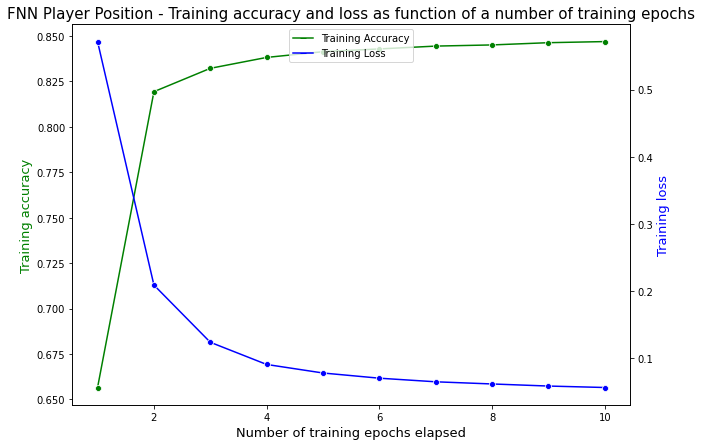

In [ ]:
net = gluon.nn.Sequential()
with net.name_scope():
  net.add(nn.Dense(500,activation="tanh"))   
  net.add(nn.Dense(4)) 

ctx, criterion, metric, trainer = create_ctx_criterion_metric_trainer(net,'adam', 0.0001)

train_loader, test_loader = split_and_load(cleaned_joined_df["Position_num"], 50)
accuracy_list, loss_list = train_network(net, train_loader, 10, 0.0001, 'adam')
test_model(net, test_loader, 'adam')
plot_training(accuracy_list, loss_list, 10, "Player Position")

Again, finetuning has improved the performance of our model significantly. from around 81.8% we go to about 84.6%, which serves confirms that our hyperparameter optimizing efforts were not futile. Also, let's think in the context of the real footballing world here. An improvement of 2.8% means that around 2000 more players were classified correctly after we finetuned. Given that clubs have limited budgets and can only afford to buy so many players each season, a more robust predictive framework is more likely to ensure that whichever player they opt to buy will indeed be a player with the ability level they require. 40 more minutes of further training which ensures that we find a more suitable player for our needs is likely a worthy time investment.

#**Conclusions**

##EDA

EDA really allowed us to investigate and hopefully answer many smaller scale (but still interesting) questions about the data while also gaining some much needed familiarity with the datasets in general.

Through our various visualizations, we could see how different features or player variables were distributed in our datasets and how different features were potentially related to others.

Pairplots of the correlation between the positions and selected attributes didn't show any clear relationship between the positions and those atttributes. The density plots showed that the distribution of some attributes are roughly uniform and for other skewed to the left. Most surprisingly, the distribution of the Goalkeeper position showed that players were either ranked as very bad or very good goalkeepers.

We saw a wage distribution that was heavily skewed rightward by some high earning outlier players. We saw how each position group was about evenly paid except goalkeepers had a noticeably tighter distribution of wages than the other positions.

We were able to visualize how the distribution of preferred foot has slightly (but likely not significantly) changed over the years to include more left-footed players. Further analysis on foot preference showed us that most Goalkeepers and Midfielders prefer playing with their right foot, which is also true for the other two positions, but it is not as striking.

And we were able to plot the relationship between age and ability (which probably misleadingly showed a positive relationship due to a lack of data on the abilities of actual old people due to this being a dataset of professionals).

The geography-based section of our EDA focused on visualizing various attributes via chloropleths and was able to reveal salient idiosyncrasies about our dataset. For instance, from observing the significant similarity between the frequency distribution chloropleths for the FM2020 dataset and the joined dataset we could conclude that our join did not discriminate geographically, i.e., players eliminated from the joined dataset did not disproportionately come from some specific country or continent. 

The same two chloropleths also illustrated which leagues are represented in the FM games, as marked by the relative sparsity of African players in our datasets. 

In our EDA we also explored a question that interested us personally: is the stereotype that South American players are more aggressive and temperamental correct? Our analysis has revealed that this is not the case and that in particularly with temperament, South America is lagging behind all other continents. 

Another question we explored in our EDA was the question of whether being born early in the year is an advantage due to how youth football is structured. Our analysis has shown that while players born early in the year are relatively overrepresented in the beautiful game, there is no clear relationship between player ability and birth month in adulthood.

##Modeling

###Linear Regression

The Linear Regression models were underwhelming. The models concerning the prediction of a player's ability did okay, with an RMSE value of about 13 and R2 score of about 68%. PCA, Lasso and Ridge Regularization didn't help, suggesting that there weren't really any correlation between our variables and feature redundancies. The Lasso regularized model didn't shrink that many of the features to zero or close to zero, suggesting that there weren't really any insignificant features that would clutter the model. <br>
The Linear Regression models for predicting the weekly wage and value of the players turned out to not be very predictive. The large fraction of rows with 0 EUR for both columns might have hindered the performance of the model. Some of the next steps could include undersampling the players with wage and value of 0 EUR and trying to find other features that can better predict these two variables.

###Random Forest

The Random Forest models, with the exception of the 2020 ability multiclass classifier, performed relatively well. After some hyperparameter tuning, we were able to achieve testing accuracies over 90% for both our binary international caps classifier and our multiclass position classifier.

Unfortunately, we were less successful when it came to predicting 2020 Ability with Random Forests. After hyperparameter tuning, our best testing accuracy was just shy of 80%. This was enough, however, to establish Random Forest models as our most superior classifier for predicting Current Ability. With this label, Random Forests outperformed FNNs by about 6 percent. The story is similar for the Position label too, where Random Forests outperformed FNNs by about 6 to 7 percent.

As for the International Caps label, the Feedforward Neural Nets were slightly better (by about 1%) in regards to testing accuracy when it came to International Caps, but not by that much that one is a clear winner.  Perhaps if we tuned the hyperparameters more extensively with the Random Forest classifiers, we've could've squeezed out an extra % or two for our testing accuracy and reached greater success as compared to Feedforward Neural Nets.

###Feedforward Neural Net

And certainly, further hyperparameter tuning could be done with FNNs as well. It cannot be denied that with this project our predictiveness was hindered by our fears of exponential blowup in terms of the number of different testable permutations dictating the parameters by which we construct our FNNs. One must recall the inherent "predictive power vs time demand" trade-off: the number of such permutations is inherently unbounded. Aside from being faced with decisions on how to set learning rate, batch size, etc., there could conceivably be an infinite number of variably-sized hidden layers in an FNN network. As we've discussed, the construction of a sophisticated NN model like Inception-4 is not just science; it's art as well.

Still, with our uniform FNN constructing process and hyperparameter tuning procedure that saw us vary the number of hidden layers, the number of neurons per layer, the activation function, and the learning rate, we were able to produce FNNs that we claim (in good faith, hopefully) are relatively optimized for the scope of this project as it relates to our computational abilities. In the end, with our FNNs we were able to achieve an accuracy of around 93.2% for the International Caps, 72.8% for Current Ability, and 84.6% for Position. Interestingly, the optimization process was more fruitful for what we consider to be our more primitive labels (international caps, position) as it was for the more complex one (current ability) as judged by how much the models improved during training.

Indeed, hyperparameter tuning improved the predictiveness of our international cap classifier by around 3.2% percent and of our position classifier by 2.8%; with current ability it was just around 1.2%. Seeing this reminded us of how FNNs derive their predictive abilities from observing more nuanced relationships between features. It is possible that the relationship between prior attributes and current ability is just too elusive due to the presence of factors such as but not limited to injuries and team chemistry. 

While FNNs are inherently designed to capture compositional relationships between different values in a way we humans wouldn't be able to, perhaps a lack of more information about the players - e.g. whether they've had major injuries - prevented our FNNs from capturing truly insightful hidden relations between features which would in turn make their training process more effective. At the end of the day, player attributes (i.e. the vast majority of our features) do not tell the whole picture and the impressive delicate relationships our FNNs would ideally capture would be more likely to emerge if more features relevant to ability were present. The ihnerent assumption is that current ability will depend on factors outside of playing attributes more so than position, which is largely defined by how good a player is at some certain skill. Simultaneously, the learning process with our Position classifier model was more successful at 2.8% improvement perhaps precisely because our FNNs could leverage the strong intuitive semantic link between, e.g., which attribute combinations make a good defender. With a strong semantic link like this - a good defender is likely to head the ball well, for instance - there is a lot more opportunity for the emergence of more subtle yet presumably more intuitive interrelations between specific feature combinations and the Position label.

#**Potential Next Steps**

- We could try and find data from the years in-between 2017 and 2020 and see if including this extra data can be used to strengthen our future performance (2020 ability) prediction models. Predicting future performance on just one year of stats from 3 years ago would presumably be harder than predicting future performance based on stats from each year going back 3 years.
  - It probably wouldn't amount to much, but with multiple years worth of stats, we could compare our results between the years like looking at our position prediction model based on only 2017 vs. position prediction model based on only 2018, etc... to see if the various features were more correlated or predictive of position in certain years compared to others. (Although we probably wouldn't see significant changes with position, if we were to compare our future performance models based on different individual years, we could see how much more predictive the previous year is over years further in the past).

- Our current (2020) ability values were relatively normally distributed and so each ability "bucket" we created was not equally represented in our data. One solution would be to either undersample some of the more popular "normal" instances or oversample the rarer "extreme" instances. But what we could also do, which would also change the relevant prediction question slightly, would be to change our label from unrelative performance (0-50, 51-100, etc...) to relative performance (bottom 25%, 2nd lowest 25%, 2nd highest 25%, top 25%). Since our data is dealing with professional players, it's probably easy to predict whether they'd fall in the 0-50 current ability range (most likely not as they then probably wouldn't make it professionally). And if you're a scout, you don't really care if a player is a 160/200 if everybody else in the league is 170/200. It's all relative in a competitive sport. So if we changed our labels to quartile cutoffs, we'd have equal samples of each quartile bucket and our predictions would be helping with more difficult and interesting questions.

- With more sophisticated finetuning procedures, - e.g., the deployment of k-fold cross validation mechanisms to determine a more optimal FNN configuration - models with greater predictive power could likely be produced. Nevertheless, with greater precision comes a greater time overhead; the FNN section of this notebook already took us about 3 hours to run! Training each proposed model on multiple validation folds would expand this time requirement even further, and significantly so. For a football club that's as big a mess as Manchester United at the moment, perhaps the incremental time investment needed to predict the future ability of players more accurately would be worth it. For simple enthusiasts for the beautiful game like us, it seems rather excessive. This is especially because with each one of our FNN classifiers, we managed to improve our performance through our hypertuning process.